\begin{titlepage}
   \begin{center}
       \vspace*{1cm}
        \Huge
       \textbf{Report 3}

       \vspace{0.5cm}
        Tinder for Movies - Challenge HS 2022

       \vspace{1.5cm}

       Daniela Herzig, Thomas Mandelz, Joseph Weibel, Jan Zwicky

       \vfill

      \tiny
   \end{center}
\end{titlepage}
\tableofcontents
\newpage


Dieser Bericht beschreibt die Modellierung der Recommdersysteme und deren Evaluierung.

# Pipeline
Am Anfang der Aufgabenstellung wollten mit der Modellierung beginnen. Wir wussten aus vorherigen Challenges und Projekten, dass ein sauberer Aufbau der Pipeline uns auf die Dauer Zeit sparen wird. Wir haben somit angefangen zu definieren was ein Recommendersystem können muss, damit wir alles geplante modellieren können und dabei unterschielichste Konfigurationen mit wenig Aufwand testen können.

## Namensgebung
Unsere Pipeline haben wir `cakeommender` genannt. Der Name hat nur einen losen Zusammenhang mit den Filmen welche er vorschlagen soll.
An einem der ersten Meetings haben wir als Gedankenstütze zusammen einen Kuchen gegessen.
Inspiriert durch den Kuchen haben wir dem Recommendersystem den "provisorischen" Namen cakeommender gegeben.
Dieser Name besteht nun aber bis zum Ende der Challenge!

## Konfiguration
Wir möchten mit möglichst wenig Codezeilen einen Recommendersystem definieren und konfigurieren können.
Dazu benötigen wir ein Konfigurationsobjekt, dass der Pipeline übergeben werden kann. Anhand von diesem soll das Recommendersystem korrekt initialisiert und erstellt werden.

### CakeConfig
Dazu kann eine CakeConfig erstellt werden. Sie besteht aus den folgenden Attributen:

- weightsDistribution
- similarity
- ratingScale
- featureNormalisation

#### weightsDistribution
Die Weights-Distribution ist ein Zeilenvektor von Dezimalzahlen (0-inf), dessen Dimensionen der Länge der Features entspricht. Dieser Vektor wird verwendet um die Features zu gewichten.

#### similarity
Die Similarity besteht aus einem Enum (Kategorie), welche die folgenden Werte annehmen kann: `Cosine`, `Pearson` und `Jaccard`

<br>
Der übergebene Wert bestimmt somit das Ähnlichkeitsmass, welches das Recommendersystem zur Berechnung der Userprofil-Filmprofil-Ähnlichkeiten verwendet. Jaccard wurde bei unserer Modellierung nicht eingesetzt, da es für unsere Features ungeeignet ist.

#### ratingScale
Die ratingScale besteht aus einem Enum (Kategorie), welche die folgenden Werte annehmen kann: `binary`, `tertiary` und `standardised`

<br>
Der übergebene Wert bestimmt somit die Skala, in der die Ratings dem Recommendersystem zur Verfügung gestellt wird.

#### featureNormalisation
Die featureNormalisation besteht aus einem Enum (Kategorie), das die folgenden Werte annehmen kann: `none`, `minmax` (zwischen 0 und 1), `zscore` (standardisiert)

<br>
Der übergebene Wert bestimmt somit die Art der Normalisierung, in welcher die Features im Recommendersystem normalisiert werden. Im Falle von `NONE` werden die unveränderten Features übernommen.


## Weightgenerator
Der Weightgenerator definiert die Gewichte der einzelnen Features. Anfangs wollten wir noch alle Features einzeln gewichten. Wir haben aber schnell gemerkt, dass dies viel zu viele Möglichkeiten gäbe und diese auch nur begrenzt wirksam sind.
Die Gewichtung kann also auf die einzelnen Featuregruppen (bsp. Genres, TFIDF Tokens, Embeddings, etc.) gemacht werden.

## Normalisation
Die Features können mit verschiedenen Varianten normalisiert werden.

## MatrixGenerator
Der MatrixGenrator ist eine von uns entwickelte Klasse, um effizient Features und Ratings von verschiedenen CSV-Quellen einzulesen.
Mittels den verschiedenen Enums für die Features oder Ratingskalen kann ein Subset (bsp. nur Genres) an Daten als Matrix geladen werden.
Da wir für die Evaluation das Recommendersystem mehrfach intialisieren müssen und dies anfangs relativ zeitintensiv war, haben wir einige Verbesserungen vorgenommen.
Anstatt die CSV-Datei normal mit pandas einzulesen verwenden wir konstant die `pyarrow`-Engine für pandas. Deren einzige Nachteile sind ein schlechteres Handling von "Zeit- und Datumswerten", die aber in unseren Datensets nicht vorkommen.
Eine weitere Verbesserung ist ein Caching der bereits eingelesenen Feauture oder Ratingsmatrizen. Durch diese Optimierungen lassen sich Recommendersystem in kurzer Zeit erstellen.

## Userprofiles
Die Pipeline rechnet, nachdem sie die Features und Ratings korrekt eingelesen hat, alle Userprofile aus.
Die Userprofile werden aus den Features und den Ratings berechnet. Wir richten uns nach der folgenden Formel:

<br>

$$
u = \text{number of users} \quad
m = \text{number of movies} \quad
f = \text{number of features}
\\
\text{Ratings} =
\begin{bmatrix}
r_{11} & r_{12} & \cdots & r_{1u}\\
r_{21} & r_{22} & \cdots & r_{2u}\\
\vdots & \vdots & \ddots & \vdots\\
r_{m1} & r_{m2} & \cdots & r_{mu}
\end{bmatrix}
\quad

\text{Features} =
\begin{bmatrix}
f_{11} & f_{12} & \cdots & f_{1f}\\
f_{21} & f_{22} & \cdots & f_{2f}\\
\vdots & \vdots & \ddots & \vdots\\
f_{m1} & f_{m2} & \cdots & f_{mf}
\end{bmatrix}


$$
Wir haben somit eine Matrix mit skalierten Ratings und eine Matrix mit normalisierten Features, die wir nun mittels Matrixmultiplikation zu einer Userprofilmatrix verrechnen können.
<br>
Dazu müssen die Dimensionen beachtet werden. Das Recommendersystem garantiert schon beim Initialisieren, dass sowohl die Feature-Matrix als auch die Ratings-Matrix dieselben **movies** enthält.
Die Duchführbarkeit der Matrixmultplikation ist somit gewährleistet und wird folgendermassen ausgeführt:

$$
\underset{u\times f}{\mathrm{Userprofiles}} = \underset{u\times m}{\mathrm{Ratings^T}} \times \underset{m\times f}{\mathrm{Features}}
$$
Die berechneten Userprofile werden im Recommender gespeichert und können weiterverwendet werden für den eigentlichen Recommendationprozess.

## Movie-User Similarities
Um nun die besten Filme für einen User zu finden, müssen wir die Ähnlichkeiten der Filmprofile zu den Userprofilen finden.
Dazu wird die Ähnlichkeit der gesamten Featurematrix (Movieprofil) zu den Userprofilen berechnet.
Nachfolgend die Berechnung in Formel mit der Cosine Ähnlichkeit:

$$
\underset{m\times u}{\mathrm{Similarities}} = Sim_{cos}( \underset{m\times f}{\mathrm{Features}} ,\underset{u\times f}{\mathrm{Userprofiles}} )
$$

Diese neue Similaritymatrix wird im Recommendersystem abgelegt und kann für das Zusammenstellen der Top-N Empfehlungen verwendet werden.

## Top-N-Empfehlungen für User
Die Top-N-Recommendations können aus den vorherigen Similarities ausgelesen werden.

### Einzeluser
Für einen User $u$ ist ja bereits die Ähnlichkeit seines Userprofils zu den Filmen berechnet worden.
Das heisst die Top-N-Liste ist die Spalte $u$ in der Similaritiymatrix absteigend sortiert nach der grössten Ähnlichkeit.
$$
\underset{m \times 1}{\mathrm{top_{u}}} = sort_{desc}(\underset{m\times 1}{\mathrm{Similarities_u}})
$$

Davon werden die obersten n Film-IDs genommen und zurückgegeben.
<br>

### Combined Users
Für ein kombiniertes Userprofil benötigt es noch einen Zwischenschritt.
Die Userprofile werden jeweils durch ihre Norm geteilt, so dass sie Länge 1 besitzen. Dadurch erhalten beide das gleiche Gewicht wenn sie für das kombinierte Profil aufsummiert werden.
$$
\underset{1\times f}{\mathrm{combinedUserprofile}} = \sum_{n=1}^{|users|} \frac{u_{n}} {|| u_{n} ||}
$$
Danach werden die Similarities aus Kapitel **Movie-User Similarities** für dieses kombinierte Profile berechnet.
Der restliche Prozess folgt dann dem Einzeluserablauf.


# Evaluierung

Sobald wir ein Recommendersystem konfiguriert haben, können wir dieses evaluieren, um deren Qualität beurteilen und sie untereinander vergleichen zu können. Dazu haben wir einen Evaluation-Library entwickelt, die für alle Systeme die Metriken und Plots gleichermassen berechnet.

## Precision

Wir wollen unsere Modelle an der Precision messen, da wir an möglichst vielen guten Vorschlägen in den Top-N-Empfehlungen interessiert sind. Deswegen berechnen wir einerseits Precision@10 und andererseits auch die Precision anhand aller bekannten Ratings. Letzteres um alle User im Datenset für unsere Evaluierung zu berücksichtigen. Für Precision@n sind für jeden User mindestens $n$ positive Ratings und $n$ negative Ratings nötig, damit durch das Recommendersystem auch wirklich Werte zwischen 0 und 1 erreicht werden können. Zudem verlangen wir mindestens drei zusätzliche Ratings für die Berechnung der Empfehleungen. Diese drei Ratings sind notwendig, um ein Userprofil erstellen zu können. Für Precision@10 wären somit mindestens 23 Ratings pro User nötig. Viele User weisen aber weniger Ratings auf. Eine Lösung würde darin bestehen, nur User im Datenset zu belassen, die dieses Kriterium erfüllen, was aber zu einem Bias in der Evaluierung führen würde. Die Evaluierung würde User mit wenigen Ratings ignorieren und wir könnten nicht überprüfen, wie sich das Recommendersystem für User mit wenigen Ratings verhält.

<br>
Aus diesem Grund verkleinern wir das Datenset nicht weiter und berechnen stattdessen die Precision@10 für User mit der Mindestanzahl an Ratings und die Precision für alle User. Für die generelle Precision setzen wir zudem auf fünffache Kreuzvalidierung, um auch eine Abschätzung für den Fehler dieser Metrik zu erhalten. Deswegen können wir die Mindestanzahl an Ratings auf nur 5 senken. Beim Erstellen der Folds achten wir jeweils darauf, dass die Ratings pro User im Trainings- und Testteil gleich verteilt sind. Der Trainingsteil wird anschliessend für das Berechnen des Nutzerprofils verwendet.

$$\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

## Novelty

Neben einer hohen Precision, möchten wir auch möglichst diverse Vorschläge in den Top-10-Empfehlungen haben. Wir möchten verhindern, dass die Recommendersysteme hauptsächlich Blockbusters vorschlagen, die zwar bei vielen Usern auf Gefallen stossen würden, was aber nicht die Aufgabe eines Recommendersystems mit persönlichen Empfehlungen sein sollte. Aus diesem Grund berechnen wir zudem noch den Novelty-Wert. Je höher dieser Wert ist, desto unbekanntere Filme werden vorgeschlagen. Der kleinste Wert beträgt 0. Diese Metrik eignet sich für den Vergleich unter den Recommendersystemen. Da sie ordinalskaliert ist, kann nicht genau beurteilt wie stark sich ein Modell verbessert oder verschlechtert hat, wenn sich deren Wert erhöht oder verringert.

<br>
Diese Metrik berechnen wir anhand der Formel aus dem [Post im rsy-Space vom 02.05.2021](https://spaces.technik.fhnw.ch/spaces/recommender-systems/beitraege/recommender-system-evaluierung-coverage-und-novelty)

$$\text{novelty} = -\frac{1}{u} \sum^u_{i=1} \sum^{n}_{j=1} \frac{log_2(\text{popularity}(\text{top}_j))}{n}$$

Die Popularity wird berechnet indem die Anzahl Ratings eines Films durch die Anzahl Filme geteilt wird.

## Qualitative Evaluierung

Neben der quantitativen Evaluierung führen wir während des Modellierungsprozesses laufend qualitative Evaluierungsmethoden durch. Einerseits untersuchen wir die Empfehlungen anhand der Genres dieser im Vergleich zu den Genres in den Nutzerprofilen. Anderseits werden wir bei den Modellen mit Features aus NLP diese genauer betrachten und versuchen darin Muster zu erkennen. Ausserdem werden wir Top-N-Listen von den erstellen Systemen abfragen und deren Qualität selbst subjektiv einschätzen.

## Vorgehen

Nach dieser theoretischen Einführung in unseren Prozess, wollen wir nun mit der Modellierung beginnen. Wir starten mit einem Recommendersystem, das auf Zufallswerten als Features basiert. Die berechneten quantitativen Metriken können wir als Baselinewerte betrachten, die keines der folgenden Systeme unterschreiten sollte. Das System wird die Empfehlungen durch zufällig ausgewählte Filme zusammensetzen und jedes weitere System sollte eine intelligentere Strategie dafür aufweisen.

<br>
Um die Qualität der Modelle mit NLP-Features beurteilen zu können, erstellen wir zudem auch Recommendersysteme mit herkömmlichen Features wie Budget, Umsatz, Filmdauer, Genres, Schauspieler*innen und Regisseure. Dabei testen wir auch unterschiedliche Konfigurationen aus und wollen ideale Parameter für die nachfolgenden Modelle bestimmen. Wir erwarten, dass die Metriken dieses Baseline-Systems durch die Systeme auf Basis der NLP-Features übertroffen werden.

<br>
Nach der Modellierung mit TFIDF-Tokens und BERT- und SBERT-Embeddings wollenw wir die Modelle weiter verbessern, indem wir die unterschiedlichen Features miteinander kombinieren und optimal gewichten. Zuletzt wollen wir das beste Recommendersystem nochmals genauer betrachten und ein Fazit ziehen, bevor wir es später für unsere Anwendung verwenden.

In [1]:
import os
if os.getcwd().endswith('reports'):
    os.chdir('..')

In [2]:
import os
if os.getcwd().endswith('modelling'):
    os.chdir('..')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libraries.pipeconfig import (
    CakeConfig,
    FeatureNormalizationEnum,
    SimilarityEnum,
    RatingScaleEnum,
)
from libraries.matrix import MatrixGenerator
from libraries.feature_evaluation import plotSimiliarities
from cakeommender import Cakeommender
from evaluation import Evaluation

# Recommendersystem mit zufälligen Featurematrizen

Dieses erste Recommendersystem erstellen wir mit zufälligen Werten in der Featurematrix. Dieses können wir verwenden, um die weiteren Recommendersysteme an diesem messen zu können. Systeme, die schlechtere Werte als dieses zufällige System liefern, sind unbrauchbar.

Wir befüllen nun eine Matrix mit zufälligen normalverteilten Werten zwischen 0 und 1, so dass für jeden Film drei zufällige Features vorhanden sind.

In [4]:
meta = pd.read_csv('data/movies_meta.csv', index_col='movieId')
features = pd.DataFrame(np.random.normal(0, 1, (meta.shape[0], 3)), index=meta.index)

Die Ähnlichkeiten sind nun gleichmässig zwischen -1 und 1 verteilt.

Minimum Ähnlichkeit: -0.9999998932243084
Maximum Ähnlichkeit: 1.0


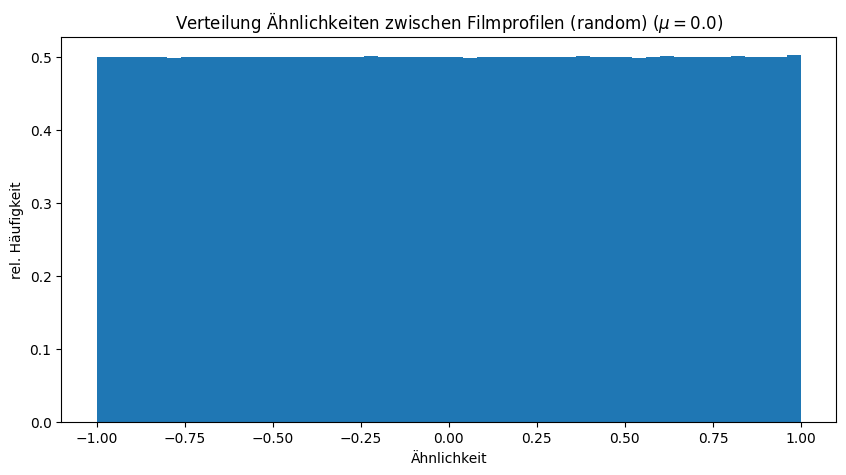

In [5]:
fig = plotSimiliarities(features, 'random')

In [6]:
features_file = 'data/movies_random.csv'
features.to_csv(features_file)

## Modellierung des Recommendersystems

Mit diesen zufälligen Werten erstellen wir nun ein Recommendersystem.

In [7]:
matrix = MatrixGenerator(random=True)

In [8]:
config = CakeConfig(
    {MatrixGenerator.CONST_KEY_RANDOM: np.array(1)},
    SimilarityEnum.COSINE,
    RatingScaleEnum.STANDARDISED,
    FeatureNormalizationEnum.ZSCORE
)

eval = Evaluation('Random', config, matrix)

cakeommender finished 🥳: 100%|██████████| 8/8 [00:08<00:00,  1.01s/it] 


In [9]:
mean_precision, std_precision = eval.precision()
topn_precision = eval.topNPrecision()
novelty = eval.novelty()

cakeommender finished 🥳: 100%|██████████| 8/8 [00:00<00:00, 22.56it/s] 


Die Precision liegt bei ca. 55 %, was etwa dem Verhältnis an guten Ratings im Testdatenset entspricht.

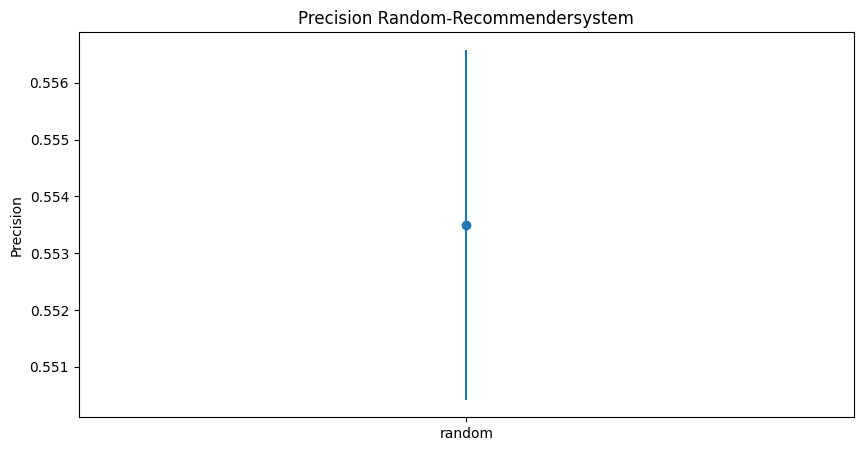

In [10]:
plt.figure(figsize = (10, 5))
plt.errorbar(['random'], mean_precision, yerr = std_precision, fmt ='o')
plt.title('Precision Random-Recommendersystem')
plt.ylabel('Precision')
plt.show()

In [11]:
print('Precision Top-10-Liste:', topn_precision)
print('Novelty Top-10-Liste:', novelty)

Precision Top-10-Liste: 0.5379664179104477
Novelty Top-10-Liste: 10.771580147913626


Für alle weiteren Recommender-Systeme sollten also bessere Precision-Werte erzielt werden können.

In [12]:
%reset -f

In [13]:
import os
if os.getcwd().endswith('modelling'):
    os.chdir('..')

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libraries.pipeconfig import (
    CakeConfig,
    FeatureNormalizationEnum,
    SimilarityEnum,
    RatingScaleEnum,
)

from libraries.matrix import MatrixGenerator
from libraries.weights import WeightGenerator
from cakeommender import Cakeommender
from evaluation import Evaluation

# Base Recommendersystem

In diesem Notebook wird das beste Recommendersystem gesucht ohne NLP-Ansätze.

Das Vorgehen wurde folgendermassen definiert:
- quantitativ die beste Kombination von Ähnlichkeitsmass und Ratingskala herausfinden.
- quantitativ mit der besten Kombination, die besten Feature-Normalisierung herausfinden.
- quantitativ die besten Gewichtungen der Daten herausfinden.
- qualitative überprüfung des Recommenders

## Kombination von Ähnlichkeitsmass und Ratingskala

In [15]:
matrixBase = MatrixGenerator(metadata = True,genres = True,actors = False,directors=False)

In [16]:
resultBase = pd.DataFrame({})
for similarities in [SimilarityEnum.COSINE,SimilarityEnum.PEARSON]:
    for ratingScale in RatingScaleEnum:
        config = CakeConfig(
            {MatrixGenerator.CONST_KEY_METADATA: np.array(1),
            MatrixGenerator.CONST_KEY_GENRES: np.array(1),
            MatrixGenerator.CONST_KEY_ACTORS: np.array(1),
            MatrixGenerator.CONST_KEY_DIRECTORS: np.array(1)},
            similarities,
            ratingScale,
            FeatureNormalizationEnum.ZSCORE
            )
        eval = Evaluation("BaseCake",config,matrixBase)
        precisionMean,precisionStd = eval.precision()
        novelty = eval.novelty()
        topNPrecision = eval.topNPrecision()
        resultBase = pd.concat((resultBase,pd.DataFrame({"RatingScale":[ratingScale.name],"Similarity":[similarities.name],"precisionMean":[precisionMean],"precisionStd":[precisionStd], "novelty": [novelty],"topNPrecision":[topNPrecision]})))

cakeommender finished 🥳: 100%|██████████| 8/8 [00:00<00:00, 19.66it/s] 


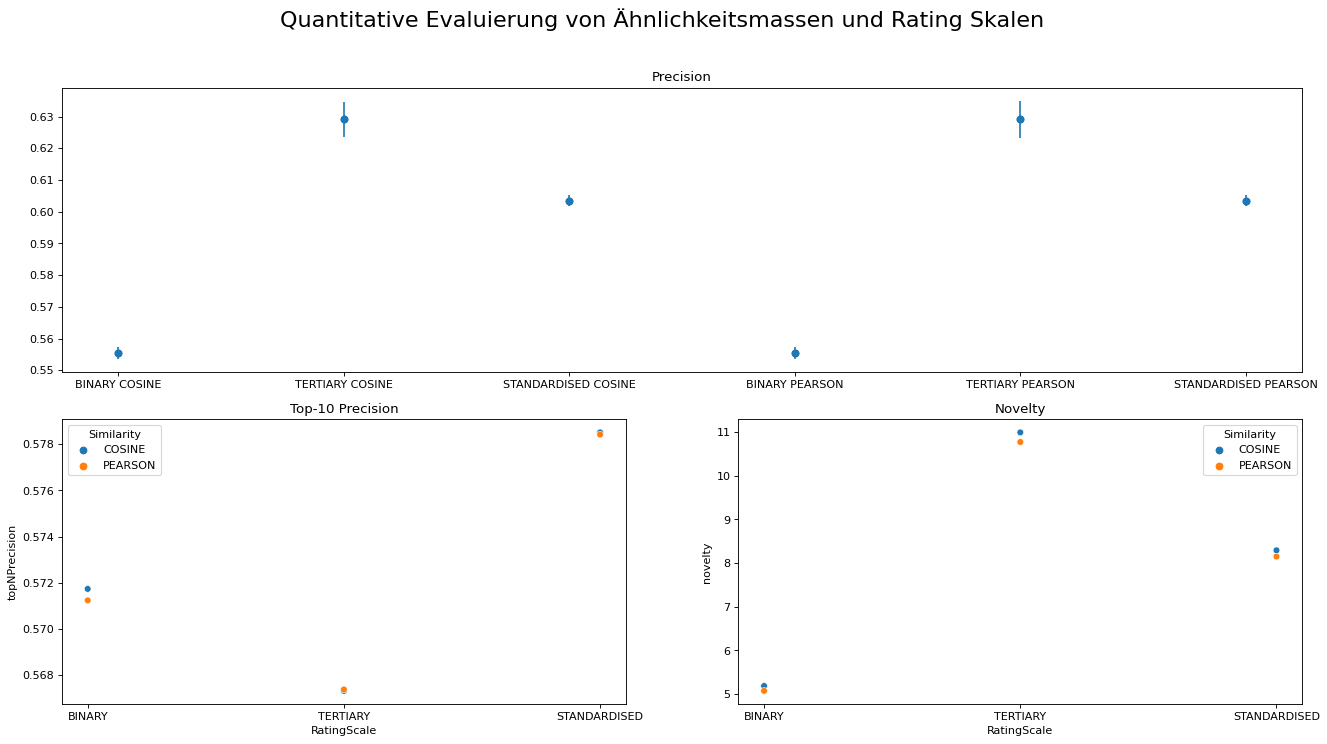

In [17]:
fig = plt.figure(figsize=(20,10),dpi = 80)
gs = fig.add_gridspec(4, 2, hspace= 0.4)


# subplot Precision
x = resultBase["RatingScale"] + " " + resultBase["Similarity"]
y = resultBase["precisionMean"]
y_error = resultBase["precisionStd"]

fig.suptitle("Quantitative Evaluierung von Ähnlichkeitsmassen und Rating Skalen",fontsize = 20)
precision = fig.add_subplot(gs[:2, :2])
precision.scatter(x, y)
precision.errorbar(x, y,
             yerr = y_error,
             fmt ='o')
precision.set_title("Precision")

# sublot TopN-Precision
topNPrecision = fig.add_subplot(gs[2:4, 0 ])
sns.scatterplot(x = 'RatingScale', y =  'topNPrecision',ax =topNPrecision, data=resultBase, hue='Similarity')
topNPrecision.set_title("Top-10 Precision")

# subplot Novelty
novelty = fig.add_subplot(gs[2:4, 1])
novelty.set_title("Novelty")
sns.scatterplot(x = 'RatingScale', y= 'novelty',ax = novelty, data=resultBase, hue='Similarity')
plt.show()

**Rating Skala:**

Die tertiäre Skala hat die beste Precision und Novelty. Sie hat aber die schlechteste Top-10 Precision.
Da bei der Top-10 Precision der Unterschied deutlich kleiner ist, werden wir für die weiteren Berechnungen die tertiäre Skala verwenden. Es ist erstaunlich, dass sie besser abschneidet als die detailliertere Standardisierung. Anscheinend ist diese genaue Einteilung nicht hilfreich und eine einfache Separation von gut, schlecht und nicht bewertet ist absolut ausreichend.

**Ähnlichkeitsmasse:**

Die beiden Ähnlichkeitsmasse erzielen fast die gleichen Resultate. Für die weiteren Berechnungen entscheiden wir uns für die Kosinusähnlichkeit, da sie eine minimal bessere Novelty hat.

## Beste Kombination mit optimaler Feature-Normalisierung

In [18]:
resultFeatures = pd.DataFrame({})
for featureNormalisation in FeatureNormalizationEnum:
    config = CakeConfig(
            {MatrixGenerator.CONST_KEY_METADATA: np.array(1),
            MatrixGenerator.CONST_KEY_GENRES: np.array(1),
            MatrixGenerator.CONST_KEY_ACTORS: np.array(1),
            MatrixGenerator.CONST_KEY_DIRECTORS: np.array(1)},
            SimilarityEnum.COSINE,
            RatingScaleEnum.TERTIARY,
            featureNormalisation
            )
    eval = Evaluation("BaseCake",config,matrixBase)
    precisionMean,precisionStd = eval.precision()
    novelty = eval.novelty()
    topNPrecision = eval.topNPrecision()
    resultFeatures= pd.concat((resultFeatures,pd.DataFrame({"FeatureNormalization":[featureNormalisation.name],"precisionMean":[precisionMean],"precisionStd":[precisionStd], "novelty": [novelty],"topNPrecision":[topNPrecision]})))

cakeommender finished 🥳: 100%|██████████| 8/8 [00:00<00:00, 18.41it/s] 


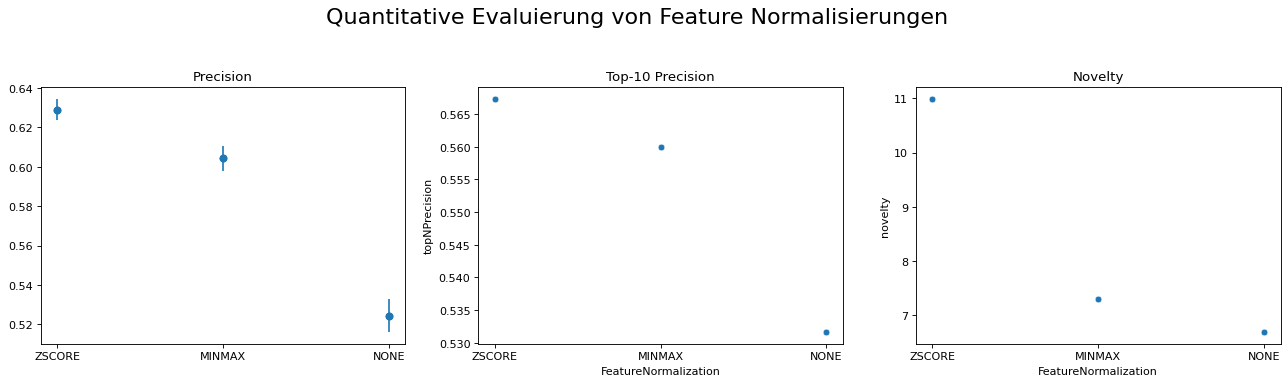

In [19]:
# subplot Precision
x = resultFeatures["FeatureNormalization"]
y = resultFeatures["precisionMean"]
y_error = resultFeatures["precisionStd"]

fig2 = plt.figure(figsize=(20,10),dpi = 80)
gs2 = fig2.add_gridspec(2, 3, hspace= 0.4)

fig2.suptitle("Quantitative Evaluierung von Feature Normalisierungen ",fontsize = 20)
precision = fig2.add_subplot(gs2[:1, 0])
precision.scatter(x, y)
precision.errorbar(x, y,
             yerr = y_error,
             fmt ='o')
precision.set_title("Precision")

# sublot TopN-Precision
topNPrecision = fig2.add_subplot(gs2[:1, 1])
sns.scatterplot(x = 'FeatureNormalization', y = 'topNPrecision',ax =topNPrecision, data=resultFeatures)
topNPrecision.set_title("Top-10 Precision")

# subplot Novelty
novelty = fig2.add_subplot(gs2[:1,2])
novelty.set_title("Novelty")
sns.scatterplot(x = 'FeatureNormalization', y = 'novelty',ax = novelty, data=resultFeatures)
plt.show()

**Feature Normalisierung:** Die Zscore Normalisierung erzielt die besten Resultate bei den Metriken Precision und Top-10 Precision. Die Novelty hingegen ist deutlich tiefer. Da die Precisions die wichtigeren Metriken sind, werden wir für die weiteren Berechnungen die ZScore Normalisierung verwenden.

## Besten Gewichtungen
### Quantitative Untersuchung

In [20]:
matrixBase = MatrixGenerator(metadata=True, genres=True, actors=True, directors=True)
resultFeaturesWeights = pd.DataFrame({})
weights = [[1,1,1,1],[0,1,1,1],[1,0,1,1],[1,1,0,1],[1,1,1,0],[1,1,0.4,0]]
for weight in weights:
    config = CakeConfig(
            {MatrixGenerator.CONST_KEY_METADATA: np.array(weight[0]),
            MatrixGenerator.CONST_KEY_GENRES: np.array(weight[1]),
            MatrixGenerator.CONST_KEY_ACTORS: np.array(weight[2]),
            MatrixGenerator.CONST_KEY_DIRECTORS: np.array(weight[3])},
            SimilarityEnum.COSINE,
            RatingScaleEnum.TERTIARY,
            FeatureNormalizationEnum.ZSCORE
            )
    eval = Evaluation("BaseCake",config,matrixBase)
    precisionMean,precisionStd = eval.precision()
    novelty = eval.novelty()
    topNPrecision = eval.topNPrecision()
    weight = "Metadaten: " + str(weight[0]*100) + "%\n" + "Genres: " + str(weight[1]*100) + "%\n" + "Actors: " +str(weight[2]*100) + "%\n" + "Directors: " + str(weight[3]*100) + "%"
    resultFeaturesWeights= pd.concat((resultFeaturesWeights,pd.DataFrame({"featureWeights":weight,"precisionMean":[precisionMean],"precisionStd":[precisionStd], "novelty": [novelty],"topNPrecision":[topNPrecision]})))

cakeommender finished 🥳: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s] 


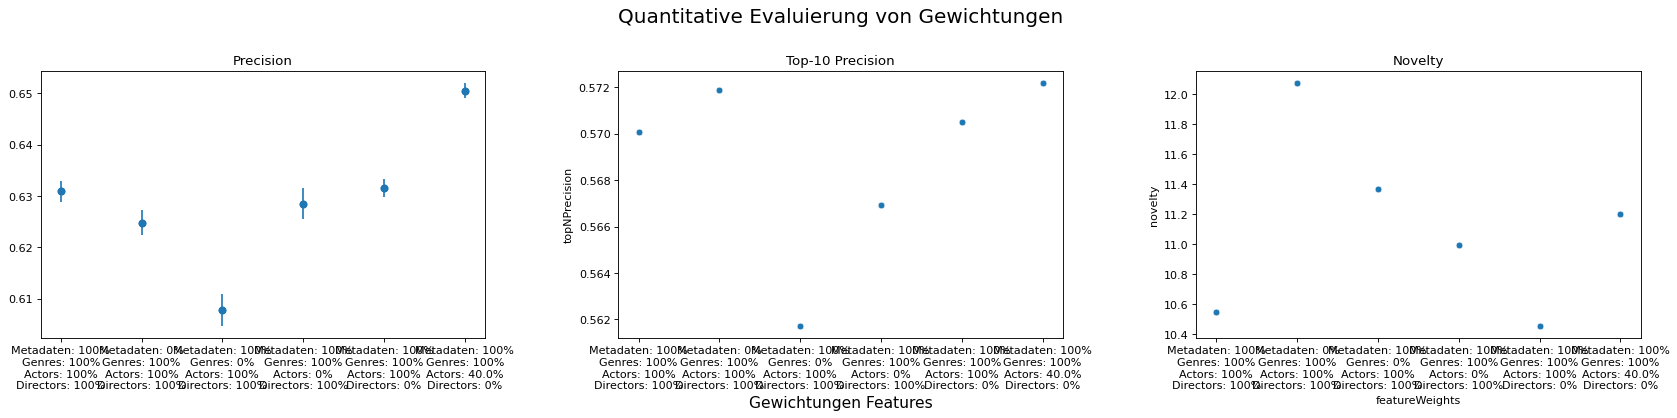

In [21]:
x = resultFeaturesWeights["featureWeights"]
y = resultFeaturesWeights["precisionMean"]
y_error = resultFeaturesWeights["precisionStd"]

fig2 = plt.figure(figsize=(20,10),dpi = 80)
gs2 = fig2.add_gridspec(2, 3, hspace= 0.4)

fig2.suptitle("Quantitative Evaluierung von Gewichtungen",fontsize = 18)
precision = fig2.add_subplot(gs2[:1, 0])
precision.scatter(x, y)
precision.errorbar(x, y,
             yerr = y_error,
             fmt ='o')
precision.set_title("Precision")
precision.set_xlabel(' ')

# sublot TopN-Precision
topNPrecision = fig2.add_subplot(gs2[:1, 1])
topNPrecision.set_xlabel('Gewichtungen Features', fontsize=14)
sns.scatterplot(x = 'featureWeights', y = 'topNPrecision',ax =topNPrecision, data=resultFeaturesWeights)
topNPrecision.set_title("Top-10 Precision")

# subplot Novelty
novelty = fig2.add_subplot(gs2[:1,2])
novelty.set_title("Novelty")
novelty.set_xlabel("")
sns.scatterplot(x = 'featureWeights', y = 'novelty',ax = novelty, data=resultFeaturesWeights)
plt.subplots_adjust(left=0,
                    bottom=0.1,
                    right=1,
                    top=0.9,
                    wspace=0.3,
                    hspace=0.4)

plt.show()

Die beste Precision kann folgender Gewichtung erreicht werden:
- 100 % Metadaten
- 100 % Genres
- 40 % Actors
- 0 % Directors

### Qualitative Untersuchung
#### Metadaten

cakeommender finished 🥳: 100%|██████████| 8/8 [00:02<00:00,  3.40it/s] 
/Users/josefweibel/Dropbox/Privat/Dokumente/FHNW/Data Science/cds1/cakeommender/cakeommender.py:304: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.numericFeatures, combuserProfile[np.newaxis, :]
/Users/josefweibel/Dropbox/Privat/Dokumente/FHNW/Data Science/cds1/cakeommender/cakeommender.py:326: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return topNMovieIds[:n]
/Users/josefweibel/Dropbox/Privat/Dokumente/FHNW/Data Science/cds1/cakeommender/cakeommender.py:304: FutureWarning: Support for multi-dimensional indexing (e.g. 

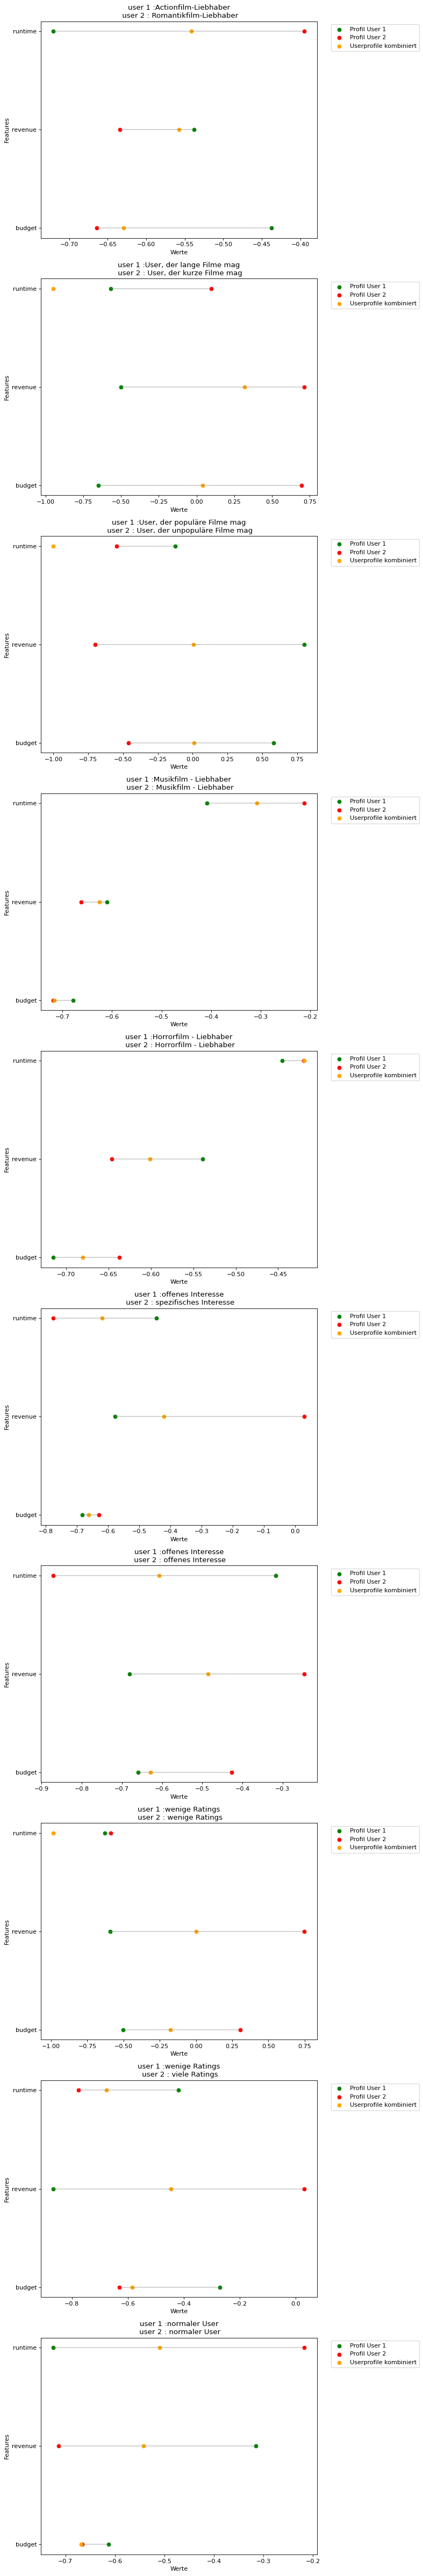

In [22]:
matrixBase = MatrixGenerator(metadata=True)
config = CakeConfig(
            {
            MatrixGenerator.CONST_KEY_METADATA: np.array(1),
            #MatrixGenerator.CONST_KEY_GENRES: np.array(1),
            #MatrixGenerator.CONST_KEY_ACTORS: np.array(1),
            #MatrixGenerator.CONST_KEY_DIRECTORS: np.array(1)
            },
            SimilarityEnum.COSINE,
            RatingScaleEnum.TERTIARY,
            FeatureNormalizationEnum.ZSCORE
            )
eval = Evaluation("BaseCake",config,matrixBase)

eval.iterCleveland()

*Lesebeispiel* für **user 1: normaler User** und **user 2: normaler User**: Das Budget der kombinierten Profile befinden sich beim Userprofil des User 2.

Qualitativ funktioniert der Recommender mit den Metadaten gut.
Die meisten Werte der kombinierten Filmprofile befinden sich zwischen den beiden User.
Dies sagt, aber noch nicht viel darüber aus, wie gut der Recommender tatsächlich ist.
Da es für einen Recommender, welcher genügend Filme zur Auswahl hat, simpel ist, ähnliche Filme vorherzusagen.

Um es mit zusätzlichen Feature zu testen, wird der Cleveland Plot mit den Genres gemacht.

#### Genres

cakeommender finished 🥳: 100%|██████████| 8/8 [00:02<00:00,  3.95it/s] 
/Users/josefweibel/Dropbox/Privat/Dokumente/FHNW/Data Science/cds1/cakeommender/cakeommender.py:304: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  self.numericFeatures, combuserProfile[np.newaxis, :]
/Users/josefweibel/Dropbox/Privat/Dokumente/FHNW/Data Science/cds1/cakeommender/cakeommender.py:326: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return topNMovieIds[:n]
/Users/josefweibel/Dropbox/Privat/Dokumente/FHNW/Data Science/cds1/cakeommender/cakeommender.py:304: FutureWarning: Support for multi-dimensional indexing (e.g. 

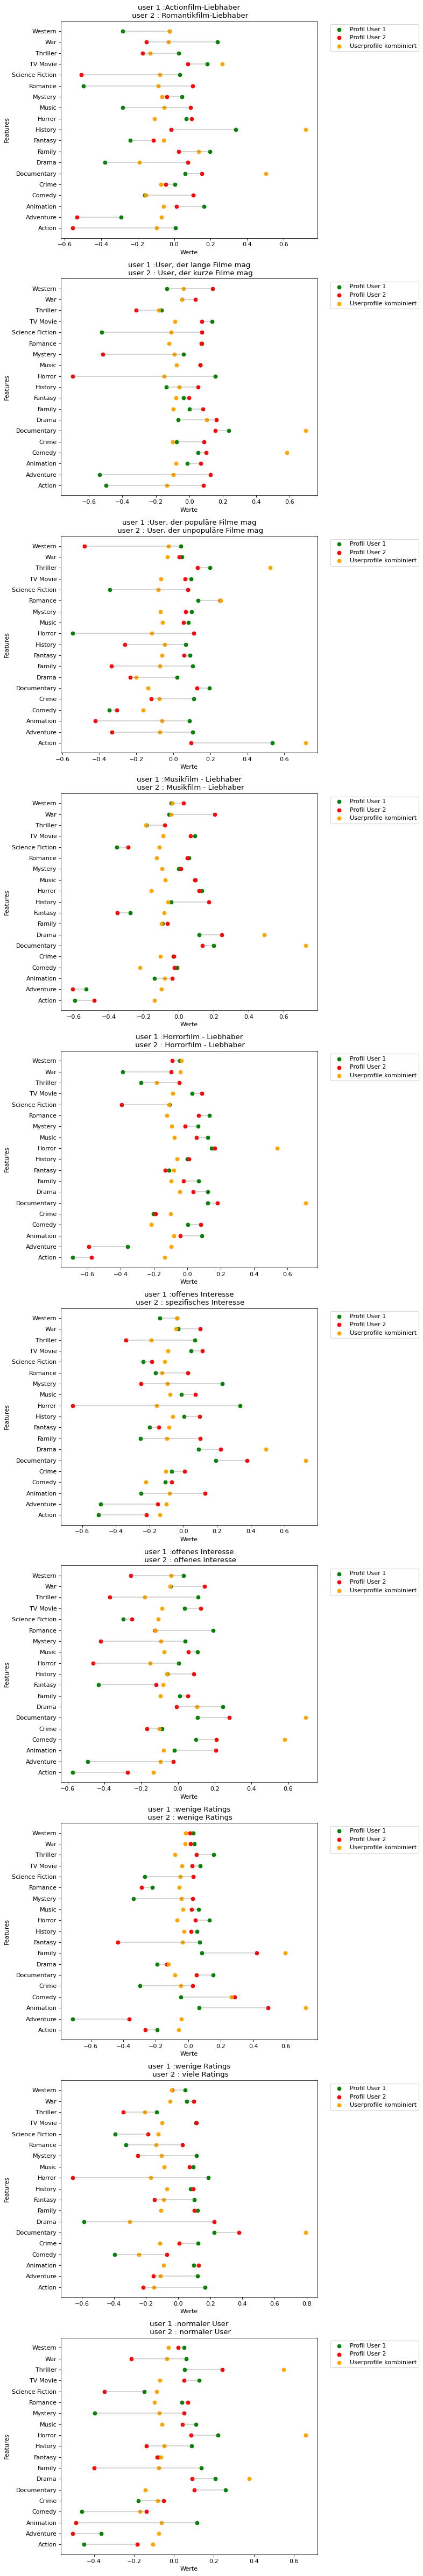

In [23]:
matrixBase = MatrixGenerator(genres=True)
config = CakeConfig(
            {
            #MatrixGenerator.CONST_KEY_METADATA: np.array(1),
            MatrixGenerator.CONST_KEY_GENRES: np.array(1),
            #MatrixGenerator.CONST_KEY_ACTORS: np.array(1),
            #MatrixGenerator.CONST_KEY_DIRECTORS: np.array(1)
            },
            SimilarityEnum.COSINE,
            RatingScaleEnum.TERTIARY,
            FeatureNormalizationEnum.ZSCORE
            )
eval = Evaluation("BaseCake",config,matrixBase)

eval.iterCleveland()

Das kombinierte Filmprofil, befindet sich nicht mehr immer, zwischen den beiden Userprofilen. Trotzdem zeigt die Visualisierung, dass der Recommender das kombinierte Profil richtig berechnet.

In [24]:
%reset -f

In [25]:
import os
if os.getcwd().endswith('modelling'):
    os.chdir('..')

In [26]:
import platform
os = platform.system()

if os == "Linux":
    isNotpdfGenerator = False
else:
    isNotpdfGenerator = True

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libraries.tfidf import tokenize
from libraries.pipeconfig import (
    CakeConfig,
    FeatureNormalizationEnum,
    SimilarityEnum,
    RatingScaleEnum,
)
from libraries.matrix import MatrixGenerator
from libraries.weights import WeightGenerator
from cakeommender import Cakeommender
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD,PCA
from evaluation import Evaluation

# Recommendersystem mit TFIDF-Tokens

Für unser erstes Recommendersystem auf Basis der Filmbeschreibungen verwenden wir TFIDF um diese in Tokens umzuwandeln. Diese Tokens verwenden wir anschliessend als Featurematrix für das Recommendersystem.

## Steckbrief

Bei TFIDF wird die Häufigkeit eines Wortes in einem Text bestimmt und diese in Relation zur Häufigkeit desselben Wortes in allen Texten gesetzt. So werden seltene Wörter stärker gewichtet als solche, die in jedem Text vorkommen. Die resultierende Featurematrix enthält dann pro Wort ein Attribut, dass dessen TFIDF-Score für den jeweiligen Text bestimmt.

Der Score wird über folgende Formel bestimmt, wobei $tf(x)$ die Anzahl Vorkomnisse des Wortes $x$ im Text $t$ definiert und $df(x)$ die Anzahl Texte angibt, in welchen das Wort $x$ vorkommt. $n$ definiert die gesamte Anzahl Texte.

$$tfidf(x, t) = tf(x, t) \cdot log(\frac{n}{df(x)})$$

Das Resultat beträgt 0, wenn das Wort nicht im Text vorkommt, oder wenn es in allen Texten vorkommt. Aufgrund des Logarithmus werden seltene Worte viel stärker gewichtet und so können auch ziemlich hohe TFIDF-Scores erzielt werden. Es gibt entsprechend keinen möglichen Maximalwert für diese Formel.

### Pre-Processing

Die Anzahl Features durch die TFIDF-Transformation ergibt sich grundsätzlich aus der Anzahl unterschiedlicher Worte in der gesamten Textsammlung. Dies kann zu einer riesigen Featurematrix führen, was eine weitere Verabeitung stark verlangsamen kann. Insbesondere wenn die Textsammlung viele Worte beinhaltet, die nur sehr selten vorkommen, kann dies die Matrix je nach Anwendungsfall unnötig aufblähen.

Um die Matrix klein zu halten, bietet es sich an gewisse Pre-Processing-Schritte vorzunehmen. Jedoch eignen sich nicht alle Möglichkeiten für alle Sprachen und Anwendungsfälle.

* **lowercase**: Durch das Kleinschreiben der Worte entstehen keine Token-Duplikate, wenn ein Wort innerhalb eines Satzes vorkommt und einmal am Satzanfang, wo der erste Buchstabe grossgeschrieben wird. In Englisch funktioniert dies gut, aber in Sprachen wie Deutsch, in welcher zum Beispiel Nomen grossgeschrieben werden, kann dies dazu führen, dass Wörter mit einer unterschiedlichen Bedeutung zum selben Token zusammengefasst werden.

* **lemmatisation**: Wenn alle Wörter zuerst in ihre Grundform gebracht werden, kann die Anzahl Tokens stark verringert werden. Insbesondere bei Sprachen wie Deutsch und Französisch, wo es sehr viele Verbformen gibt.

* **stopwords**: Wörter wie *and*, *for* und Artikel haben wenig Aussagekraft und es bietet sich häufig an, diese vor der Tokenisation aus den Texten zu entfernen. Welche Wörter als Stopwords infrage kommen, hängt stark vom Anwendungsfall ab.

Weiter kann die Featurematrix reduziert werden, indem sehr seltene Worte aus dieser entfernt werden. Diese verursachen häufig nur Noise und tragen nichts zur Erklärbarkeit der Daten bei. Auch wenig zur Erklärbarkeit tragen Wörter bei, die sehr häufig in den Texten vorkommen. Insbesondere, wenn sie in jedem einzelnen der Texte auftauchen. Solche Wörter können auch aus der Matrix entfernt werden.

### N-Gramm

Häufig sind Wortkombinationen aussagekräftiger als einzelne Worte. Insbesondere Adjektive können die Bedeutung eines Wortes verändern. So kann ein *movie* *good* oder *bad* sein. Wenn mehrere solche Adjektive im selben Text vorkommen, ist es relevant zu wissen, welches Nomen sie beschreiben. Um diesen Kontext in die Featurematrix aufnehmen zu können, lassen sich sogenannte n-Gramms bilden. $n$ definiert in diesem Fall die Anzahl aufeinanderfolgender Worte, die kombiniert werden sollen. Für jede Kombination wird ein neues Feature erstellt, wofür für jeden einzelnen Text auch wieder der TFIDF-Score berechnet wird. Der Parameter $n$ kann auch als Intervall beschrieben werden, so dass zum Beispiel auch Kombinationen aus einem bis drei Worten möglich sind. Es ist jedoch darauf zu achten, dass je länger eine Kombination ist, desto mehr Tokens wird die resultierende Matrix enthalten. Auch hier empfiehlt es sich, seltene Kombinationen wieder daraus zu entfernen.

### Dimensionsreduktion

Um diese grossen Featurematrizen in ihrer Dimension zu verkleinern, kann PCA verwendet werden. Dadurch werden neue Features gebildet, die die grössten Varianzen in den bestehenden Features abbilden. Es kann dadurch zwar nicht mehr von den neuen Features auf die ursprünglichen Features geschlossen werden, was im Fall von unserem Recommendersystem auch nicht mehr nötig ist.

## Aufteilen der Texte in Tokens

Um die Tokens zu erstellen, lesen wir die Metadaten zu den Filmen ein und entfernen Filme, die keinen Wert im Attribut `overview` enthalten.

In [28]:
meta = pd.read_csv('data/movies_meta.csv')

In [29]:
print('Anzahl Filme mit Wert NA in overview:', meta.overview.isna().sum())

Anzahl Filme mit Wert NA in overview: 0


In [30]:
meta = meta.dropna(subset='overview')
meta

movieId      budget                                 original_title  \
0        73268  20000000.0                                    Daybreakers   
1        73319  19000000.0                                      Leap Year   
2        73321  80000000.0                                The Book of Eli   
3        73929  26000000.0                                         Legion   
4        74115         NaN                          Dante's Hell Animated   
...        ...         ...                                            ...   
10823   193835         NaN  Lavell Crawford: Can a Brother Get Some Love?   
10824   193859         NaN                                You, Me and Him   
10825   193863         NaN                              Cocaine Godmother   
10826   193866         NaN                          Tales from the Hood 2   
10827   193882         NaN                                          Flora   

                                                overview release_date  \
0      In the year 2019, a plague has transformed alm...   2009-10-01   
1      When yet another anniversary passes without a ...   2010-01-08   
2      A post-apocalyptic tale, in which a lone man f...   2010-01-11   
3      When God loses faith in humankind, he sends hi...   2010-01-21   
4      Dante's Hell Animated is a real and truthful e...   2013-11-25   
...                                                  ...          ...   
10823  "Last Comic Standing" runner-up Lavell Crawfor...   2011-12-01   
10824  Despite their age difference, Lesbian couple O...   2018-02-01   
10825  At the age of 17, Griselda Blanco, made her wa...   2017-11-12   
10826  Mr. Simms returns to tell more eerie, unsettli...   2018-07-13   
10827  In 1929, an expedition of university botanists...   2017-04-27   

           revenue  runtime  tmdbId  
0       51417188.0     98.0   19901  
1       32686500.0    100.0   25195  
2      157107755.0    118.0   20504  
3       67918658.0    100.0   22894  
4              NaN     35.0   31156  
...            ...      ...     ...  
10823          NaN     90.0   71950  
10824          NaN     98.0  465026  
10825          NaN    100.0  492258  
10826          NaN    110.0  470614  
10827         88.0     99.0  454439  

[10828 rows x 8 columns]

Nun können mit unserer Library-Funktion `tokenize` aus `tfidf.py` die Texte aus dem Attribut `overview` in TFIDF-Tokens umgewandelt werden. Die Funktion verwendet die Library `scikit-learn` und gibt ein Dataframe mit den Tokens als Spalten und den Filmen als Zeilen zurück.

Um die Anzahl an Tokens zu reduzieren, werden wir vor dem Erstellen der Tokens die Texte alle in Kleinbuchstaben umwandeln. Der Nachteil ist, dass Wörter mit denselben Buchstaben, die aber mit einem Grossbuchstaben beginnen, in einigen Fällen eine andere Bedeutung haben, als Wörter mit nur Kleinbuchstaben. Dies ist aber eher ein Problem mit deutschen Texten und sollte relativ selten für englische vorkommen.

In [31]:
if isNotpdfGenerator:
    tokens = tokenize(meta, stopword=False, lowercase=True)
    print('Anzahl Terme:', tokens.shape[1])

Anzahl Terme: 30114


Die resultierende Featurematrix enthält Spalten für über 30'000 Terme. Dies sind ziemlich viele Dimensionen und die Berechnung der Ähnlichkeiten mit dieser würde einige Zeit beanspruchen. Wir wollen nun versuchen die Grösse zu reduzieren. Unser erster Versuch ist es, sogenannte Stopwords zu entfernen, also Wörter die eine sehr geringe bis gar keine Aussagekraft haben (zum Beispiel *the*, *and*, *or*).

In [32]:
if isNotpdfGenerator:
    tokens = tokenize(meta, stopword=True, lowercase=True)
    print('Anzahl Terme:', tokens.shape[1])

Anzahl Terme: 29821


Es scheint nicht allzu viele Stopwords gegeben zu haben. Wir konnten die Anzahl Terme um fast 300 reduzieren. Eine weitere Möglichkeit die Anzahl Terme zu reduzieren, ist es eine Mindestanzahl zu definieren. Terme die im gesamten Text seltener vorkommen als diese Anzahl, werden nicht in die Matrix übernommen.

In [33]:
if isNotpdfGenerator:
    results = []
    for n in range(1, 20):
        tokens = tokenize(meta, stopword=True, lowercase=True, minDf=n)
        results.append({'min': n, 'n': tokens.shape[1]})

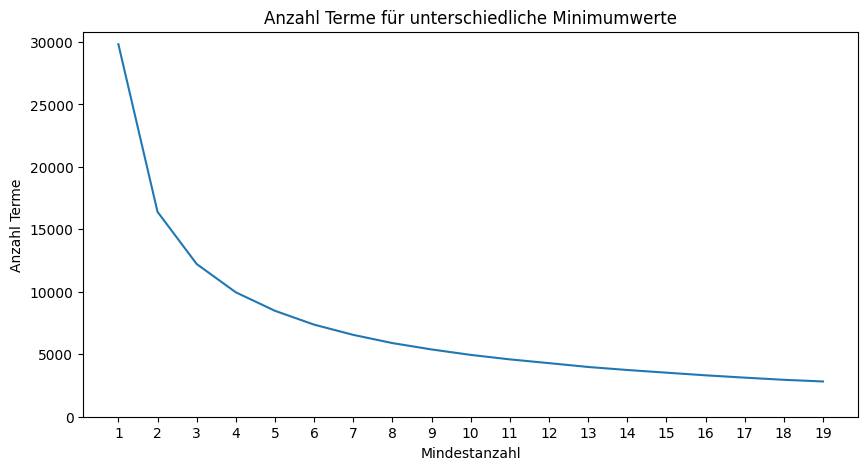

In [34]:
if isNotpdfGenerator:
    results = pd.DataFrame(results)

    plt.figure(figsize = (10, 5))
    plt.plot(results['min'], results['n'])
    plt.title('Anzahl Terme für unterschiedliche Minimumwerte')
    plt.xlabel('Mindestanzahl')
    plt.ylabel('Anzahl Terme')
    plt.xticks(results['min'])
    plt.ylim(0, results['n'].max() + 1000)
    plt.show()

Es zeigt sich, dass mit dem Steigen der Mindestanzahl die Anzahl Terme stark abnimmt. So sind bei mindestens 3 Vorkommnissen nur noch weniger als die Hälfte der Terme vorhanden als bei einer Mindestanzahl von 1. Bei der Einschränkung für mindestens 10 Vorkommnisse, bleiben noch weniger als 5000 Terme übrig.

Bei der Festlegung dieser Grenze gilt es abzuwägen zwischen dem Entfernen von seltenen und irrelevanten Worten und dem Behalten von seltenen, aber aussagekräftigen Begriffen. Genau letztere Attribute sind wichtig für das Recommendersystem, da sie ideal sind, um ähnliche Filem zu erkennen.

Da wir das Risiko klein behalten wollen, hilfreiche Wörter aus der Featurematrix zu enfernen, entscheiden wir uns eine Mindestanzahl von 3 zu verwenden. Die Grösse der Matrix wird dadurch dennoch signifikant verkleinert.

Wir wollen die Matrix weiter verkleinern, indem wir Tokens aus ihr entfernen, die sehr häufig vorkommen. Dazu verwenden wir den `CountVectorizer` von `scikit-learn`, auf welchen auch die TFIDF-Implementierung aufbaut, um die Verteilung der Worthäufigkeiten bestimmen zu können.

In [35]:
vectorizer = CountVectorizer(stop_words='english', lowercase=True, min_df=3)
word_counts = np.array(vectorizer.fit_transform(meta.overview).sum(axis = 0)).flatten()

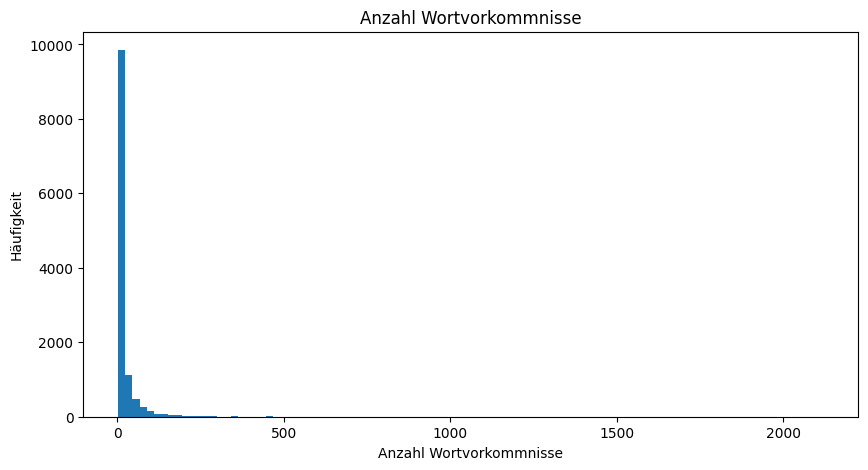

In [36]:
plt.figure(figsize = (10, 5))
plt.hist(word_counts, bins=100)
plt.title('Anzahl Wortvorkommnisse')
plt.xlabel('Anzahl Wortvorkommnisse')
plt.ylabel('Häufigkeit')
plt.show()

Es zeigt sich, dass die Verteilung stark rechtsschief ist und somit die allermeisten Wörter sehr selten vorkommen.

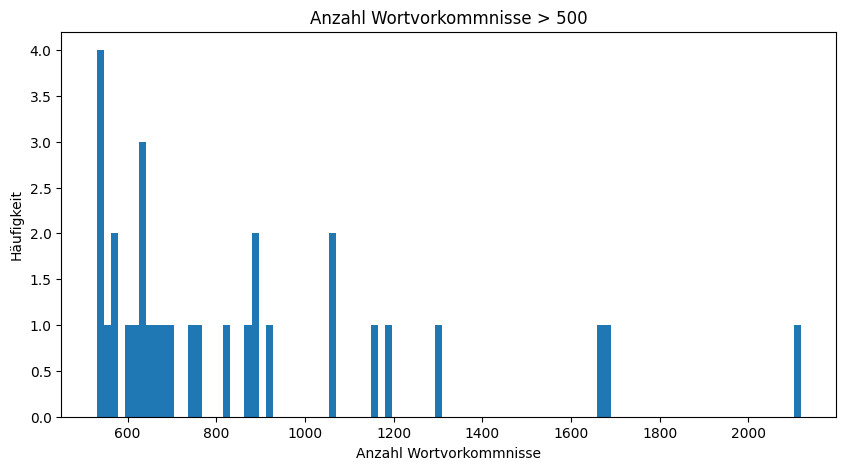

In [37]:
plt.figure(figsize = (10, 5))
plt.hist(word_counts[word_counts > 500], bins=100)
plt.title('Anzahl Wortvorkommnisse > 500')
plt.xlabel('Anzahl Wortvorkommnisse')
plt.ylabel('Häufigkeit')
plt.show()

Da die Häufigkeit von Wörtern, die mehr als 500 mal vorkommen, nicht erkennbar ist, erstellen wir einen weiteren Plot, in welchen nur diese angezeigt werden. Es scheint tatsächlich nur noch wenige solche Worte zu geben. Möglicherweise handelt es sich hier um Stopwords, die im Standardset von `scikit-learn` fehlen.

In [38]:
vectorizer.get_feature_names_out()[word_counts > 500]

array(['american', 'city', 'day', 'documentary', 'family', 'father',
       'film', 'finds', 'friends', 'group', 'high', 'home', 'life',
       'lives', 'love', 'man', 'mother', 'new', 'old', 'people', 'school',
       'story', 'takes', 'time', 'town', 'way', 'woman', 'world', 'year',
       'years', 'young'], dtype=object)

Wenn wir diese Tokens nun ausgeben, können wir erkennen, dass diese entgegen unserer Erwartung einen informativen Charakter haben. Wörter wie *american*, *documentary* und *school* können für unser Recommendersystem sehr interessant sein. Diese wollen wir behalten und legen deswegen keine Obergrenze bei der Worthäufigkeit fest. Eine Reduktion dadurch wäre aufgrund der vielen seltenen Wörter sowieso nur sehr gering ausgefallen.

In [39]:
if isNotpdfGenerator:
    tokens = tokenize(meta, stopword=True, lowercase=True, minDf=3)
    tokens.to_csv('data/movies_tfidf.csv')

Wir speichern die generierten Tokens nun in der Datei `data/movies_tfidf.csv` ab, so dass wir sie für die Recommendersysteme verwenden können.
Als nächstes mit diesen Tokens ein Recommender erstellt und Evaluiert.

In [40]:
#tokens = pd.read_csv('data/movies_tfidf_noDR.csv',index_col="movieId")

config = CakeConfig(
    {MatrixGenerator.CONST_KEY_TFIDF: np.array(1)},
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE,
)

In [41]:
resultTFIDF = []

# Init Recommender
matrixTfidf = MatrixGenerator(tfidfTokens='data/movies_tfidf.csv')
baseCakeommenderCosine = Cakeommender(
    "TFIDFCakeommender",
    config,
    matrixTfidf,
    verbose=True
)

cakeommender finished 🥳: 100%|██████████| 8/8 [00:51<00:00,  6.43s/it] 


In [42]:
eval = Evaluation("TFCake",config,matrixTfidf)
precision = eval.precision()
topNPrecision = eval.topNPrecision()
novelty = eval.novelty()
resultTFIDF.append({
    "n_grams": "keine",
    "Singulärwerte": 0,
    "precisionMean": precision[0],
    "precisionStd": precision[1],
    "novelty": novelty,
    "topNPrecision": topNPrecision
})

cakeommender finished 🥳: 100%|██████████| 8/8 [00:13<00:00,  1.72s/it] 


Als nächstes wird versucht die Matrix zu komprimieren, um bessere Resultate zu erzielen.
Darum werden Recommender mit unterschiedlicher Anzahl von Singulärwerten verwendet.

In [43]:
def cakeWithSvd(token: pd.DataFrame, singularvalues: int)-> tuple():
    """
    Jan
    Evaluation for TF-IDF models with a SVD komprimation.

    :param pd.DataFrame token: TF-IDF Tokens
    :param int singularvalues: TF-IDF Tokens
    :return : Precisions of 5 folds, standartdeviation, novelty and Top-10 Precision
    :rtype : tuple()
    """
    filename = f'data/movies_tfidf_{singularvalues}d.csv'

    svd = TruncatedSVD(n_components=singularvalues)
    reduced_tokens = svd.fit_transform(token)
    reduced_tokens = pd.DataFrame(reduced_tokens, index=token.index)
    reduced_tokens.to_csv(filename)

    config = CakeConfig(
        {MatrixGenerator.CONST_KEY_TFIDF: np.array(1)},
        SimilarityEnum.COSINE,
        RatingScaleEnum.TERTIARY,
        FeatureNormalizationEnum.ZSCORE,
    )

    matrixTfidf = MatrixGenerator(tfidfTokens=filename)
    eval = Evaluation(f"TFCake_{filename}d", config, matrixTfidf)

    precision = eval.precision()
    novelty = eval.novelty()
    topNPrecision = eval.topNPrecision()
    return precision, novelty, topNPrecision

In [44]:
for singularValues in [10, 100, 1000]:
    precision, novelty, topNPrecision = cakeWithSvd(tokens, singularValues)
    resultTFIDF.append({
        "n_grams": "keine",
        "Singulärwerte": singularValues,
        "precisionMean": precision[0],
        "precisionStd": precision[1],
        "novelty": novelty,
        "topNPrecision": topNPrecision
    })

cakeommender finished 🥳: 100%|██████████| 8/8 [00:00<00:00,  9.21it/s] 


Das Komprimieren verschlechtert das Resultat. Dafür dauert es weniger lange. Als weiteres werden n-grams untersucht

In [45]:
filename = 'data/movies_tfidf_1-4grams.csv'
if isNotpdfGenerator:
    tokens = tokenize(meta, stopword=True, lowercase=True, minDf=3, ngramRange = (1,4))
    tokens.to_csv(filename)

In [46]:
config = CakeConfig(
    {MatrixGenerator.CONST_KEY_TFIDF: np.array(1)},
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE,
)
matrixTfidf = MatrixGenerator(tfidfTokens=filename)
eval = Evaluation("TFCake_1-4grams", config, matrixTfidf)

cakeommender finished 🥳: 100%|██████████| 8/8 [02:23<00:00, 17.91s/it] 


In [47]:
precision = eval.precision()
novelty = eval.novelty()
topNPrecision = eval.topNPrecision()
resultTFIDF.append({
    "n_grams": "(1-4)",
    "Singulärwerte": 0,
    "precisionMean": precision[0],
    "precisionStd": precision[1],
    "novelty": novelty,
    "topNPrecision": topNPrecision
})

cakeommender finished 🥳: 100%|██████████| 8/8 [00:21<00:00,  2.64s/it] 


Mit den n-grams konnte kein besseres Resultat erzielt werden. Da zusätzliche Tokens dazugekommen ist, werden die Tokens komprimiert.

In [48]:
precision, novelty, topNPrecision  = cakeWithSvd(tokens, 6000)
resultTFIDF.append({
    "n_grams": "(1-4)",
    "Singulärwerte": 6000,
    "precisionMean": precision[0],
    "precisionStd": precision[1],
    "novelty": novelty,
    "topNPrecision": topNPrecision
})

cakeommender finished 🥳: 100%|██████████| 8/8 [00:03<00:00,  2.02it/s] 


Mit der Komprimierung konnte kein besseres Resultat erziehlt werden. Die besten Tokens werden exportiert.
Das beste TF-IDF Modell ist nicht besser wie das Baseline Modell.

/Users/josefweibel/.local/share/virtualenvs/cakeommender-is01-PZN/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/josefweibel/.local/share/virtualenvs/cakeommender-is01-PZN/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: title={'center': 'Novelty'}, xlabel='Singulärwerte', ylabel='novelty'>

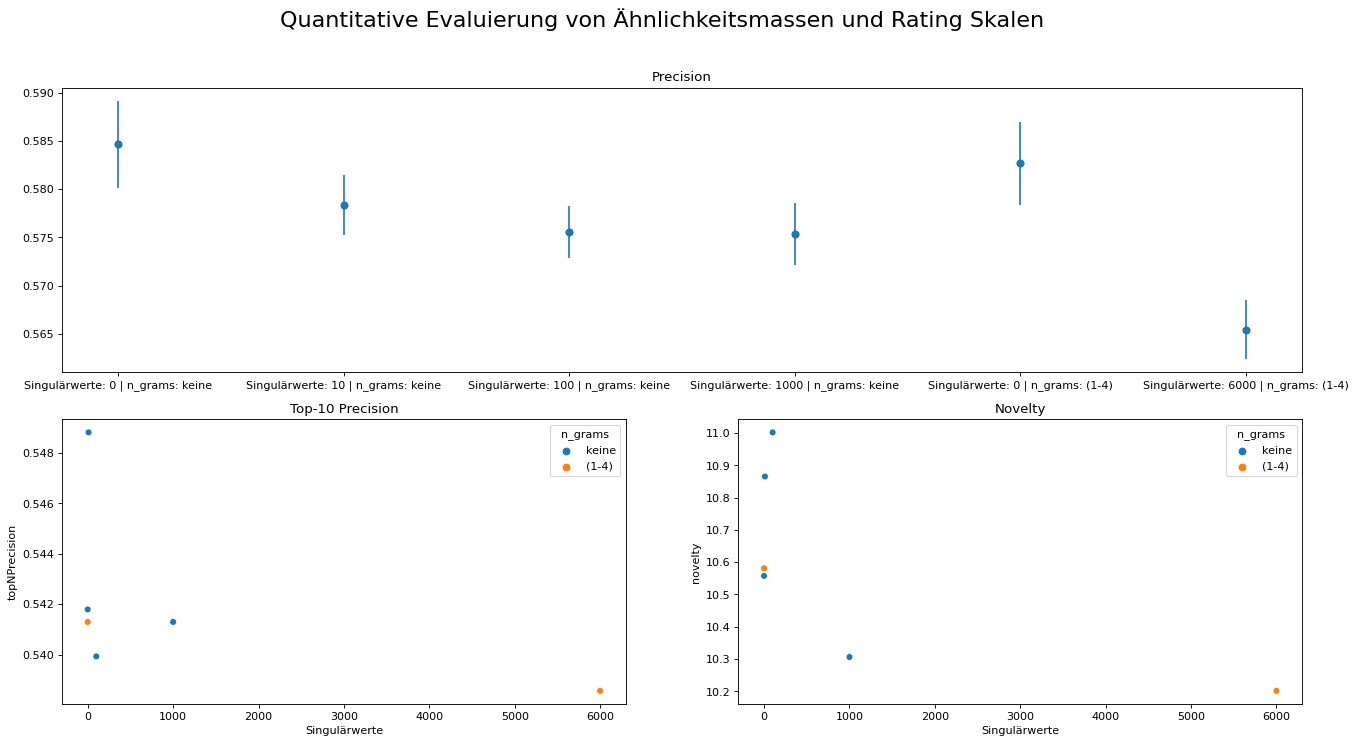

In [49]:
resultTFIDF = pd.DataFrame(resultTFIDF)

fig = plt.figure(figsize=(20,10),dpi = 80)
gs = fig.add_gridspec(4, 2, hspace= 0.4)
# subplot Precision
x = "Singulärwerte: " + resultTFIDF["Singulärwerte"].astype(str) + " | n_grams: " + resultTFIDF["n_grams"]
y = resultTFIDF["precisionMean"]
y_error = resultTFIDF["precisionStd"]

fig.suptitle("Quantitative Evaluierung von Ähnlichkeitsmassen und Rating Skalen",fontsize = 20)
precision = fig.add_subplot(gs[:2, :2])
precision.scatter(x, y)
precision.errorbar(x, y,
             yerr = y_error,
             fmt ='o')
precision.set_title("Precision")
# sublot TopN-Precision
topNPrecision = fig.add_subplot(gs[2:4, 0 ])
sns.scatterplot('Singulärwerte', 'topNPrecision',ax =topNPrecision, data = resultTFIDF, hue='n_grams')
topNPrecision.set_title("Top-10 Precision")

# subplot Novelty
novelty = fig.add_subplot(gs[2:4, 1])
novelty.set_title("Novelty")
sns.scatterplot('Singulärwerte', 'novelty',ax = novelty, data = resultTFIDF, hue='n_grams')

In [50]:
%reset -f

In [51]:
import os
if os.getcwd().endswith('modelling'):
    os.chdir('..')

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from libraries.bert import Bertomat, BertEnum
from libraries.pipeconfig import (
    CakeConfig,
    FeatureNormalizationEnum,
    SimilarityEnum,
    RatingScaleEnum,
)
from libraries.matrix import MatrixGenerator
from cakeommender import Cakeommender
from evaluation import Evaluation, plot_results
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
from umap import UMAP
from scipy.stats import pearsonr
from libraries.feature_evaluation import plotSimiliarities, plotHDBSCANProbabilities, plotHDBSCANClustersAlongGenres, plotUMAPEmbeddingsAlongGenres, plotCumulativePCAVariance

# Recommendersystem mit BERT Sentence Embeddings

Bei diesen Recommendersystemen wollen wir Sentence Embeddings von BERT als Featurematrix verwenden. Wir wandeln dazu den Text `overview` in Tokens um und generieren daraus die Embeddings mit einem vortrainierten BERT-Modell.

## Steckbrief

BERT (Bidirectional Encoder Representations from Transformers) ist eine Transformers-Modellarchitektur, die für unterschiedlichste NLP-Tasks eingesetzt werden kann. Ein solches Modell generiert für einen beliebigen Text sogenannte Embeddings, die dann weiterverarbeitet werden können. Der Vorteil an diesen ist, dass sie nicht mehr direkt Wörtern entsprechen, sondern auch den Kontext miteinbeziehen. Anhand der Embeddings kann beispielsweise unterschieden werden, worum es sich beim Wort "Bank" handelt. So können damit Modelle für die Sentiment Analysis, Text Prediction, Text Generation und andere NLP-Aufgaben trainiert werden.

Um diese Embeddings generieren zu können, muss dieser zuerst in Tokens aufgeteilt werden. Dabei resultiert aus jedem Wort ungefähr ein Token. Einzelne Worte werden jedoch in mehrere aufgeteilt, wenn sie nicht Bestandteil des Vokabular sind, das zum Trainieren verwendet wurde. Das BERT-Vokabular umfasst ca. 30'000 Wörter und Subwörter. Die Tokens werden als Zahlen dargestellt, die IDs zu den jeweiligen textlichen Teilen darstellen. Diese Zahlen stellen aber keine Reihenfolge dar und sind als kategorische Features zu betrachten.

Die Tokenliste muss jedoch immer mit dem Token *[CLS]* beginnen und mit *[SEP]* enden, da BERT damit trainiert wurde. Letzteres Token wird verwendet, um einzelne Sätze (bzw. längere Texte) voneinander zu trennen, da beim Training jeweils zwei Sätze zusammen als ein Sample verwendet wurden. Um aus den Tokens die Embeddings zu generieren, können diese als Inputs ins BERT-Modell gegeben werden, worauf dieses die Embeddings als Output liefert. Dabei reicht es, wenn der Satz bzw. kurze Text mit *[CLS]* beginnt und ein einzelnes *[SEP]* am Ende hat. Die resultierende Matrix enthält pro Token die passenden Embeddings. Um aus diesen die Sentence-Embeddings zu erhalten, können entweder die Embeddings des *[CLS]*-Tokens verwendet werden. Diese Abkürzung steht für *Classification* und fasst den Inhalt des Satzes zusammen. Eine andere Strategie nennt sich Average-Pooling, bei der der Mittelwert aller Word-Embeddings berechnet wird. Diese Sentence-Embeddings sollen den Inhalt des gesamten Texts repräsentieren. Jedes Embedding besteht aus 768 Werten, die aber nicht weiter interpretiert werden können. Diese können als Input für weitere Modelle dienen oder in unserem Fall für die Featurematrix verwendet werden.

Zu beachten ist, dass die maximale Anzahl Tokens bei 512 liegt. Längere Texte können nicht verarbeitet, beziehungsweise müssen gekürzt werden.

### Vortrainierte Modelle

Für BERT sind zwei Architekturen vorgesehen. Einmal eine einfachere, die für die meisten Anwendungen ausreicht und eine tiefere, die sogar die Fähigkeiten von Menschen bei einigen Aufgaben übertrifft. Für diese beiden Architekturen gibt es einige vortrainierte Modelle. Es empfiehlt sich diese zu verwenden, da das Training der 110 Millionen bzw. 340 Millionen Parameter einige Tage Zeit auf einem Hochleistungscomputer beansprucht. Die Basismodelle wurden mit Daten von Wikipedia und der Google Büchersammlung trainiert. Weiter gibt es spezifische Modelle für einige Sprachen. Diese vortrainierten Modelle können direkt genutzt werden, um Embeddings zu generieren oder sie können bei einem Supervised-Learning-Problem noch verbessert werden, indem sie mit eigenen Textdaten weiter trainiert werden (Transfer Learning).

Ursprünglich wurden die Modelle auf zwei Self-Supervised-Learning-Arten trainiert. Einerseits wurden bei Sätzen einzelne Wörter maskiert, die das Modell vorhersagen musste (masked language modelling). Andererseits wurden jeweils zwei Sätze aneinandergefügt, die entweder auch im ursprünglichen Text direkt aufeinanderfolgten oder nicht, und das Modell hatte die Aufgabe diese Unterscheidung zu lernen (next sentence prediction).

Für BERT gibt es einige Abwandlungen, die für spezifische Anwendungsfälle besser funktionieren sollten. So gibt es DistillBERT, dass 60 % schneller als das herkömmliche Modell sein soll, aber dennoch etwa 95 % der Qualität behalten soll. So kann das Modell auch auf weniger leistungsstarken Geräten verwendet werden.

### Transformers

Für NLP wurde bis vor einigen Jahren Modelle wie LSTM oder RNN eingesetzt, die aber insbesondere bei langen Texten zu Problemen führten. Bei letztgenannten gingen zum Beispiel vor allem Inhalte am Anfang des Textes verloren.

2017 wurde dann die Attention-Transformers-Architektur vorgestellt, die schon bald Anwendung im Bereich NLP fand. Diese Modelle versuchen Wichtiges zu fokussieren. Im Fall von BERT sind dies einzelne Wörter beziehungsweise Tokens. Ein weiterer Vorteil ist, dass sie durch Parallelisierung Resultate für viel Input in viel kürzerer Zeit als die vorher genannten Architekturen liefern können.

Transformer-Modelle bestehen dabei eigentlich aus einem Encoder und einem Decoder. Ersterer maskiert, für NLP, Texte in Embeddings um. Der Decoder wandelt diese wieder in Texte oder ein anderes Output-Format um. BERT stellt jedoch nur den Encoder-Teil zur Verfügung. Die BERT-Architektur sieht im einfacheren Modell 12 Transformer-Layer und im komplexeren doppelt so viele vor.

### Referenzen

- Alammar, J. (o. J.). A Visual Guide to Using BERT for the First Time. Abgerufen 15. November 2022, von https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/
- Devlin, J., Chang, M.-W., Lee, K., & Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding (arXiv:1810.04805). arXiv. https://doi.org/10.48550/arXiv.1810.04805
- Hugging Face. (o. J.-a). BERT API. Abgerufen 15. November 2022, von https://huggingface.co/docs/transformers/main/en/model_doc/bert
- Hugging Face. (o. J.-b). Bert-base-uncased. Abgerufen 15. November 2022, von https://huggingface.co/bert-base-uncased
- Muller, B. (2022, März 2). BERT 101—State Of The Art NLP Model Explained. https://huggingface.co/blog/bert-101
- Winastwan, R. (2021, November 10). Text Classification with BERT in PyTorch. Medium. https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

## Berechnen der Sentence Embeddings

Zuerst müssen die Metadaten aus der CSV-Datei eingelesen werden und Filme ohne Text im Attribut `overview` entfernt werden. Für diese können wir keine Embeddings generieren und sind deshalb für unser Recommendersystem uninteressant.

In [53]:
meta = pd.read_csv('data/movies_meta.csv')

Glücklicherweise betrifft dies lediglich zehn Filme, die wir im nächsten Schritt aus unserem Dataframe entfernen.

In [54]:
print('Anzahl Filme mit Wert NA in overview:', meta.overview.isna().sum())
meta = meta.dropna(subset = 'overview')
meta.shape

Anzahl Filme mit Wert NA in overview: 0


(10828, 8)

Nun verwenden wir unsere Library-Funktion `generateEmbeddings` um die Sentence-Embeddings zu berechnen. Diese verwendet den BERT-Tokenizer und das BERT-Modell `bert-base-uncased` aus dem Package `transformers` von [HuggingFace](https://huggingface.co/bert-base-uncased). Als Sentence-Embeddings verwenden wir die Word-Embeddings für das *[CLS]*-Token. Wir erhalten ein Dataframe zurück mit den Sentence-Embeddings pro Film, die jeweils aus 786 Elementen bestehen.

In [55]:
n = 10

In [56]:
embeddings_file_cls = 'data/movies_bert_cls.csv'
sentence_embeddings = pd.read_csv(embeddings_file_cls, index_col='movieId')
# sentence_embeddings = Bertomat(BertEnum.BERT).generateEmbeddings(meta[0:n])
sentence_embeddings.shape

(10655, 768)

## Evaluierung Sentence Embeddings

Embeddings bestehen aus kontinuierlichen Werten, die sich nicht direkt interpretieren lassen. Wir wollen nun trotzdem versuchen in diesen Werten Muster zu finden. Insbesondere möchten wir diese den Genres gegenüberstellen und untersuchen, ob sich von den Embeddings auf die Genres schliessen lässt.

Aus diesem Grund lesen wir nun die Genres-Matrix ein und stellen sicher, dass beide Dataframes dieselben Filme enthalten.

In [57]:
genres = pd.read_csv('data/movies_genres.csv', index_col='movieId')
movieIds = genres.index.intersection(sentence_embeddings.index)
sentence_embeddings = sentence_embeddings.loc[movieIds].sort_index()
genres = genres.loc[movieIds].sort_index()
genres.shape

(10655, 19)

Die Sentence-Embeddings stellen die Fimprofile dar, aus denen später in den Recommendersystemen Nutzerprofile durch Linearkombinationen gebaut werden. Diese werden dann mit der Cosine-Ähnlichkeit verglichen. Wir wollen deswegen untersuchen, wie ähnlich diese Filmprofile untereinander sind, um eine erste Einschätzung der Qualität der Recommendersysteme mit diesen Daten zu erhalten.

Minimum Ähnlichkeit: 0.2648589862253822
Maximum Ähnlichkeit: 1.0


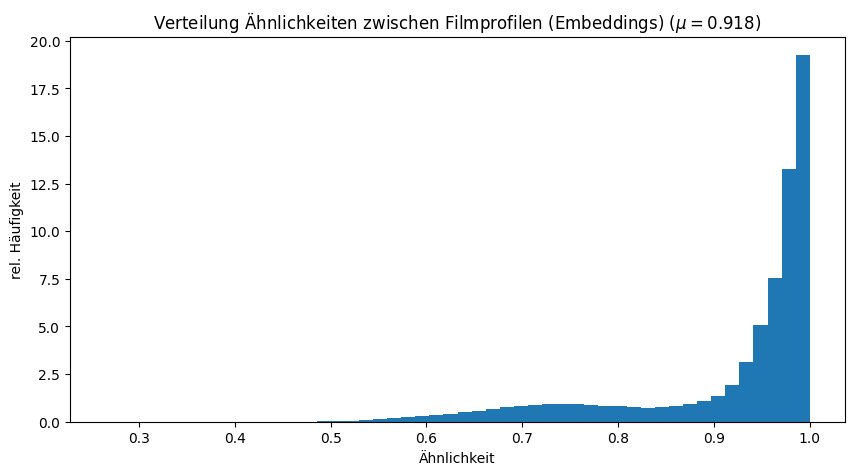

In [58]:
fig, embeddings_sim = plotSimiliarities(sentence_embeddings, 'Embeddings', return_sim=True)

Es zeigt sich, dass es sehr viele ähnliche Filme gibt, denn der Grossteil der Ähnlichkeiten ist grösser als 0.9. Auch der Mittelwert liegt darüber und ist somit sehr hoch. Deswegen müssen wir später bei der Evaluierung der Recommendersysteme einen guten Grenzwert wählen, ab welcher Ähnlichkeit ein Film als gut gilt. Es können also ähnliche Filme gefunden werden, was eine wichtige Voraussetzung für die Systeme ist.

Zum Vergleich untersuchen wir die Ähnlichkeiten, wenn die Filmprofile nur aus den Genreszuweisungen bestehen würden. Wir sehen, dass es zwischen einem grossen Mehrheit der Filme keine Ähnlichkeit gibt. Da Filme mehreren Genres zugewiesen sein können, ergeben sich nicht nur die Extreme 0 und 1, sondern auch Ähnlichkeitswerte dazwischen. Der Mittelwert ist entsprechend auch viel geringer als für die Ähnlichkeitswerte der Embeddings.

Minimum Ähnlichkeit: 0.0
Maximum Ähnlichkeit: 1.0


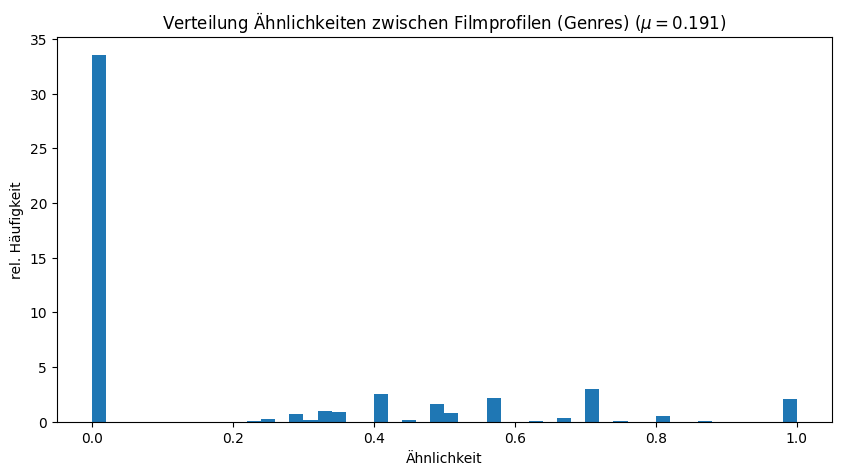

In [59]:
fig, genres_sim = plotSimiliarities(genres, 'Genres', return_sim=True)

Es gibt auch keinen linearen Zusammenhang zwischen diesen beiden Ähnlichkeiten, was der sehr kleine Korrelationskoeffizient zeigt.

In [60]:
pearsonr(embeddings_sim.flatten(), genres_sim.flatten())

PearsonRResult(statistic=0.02593665976121943, pvalue=0.0)

Um weiter zu prüfen, ob es einen Zusammenhang zwischen den Embeddings und den Genres gibt, wollen wir Supervised-Learning-Modelle trainieren, die aus ersterem letzeres vorhersagen können. Dabei sollen high-bias Modellarten eingesetzt werden, da diese ansonsten bei so vielen Features die Daten auch auswendig lernen könnten. Als erstes Modell setzen wir Naive-Bayes ein.

In [61]:
nn_embeddings = sentence_embeddings - sentence_embeddings.to_numpy().min()
nb_model = MultiOutputClassifier(MultinomialNB(), n_jobs=-1)
nb_model.fit(nn_embeddings, genres)
print('Mean Accuracy:', nb_model.score(nn_embeddings, genres))

Mean Accuracy: 0.028625058657907085


Dieses Modell schneidet ziemlich schlecht ab und kann gerade mal weniger als 3 % der Filmgenres korrekt klassifizieren. Eine weitere Variante sind Support Vector Machines, die sich aber mit 768 Dimensionen nicht in vernünftiger Zeit trainieren lassen. Aus diesem Grund wollen wir eine Dimensionsreduktion mittels PCA vornehmen, aber möglichst viel Information in den Filmprofilen behalten.

In [62]:
pca = PCA().fit(sentence_embeddings)

Die ersten Komponenten decken einen Grossteil der Varianz in den Daten ab. Mit 85 von 768 Komponenten decken wir bereits 95 % des Informationsgehalts ab.

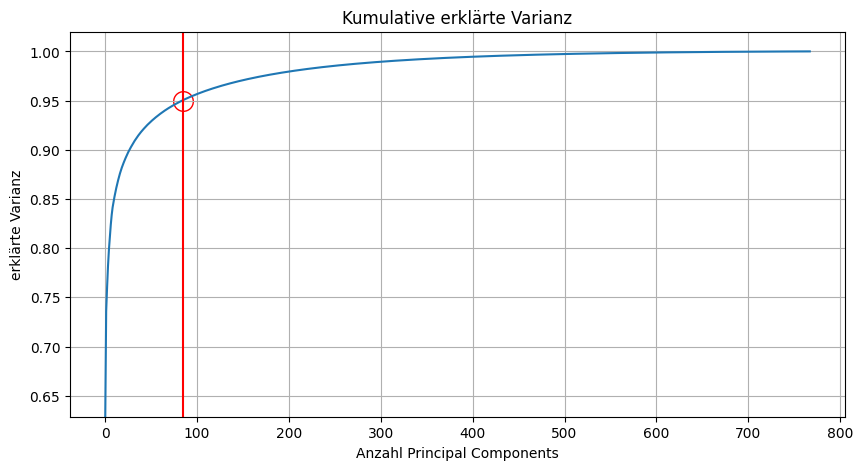

In [63]:
fig, n_components_bert = plotCumulativePCAVariance(pca)

Wir reduzieren nun die 768 Embeddingfeatures auf 85 und behalten so 95 % der Informationen.

In [64]:
pca = PCA(n_components=n_components_bert)
reduced_embeddings = pca.fit_transform(sentence_embeddings)
reduced_embeddings.shape

(10655, 85)

Mit diesem kleineren Datenset können wir nun einen SVM-Classifier trainieren. Mit linearen Decision Boundaries können wir die Accuracy signifikant steigern, sie ist aber dennoch zu wenig gut als das wir von einem guten Modell sprechen könnten.

In [65]:
svc_model = MultiOutputClassifier(SVC(kernel='linear'), n_jobs=-1)
svc_model.fit(reduced_embeddings, genres)
print('Mean Accuracy:', svc_model.score(reduced_embeddings, genres))

Mean Accuracy: 0.14659784138901924


Ein linearer Kernel ist jedoch sehr unflexibel und es ist sehr wahrscheinlich, dass keine lineare Grenzen im PCA-Embeddings-Raum gezogen werden können. Wir ersetzen den linearen Kernel aus diesem Grund durch den flexibleren RBF-Kernel. Mit der Standardparameterisierung und einer hohen Regularisierungsstärke lässt sich kein deutlich besseres Modell trainieren. Durch Anpassung der Parametierisierung und dem Schwächen der Regularisierung, könnte das Modell zwar deutlich verbessert werden. Es wäre aufgrund der low-variance des RBF-Kernels sogar möglich ein Modell zu trainieren, dass nahezu perfekt die Genres bestimmen könnte. Dies wäre jedoch für unsere Auswertung nicht zielführend, da wir prüfen wollen, ob die Embeddings einfach auf die Genres abgebildet werden können.

In [66]:
svc_model = MultiOutputClassifier(SVC(kernel='rbf'), n_jobs=-1)
svc_model.fit(reduced_embeddings, genres)
print('Mean Accuracy:', svc_model.score(reduced_embeddings, genres))

Mean Accuracy: 0.15466916940403566


Als erstes Zwischenfazit können wir nun sagen, dass die Embeddings andere Informationen als die Genres abbilden und es nicht möglich ist mit einfachen Mitteln von ersterem auf letzteres zu schliessen.

### Clustering

Möglicherweise bilden sich im Embeddingsraum Gruppen von ähnlichen Filmen, die mittels Clusteringalgorithmen gefunden werden können. Diese Gruppen könnten dann ganz oder teilweise mit den Genres übereinstimmen.

Wir verwenden nun den dichtebasierten Algorithmus HDBSCAN. Im Gegensatz zum einfacheren Verfahren K-Means, detektiert dieser nicht eine fixe Anzahl an Cluster, sondern untersucht die Dichte der Datenpunkte und fasst Gruppen mit hoher Dichte zu Clustern zusammen. Cluster werden dabei hierarchisch aufgebaut und nur zusammengefasst, wenn sie genug gross sind, um sie als eigenständig zu betrachten. Datenpunkte, die zu weit entfernt von anderen sind, werden von HDBSCAN keinem Cluster zugewiesen. Dadurch könnte man diese Algorithmus auch gut zum Erkennen von Outliern verwenden.

In [67]:
hdbscan = HDBSCAN().fit(sentence_embeddings)
print('Anzahl gefundene Cluster:', hdbscan.labels_.max() + 1)

Anzahl gefundene Cluster: 3


Das Clustering hat nun drei Gruppen hervorgebracht. Wir können nun prüfen, mit welcher Wahrscheinlichkeit die einzelnen Datenpunkte zu ihrem jeweiligen Cluster gehören. Anhand des folgenden Plots sehen wir, dass die allermeisten Punkte mit sehr hoher Wahrscheinlichkeit Teil eines Clusters sind. Nur bei einzelnen konnte kein zugehöriges Cluster gefunden werden.

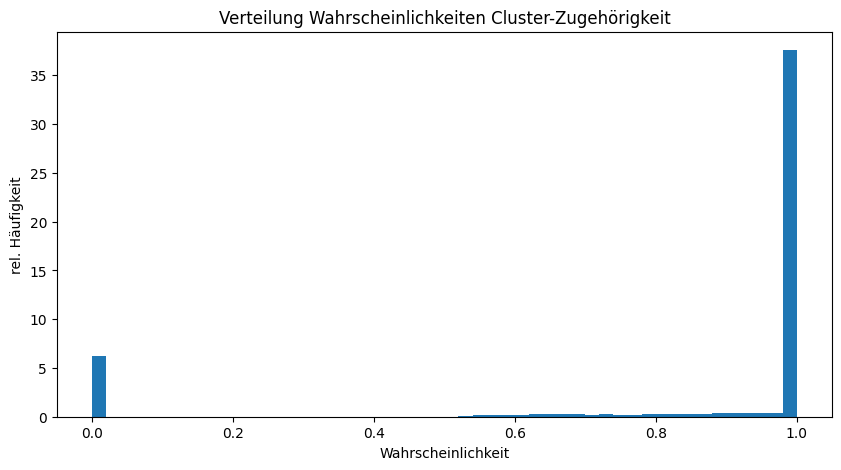

In [68]:
fig = plotHDBSCANProbabilities(hdbscan)

Jetzt da die Cluster bestimmt sind, wollen wir prüfen, wie gross diese mit den Genres übereinstimmen. Anhand der folgenden Tabelle können wir erkennen, dass Cluster 1 mit Abstand der grösste ist und Cluster 0 und 2 jeweils nur wenige Filme enthalten. Punkte mit der Nummer -1 sind keinem Cluster zugewiesen und unabhängig voneinander.

In [69]:
pd.Series(hdbscan.labels_).value_counts()

 1    9309
-1    1336
 0       5
 2       5
dtype: int64

Weiter sehen wir im folgenden, dass Filme im Cluster 1 aus allen Genres stammen und nicht nur ein Subset abdecken. Auch bei den anderen Gruppen sowie den unabhänigen Filmen lässt sich kein Muster erkennen.

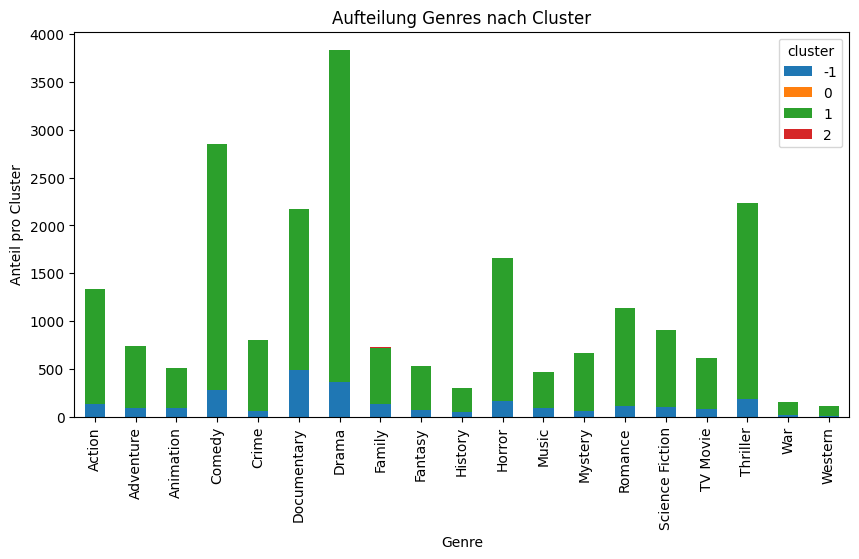

In [70]:
fig = plotHDBSCANClustersAlongGenres(hdbscan, genres)

Dichtebasierte Algorithmen funktionieren schlechter in hochdimensionalen Räumen, was in unserem Fall mit 768 Dimensionen wahrscheinlich der Fall ist. Aus diesem Grund verwenden wir die mit PCA reduizerten Daten für ein weiteres Clustering.

In [71]:
hdbscan_reduced = HDBSCAN().fit(reduced_embeddings)
print('Anzahl gefundene Cluster:', hdbscan_reduced.labels_.max())

Anzahl gefundene Cluster: 3


Es konnte nun eine weitere Gruppe gefunden werden, aber auch hier können keine Muster erkannt werden, wenn deren Verteilungen über die verschiedenen Genres betrachtet werden.

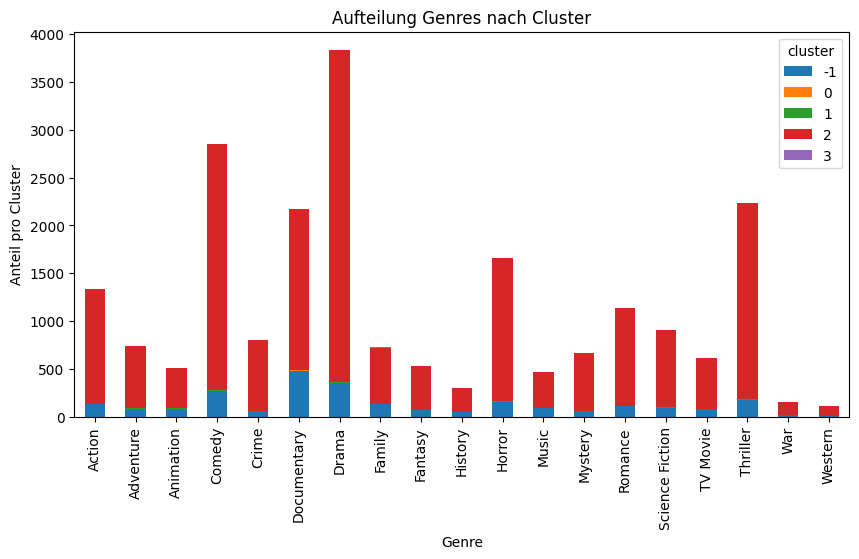

In [72]:
fig = plotHDBSCANClustersAlongGenres(hdbscan_reduced, genres)

Eine weitere Art der Dimensionsreduktion ist UMAP. Dabei handelt es sich im Gegensatz zu PCA um keine lineare Abbildung der Ursprungsdaten. UMAP kann aber helfen, dass die Daten auf zwei Dimensionen reduziert und somit in einem Scatterplot dargestellt werden können. Darin können dann möglicherweise Gruppen erkannt werden, die durch die Transformationen erhalten halten bleiben.

In [73]:
umap = UMAP(min_dist=0.0, n_neighbors=10)
umap_embeddings = umap.fit_transform(sentence_embeddings)

Wenn wir die Datenpunkte pro Genre darstellen, können wir in den einzelnen leider keine Gruppierungen von Datenpunkten erkennen. Im Gegenteil, bei jedem Genre ist dieselbe Form zu erkennen. Es gibt abgesehen vom grossen Bogen zwar einzelne Gruppen mit wenigen Datenpunkten, aber auch diese sind bei mehreren Genres ersichtlich. Daraus kann geschlossen werden, dass die Sentence Embeddings sehr weit von den Genres entfernt sind und somit neue Informationen über die Filme liefern.

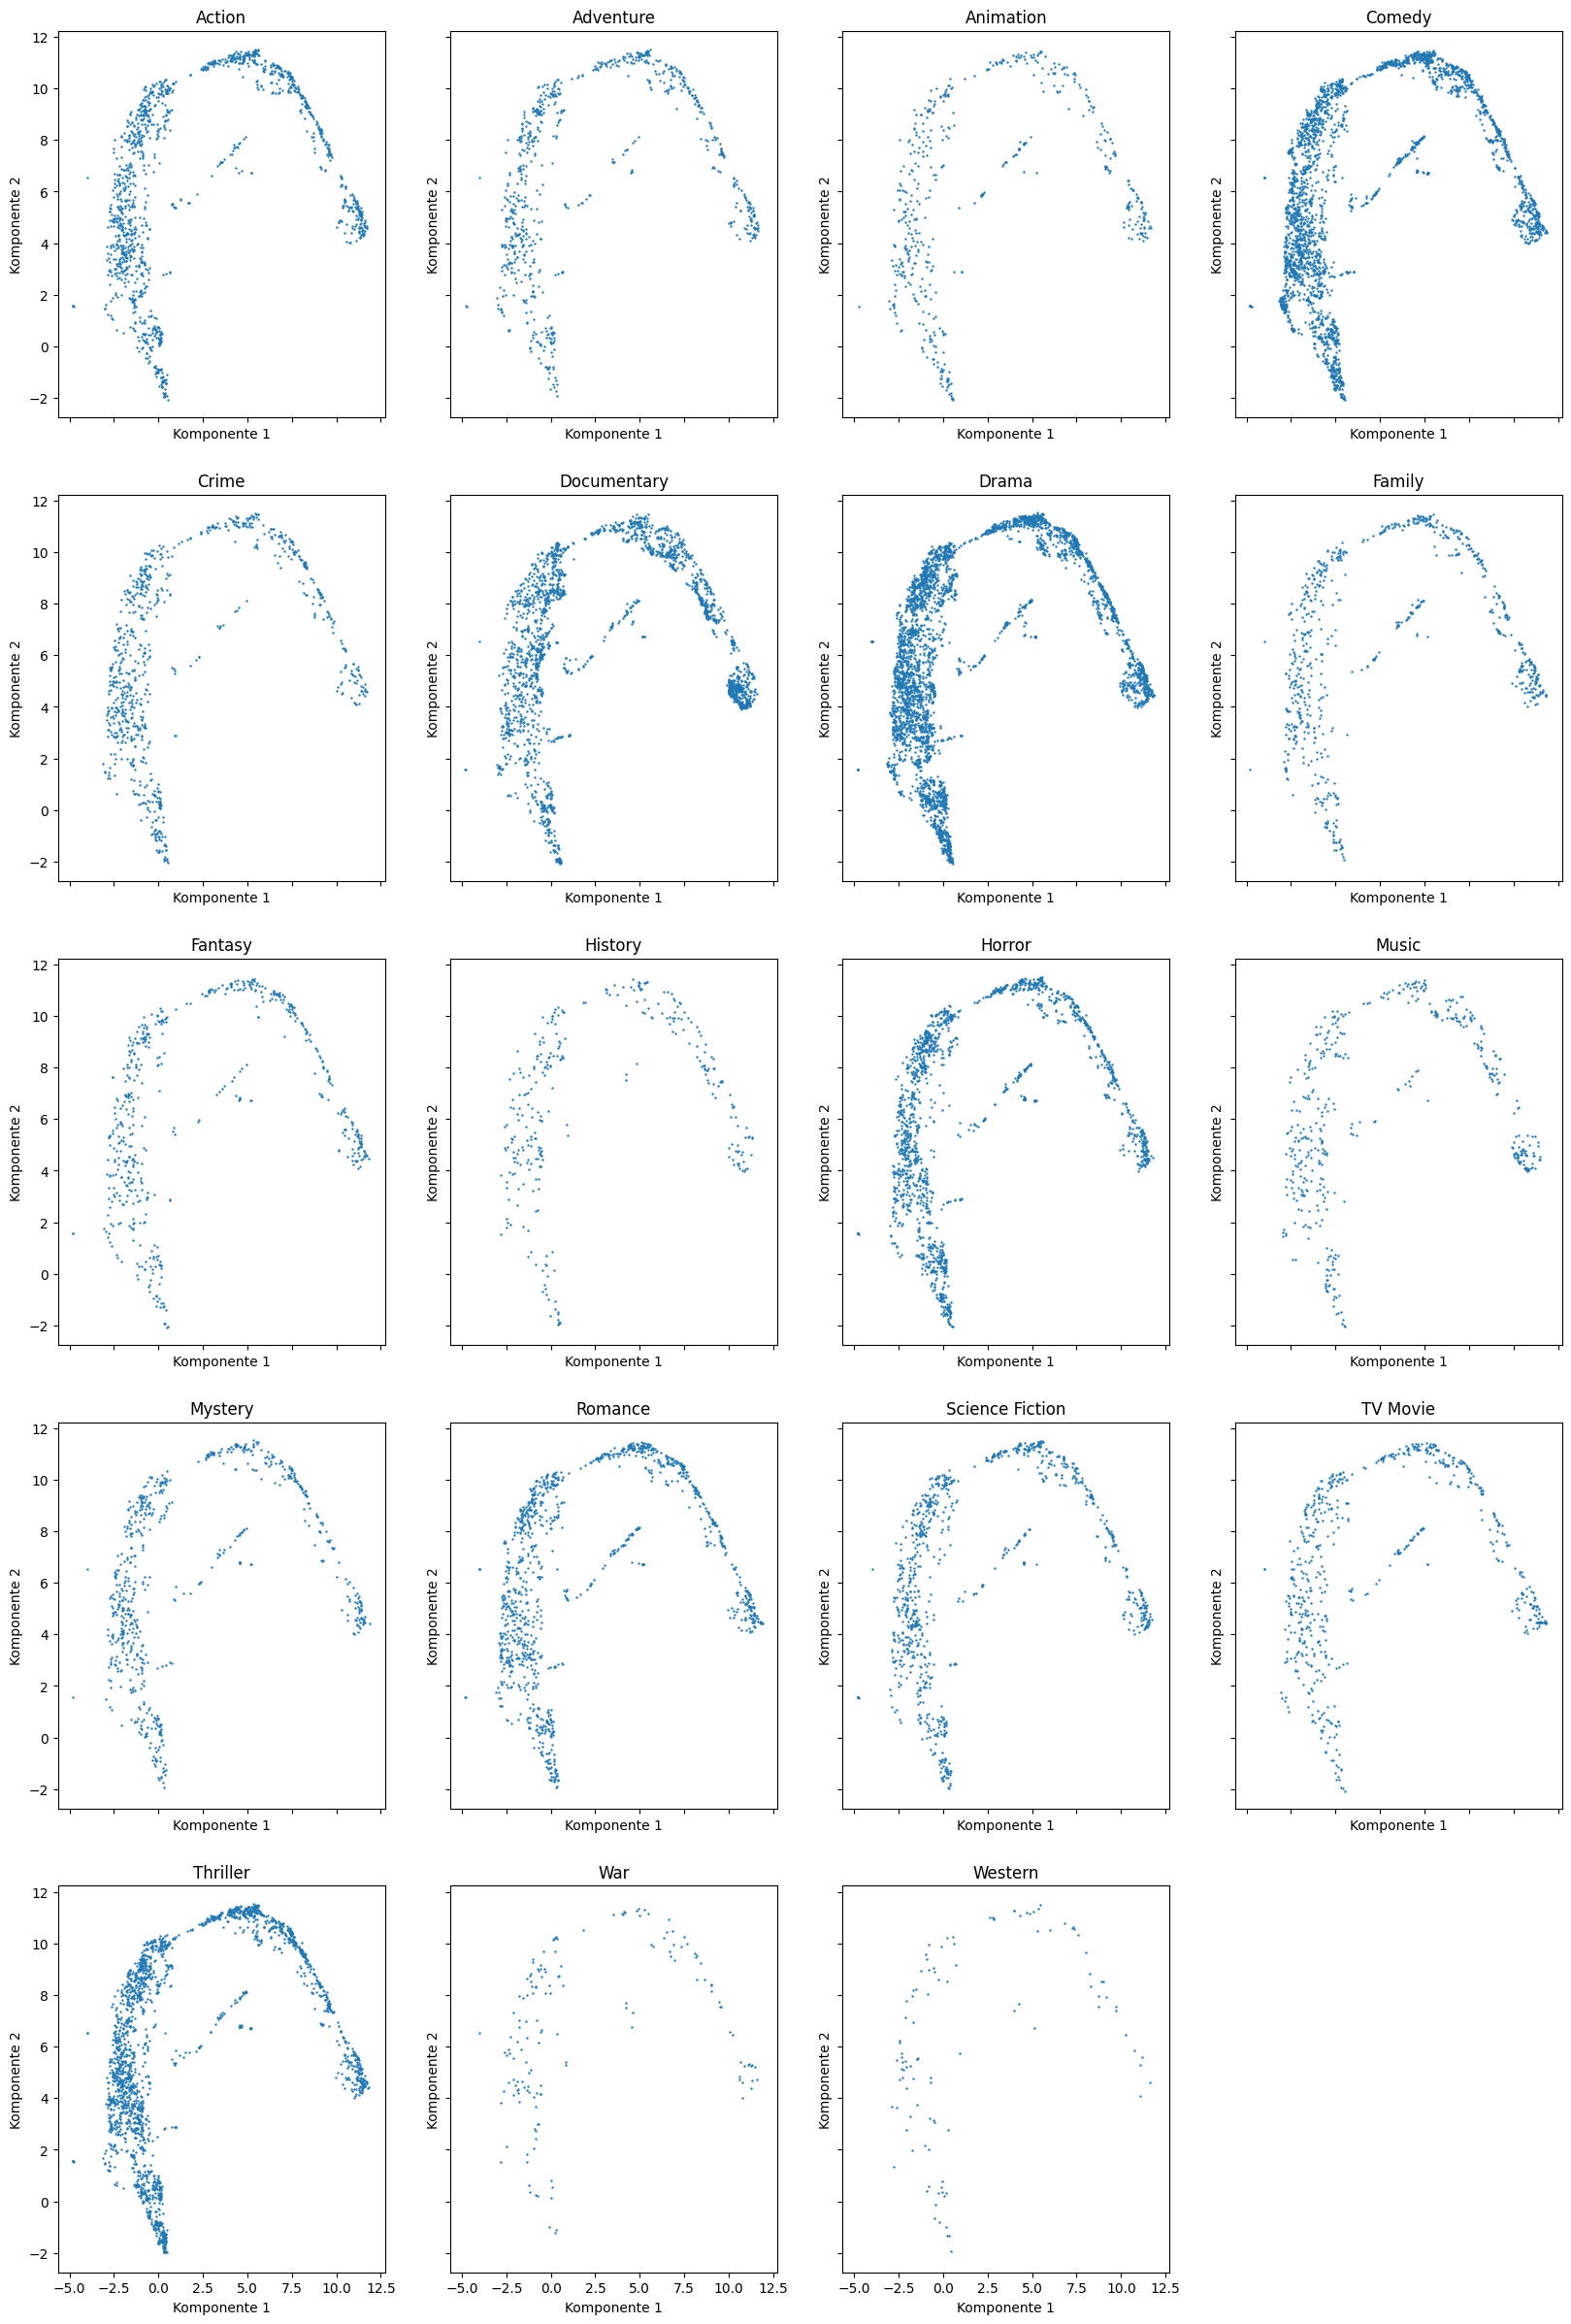

In [74]:
fig = plotUMAPEmbeddingsAlongGenres(umap_embeddings, genres)

Es kann also nicht von den Embeddings auf die Genres geschlossen werden. Vielleicht kann anhand dieser aber das Durchschnittsrating der Filme bestimmt werden. Deshalb stellen wir in einem weiteren Plot nochmals die reduzierten UMAP-Daten dar und färben die Datenpunkte entsprechend ihrerer mittleren Bewertung ein. Aber auch hier ist kein Muster zu erkennen.

In [75]:
ratings = pd.read_csv('movielens_data/ratings.csv')
ratings = ratings[ratings.movieId.isin(movieIds)]
mean_ratings = ratings.groupby('movieId').rating.mean().sort_index()

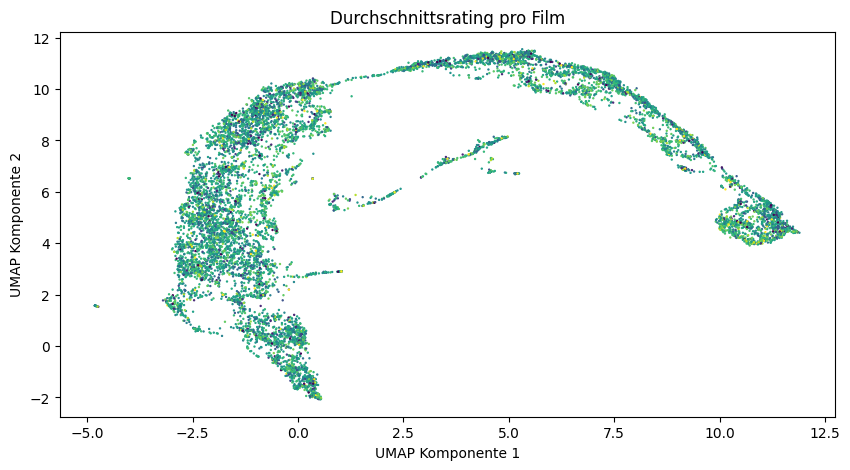

In [76]:
reduced_umap_embeddings = umap_embeddings[movieIds.isin(mean_ratings.index)]
plt.figure(figsize = (10, 5))
plt.scatter(reduced_umap_embeddings[:,0], reduced_umap_embeddings[:,1], c=mean_ratings.values, s=0.5)
plt.title('Durchschnittsrating pro Film')
plt.xlabel('UMAP Komponente 1')
plt.ylabel('UMAP Komponente 2')
plt.show()

### Fazit

Nach diesen vielen Analysen können wir sagen, dass weder ein Zusammenhang zwischen Sentence-Embeddings und Genres noch zwischen diesen und der Durchschnittsbewertung besteht. Jedoch scheint es unter einzelnen Filmprofilen aus diesen Embeddings Zusammenhänge zu geben, was man an den Ähnlichkeitswerten und der langgezogenen Form in den mit UMAP reduzierten Daten erkennen kann. Die Filmprofile scheinen also nicht eine Sammlung von zusammenhangslosen Punkten zu sein, was für die Berechnung der Ähnlichkeiten schlecht wäre.

Wir speichern die Sentence-Embeddings nun als CSV-Datei ab, damit es von der Library verwendet werden kann, um die Recommendersysteme zu bauen.

In [77]:
sentence_embeddings.to_csv(embeddings_file_cls)

## Modellierung des Recommendersystems

Da die Featurematrix nun bereit ist, können wir diese verwenden, um unsere ersten Recommendersysteme mit diesen Daten zu bauen.

In [78]:
matrix_cls = MatrixGenerator(bertEmbeddings=embeddings_file_cls)

Wir möchten dabei gleich die zwei Ähnlichkeitsmasse Cosine und Pearson vergleichen. Da die Featurematrizen aus komplett anderen Daten bestehen als beim Baseline-Modell, ist es möglich, dass ein anderes Ähnlichkeitsmass hier besser funktioniert. Da mit der tertiären Ratingskala die besten Resultate beim Baseline-Recommendersystem erzielt werden konnten, werden wir diese nun auch hier einsetzen.

In [79]:
cosine_config = CakeConfig(
    {MatrixGenerator.CONST_KEY_BERT: np.array(1)},
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE
)

pearson_config = CakeConfig(
    {MatrixGenerator.CONST_KEY_BERT: np.array(1)},
    SimilarityEnum.PEARSON,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE
)

cosine_eval = Evaluation('BERT_cls_cosine', cosine_config, matrix_cls)
pearson_eval = Evaluation('BERT_cls_pearson', pearson_config, matrix_cls)

cakeommender finished 🥳: 100%|██████████| 8/8 [00:03<00:00,  2.24it/s] 


In [80]:
mean_cosine_precision, std_cosine_precision = cosine_eval.precision()
mean_pearson_precision, std_pearson_precision = pearson_eval.precision()

100%|██████████| 5/5 [03:55<00:00, 47.03s/it, mean=0.559, std=0.004]


In [81]:
cosine_topn_precision = cosine_eval.topNPrecision()
pearson_topn_precision = pearson_eval.topNPrecision()

cosine_novelty = cosine_eval.novelty()
pearson_novelty = pearson_eval.novelty()

cakeommender finished 🥳: 100%|██████████| 8/8 [00:01<00:00,  7.98it/s] 


Bei Betrachtung der Precision-Werte für 5-fache Kreuzvalidierung ist zwischen den beiden Modellen kein Unterschied zu erkennen. Mit beiden Ähnlichkeitsmassen kann ein Wert um 0.55 erreicht werden. Damit ist dieses Modell in etwa gleich gut wie unser Random-Recommendersystem.

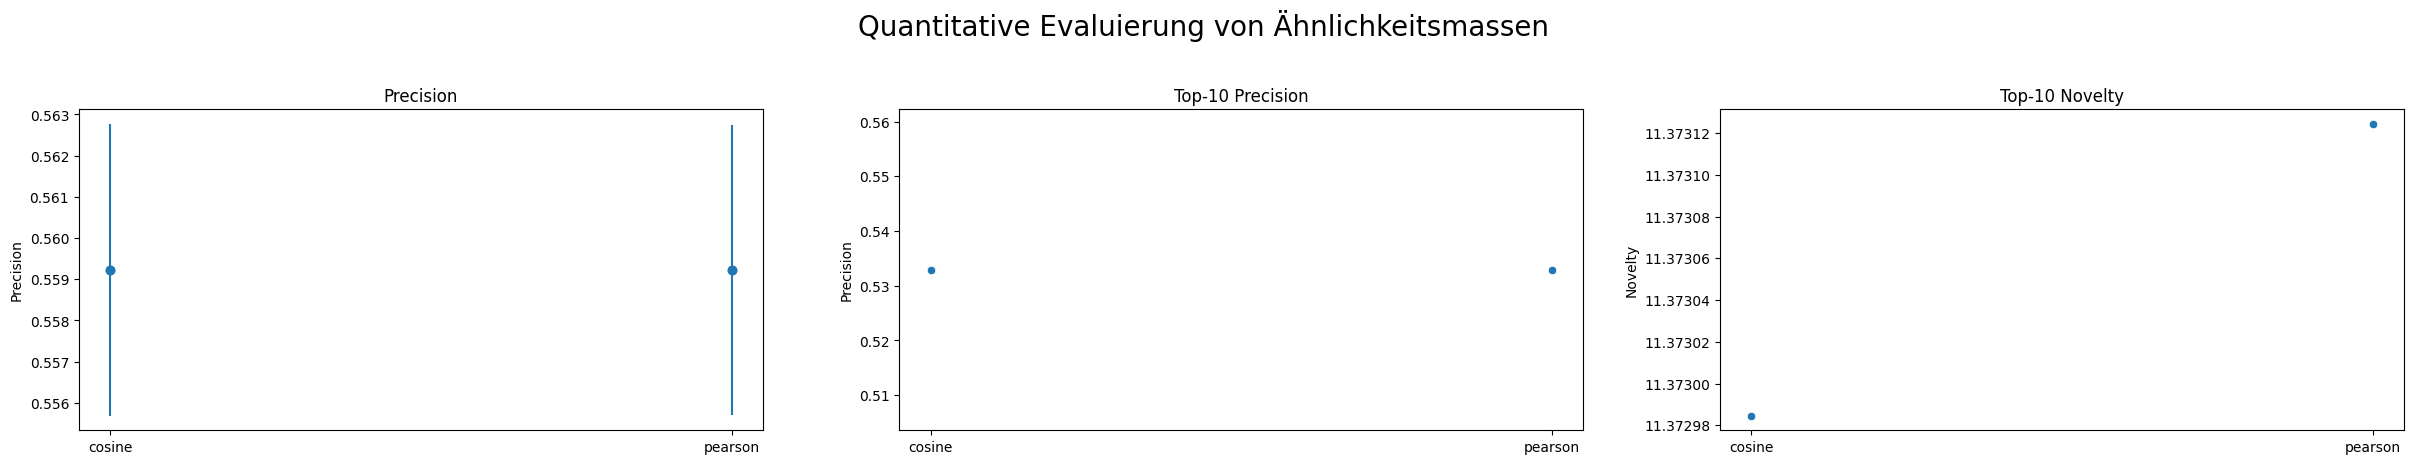

In [82]:
fig = plot_results(
    ['cosine', 'pearson'],
    [mean_cosine_precision, mean_pearson_precision],
    [std_cosine_precision, std_pearson_precision],
    [cosine_topn_precision, pearson_topn_precision],
    [cosine_novelty, pearson_novelty],
    'Ähnlichkeitsmassen'
)

Für diese beiden Recommendersysteme haben wir die Embeddings standardisiert. Da wir jedoch die Embeddings nicht verstehen können, können wir auch nicht beurteilen inwiefern diese Standardisierung die Embeddings beeinflusst. Als Vergleich soll nun ein Recommendersystem ohne Normalisierung erstellt werden.

In [83]:
none_config = CakeConfig(
    {MatrixGenerator.CONST_KEY_BERT: np.array(1)},
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.NONE
)

none_eval = Evaluation('BERT_cls_cosine_no-norm', none_config, matrix_cls)

cakeommender finished 🥳: 100%|██████████| 8/8 [00:04<00:00,  1.93it/s] 


In [84]:
mean_none_precision, std_none_precision = none_eval.precision()
none_topn_precision = none_eval.topNPrecision()
none_novelty = none_eval.novelty()

cakeommender finished 🥳: 100%|██████████| 8/8 [00:00<00:00, 13.57it/s] 


Es zeigt sich, dass mit der Standardisierung deutlich bessere Ergebnisse erzielt werden können. Das Modell ohne Standardisierung fällt hinter das Modell mit den Zufallsdaten zurück. Zwar ist die Novelty deutlich höher als mit Standardisierung, was aber nutzlos ist, wenn die Filmvorschläge den Filmschauenden nicht gefallen.

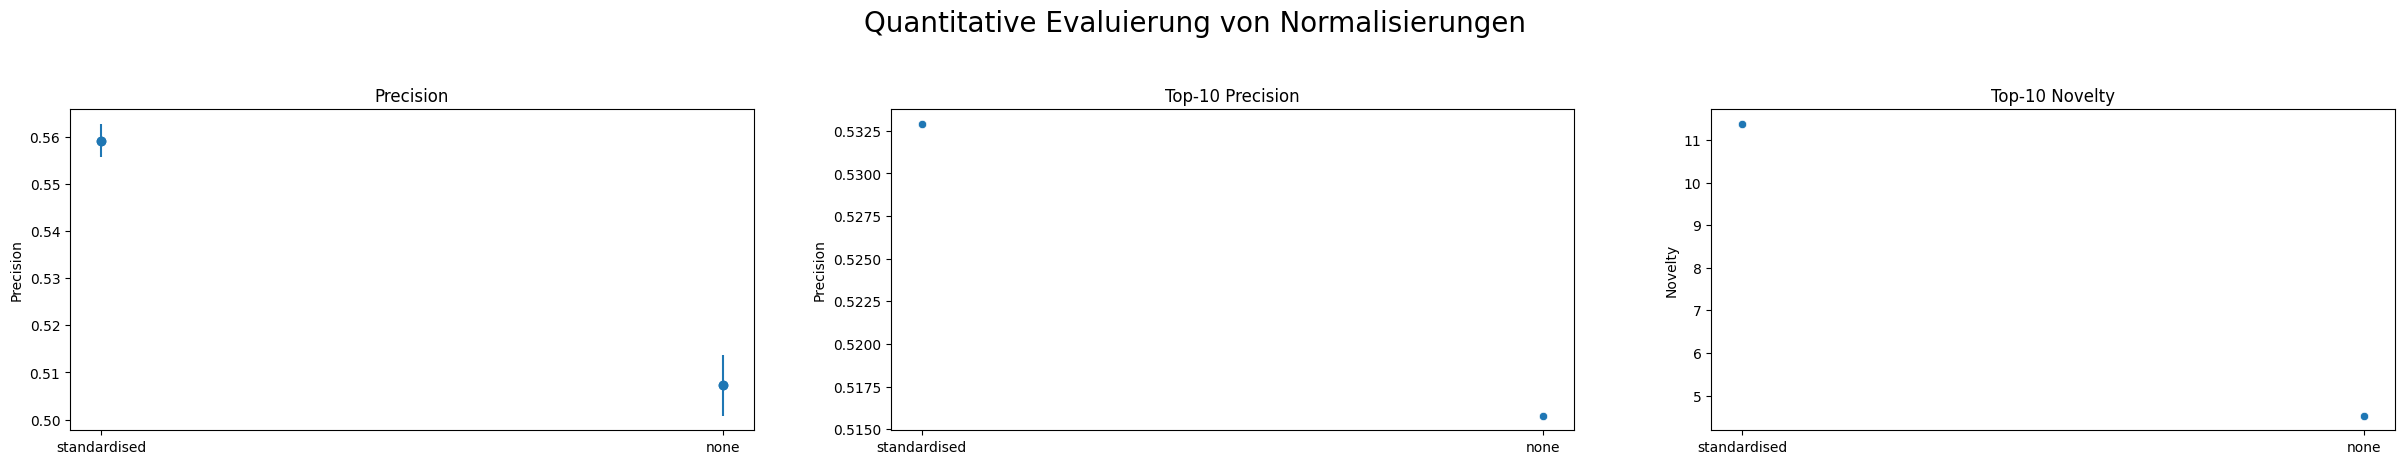

In [85]:
fig = plot_results(
    ['standardised', 'none'],
    [mean_cosine_precision, mean_none_precision],
    [std_cosine_precision, std_none_precision],
    [cosine_topn_precision, none_topn_precision],
    [cosine_novelty, none_novelty],
    'Normalisierungen'
)

### Avg-Pooling

Bis anhing haben wir bei BERT die Embeddings des *[CLS]*-Token als Features übernommen. Eine weitere Variante um die Sentence-Embeddings zu erhalten, ist über das Mitteln der Embeddings aller Word-Tokens.

In [86]:
embeddings_file_avg = 'data/movies_bert_avg.csv'
sentence_embeddings_avg = pd.read_csv(embeddings_file_avg, index_col='movieId')
# sentence_embeddings_avg = Bertomat(BertEnum.BERT, pooling='avg').generateEmbeddings(meta[0:n])
sentence_embeddings_avg = sentence_embeddings_avg.loc[movieIds].sort_index()
sentence_embeddings_avg.shape

(10655, 768)

In [87]:
sentence_embeddings_avg.to_csv(embeddings_file_avg)

Zunächst wollen wir prüfen, ob sich mit diesen Sentence-Embeddings Cluster bilden lassen, die mit den Genres übereinstimmen. Wir verwenden deswegen wieder `HDBSCAN` und erhalten dieses Mal vier Cluster.

In [88]:
hdbscan_avg = HDBSCAN().fit(sentence_embeddings_avg)
print('Anzahl gefundene Cluster:', hdbscan_avg.labels_.max() + 1)

Anzahl gefundene Cluster: 4


Die Wahrscheinlichkeiten, dass die Filme, die einem Cluster zugewiesen wurden auch zu diesem gehören ist bei den meisten bei 1, was ein gutes Zeichen ist.

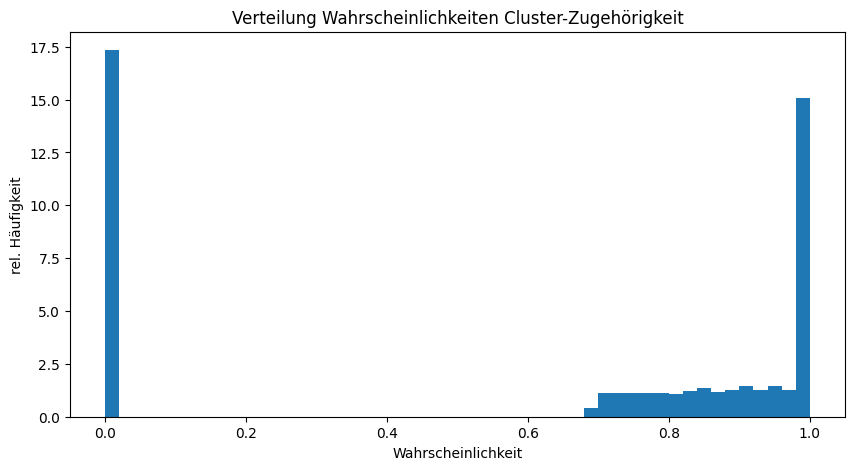

In [89]:
fig = plotHDBSCANProbabilities(hdbscan_avg)

Leider befinden sich etwa 70 % der Filme im selben Cluster und die restlichen ca. 30 % blieben ungruppiert. Die weiteren zwei Cluster enthielten lediglich zwischen 5 und 7 Datenpunkte.

In [90]:
pd.Series(hdbscan_avg.labels_).value_counts()

 2    6942
-1    3695
 1       7
 3       6
 0       5
dtype: int64

Entsprechend gibt es auch hier keine Übereinstimmungen mit den Genres, wie folgender Barplot zeigt.

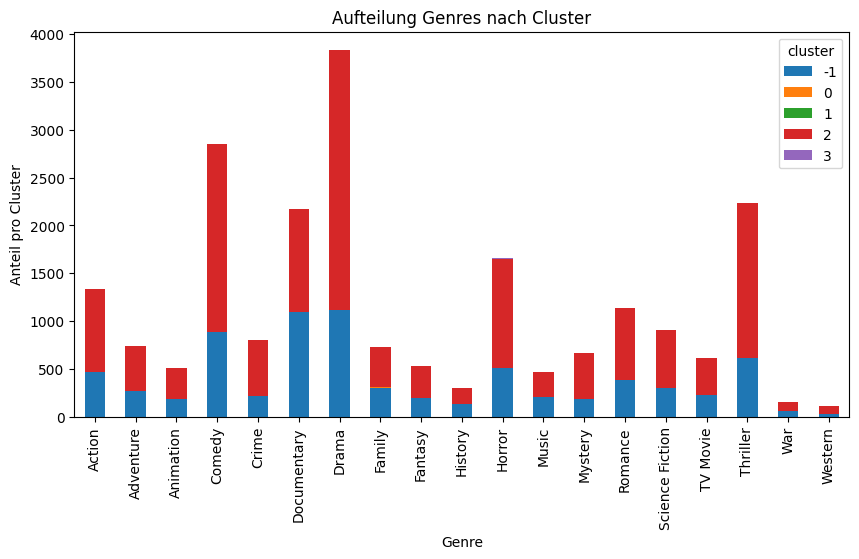

In [91]:
fig = plotHDBSCANClustersAlongGenres(hdbscan_avg, genres)

Und auch mit der UMAP-Dimensionsreduktion lassen sich keine Muster auf Basis der Genres erkennen. Die Datenpunkte sind bei allen Genre-Plots über die ganze Kurve verstreut.

In [92]:
umap_avg = UMAP(min_dist=0.0, n_neighbors=10)
umap_embeddings_avg = umap_avg.fit_transform(sentence_embeddings_avg)

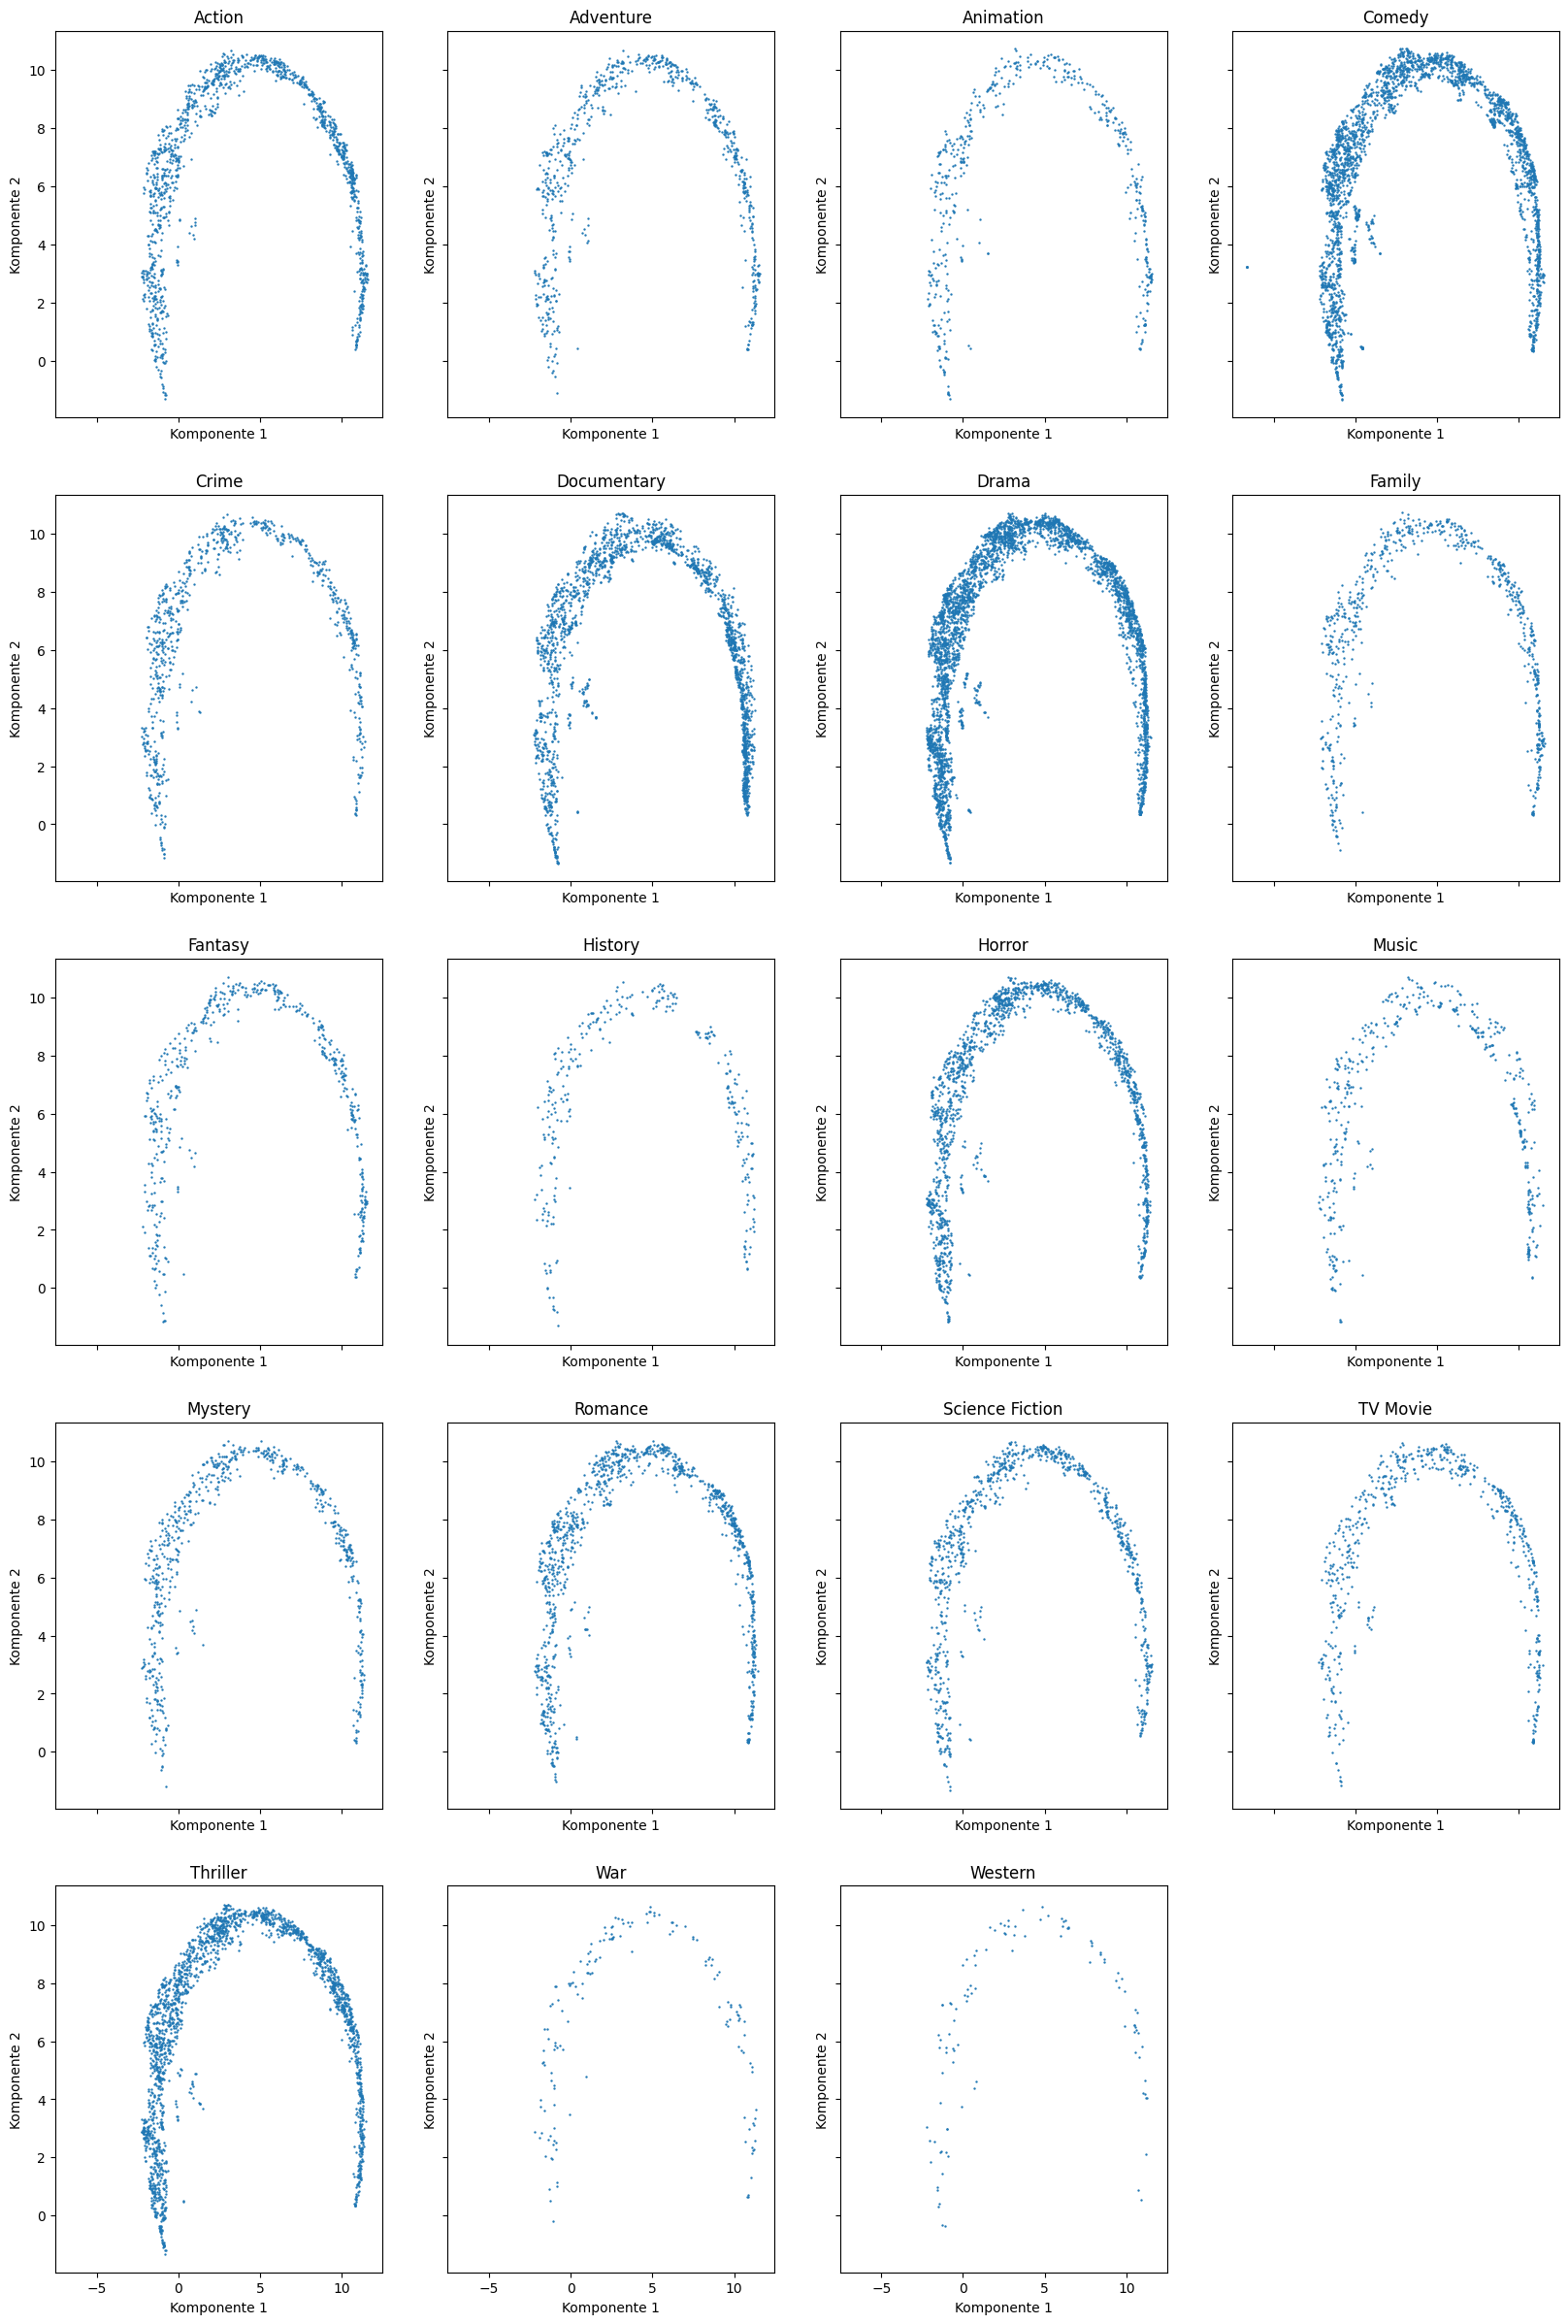

In [93]:
fig = plotUMAPEmbeddingsAlongGenres(umap_embeddings_avg, genres)

Auch mit diesem Pooling-Verfahren erhalten wir keine Embeddings, die grosse Übereinstimmungen mit den Genres haben. Dies muss kein Problem sein, da wir durch die NLP-Modelle zusätzliche Informationen in das Modell bringen wollen.

Als nächstes wollen wir herausfinden, ob mit dem Average-Pooling ein besseres Recommendersystem erstellt werden kann. Wir verwenden erneut die teritäre Ratingskala für die Nutzerprofile und vergleichen die zwei Ähnlichkeitsmasse Cosine und Pearson. In den Resultaten sehen wir, dass beide Masse ähnliche Werte erreichen. Die geringen Unterschiede sind nicht signifikant.

In [94]:
matrix_avg = MatrixGenerator(bertEmbeddings=embeddings_file_avg)
cosine_avg_eval = Evaluation('BERT_avg_cosine', cosine_config, matrix_avg)
pearson_avg_eval = Evaluation('BERT_avg_pearson', pearson_config, matrix_avg)

cakeommender finished 🥳: 100%|██████████| 8/8 [00:03<00:00,  2.48it/s] 


In [95]:
mean_cosine_avg_precision, std_cosine_avg_precision = cosine_avg_eval.precision()
mean_pearson_avg_precision, std_pearson_avg_precision = pearson_avg_eval.precision()

100%|██████████| 5/5 [04:18<00:00, 51.74s/it, mean=0.56, std=0.003] 


In [96]:
cosine_avg_topn_precision = cosine_avg_eval.topNPrecision()
pearson_avg_topn_precision = pearson_avg_eval.topNPrecision()

cosine_avg_novelty = cosine_avg_eval.novelty()
pearson_avg_novelty = pearson_avg_eval.novelty()

cakeommender finished 🥳: 100%|██████████| 8/8 [00:00<00:00,  9.66it/s] 


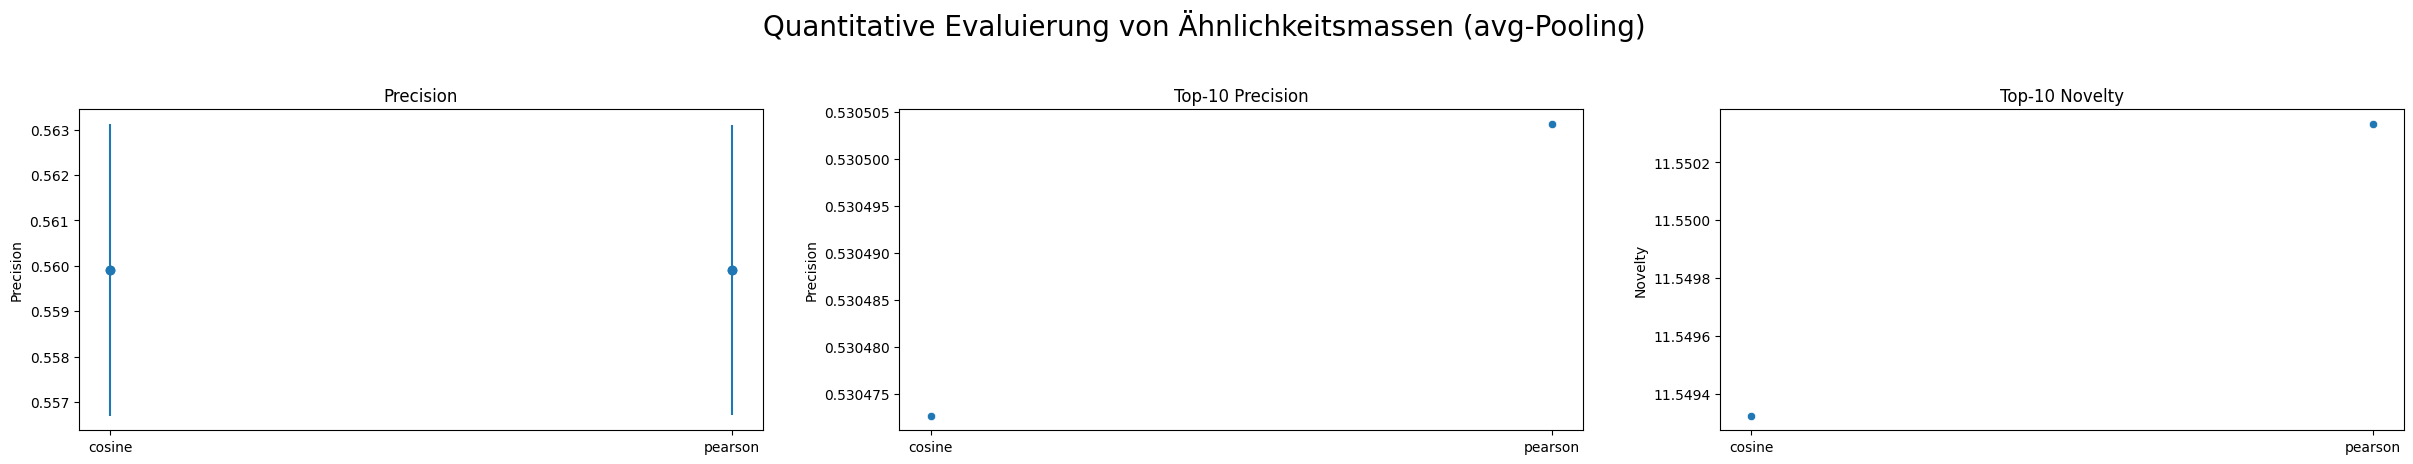

In [97]:
fig = plot_results(
    ['cosine', 'pearson'],
    [mean_cosine_avg_precision, mean_pearson_avg_precision],
    [std_cosine_avg_precision, std_pearson_avg_precision],
    [cosine_avg_topn_precision, pearson_avg_topn_precision],
    [cosine_avg_novelty, pearson_avg_novelty],
    'Ähnlichkeitsmassen (avg-Pooling)'
)

## Modelle mit PCA-Dimensionsreduktion

Mit ihren 768-Dimensionen ist die Featurematrix möglicherweise zu gross und enthält zu viele Details. Mittels PCA können wir die Anzahl Dimensionen verringern und uns somit auf die grössten Unterschiede in den Daten fokussieren. Minime Unterschiede werden nicht ins reduzierte Datenset übernommen. Wir beginnen mit einer Reduktion auf nur zwei Dimensionen.

In [98]:
pca = PCA(n_components=2)
twodim_embeddings_avg = pca.fit_transform(sentence_embeddings_avg)
twodim_embeddings_avg = pd.DataFrame(twodim_embeddings_avg, index=sentence_embeddings_avg.index)
twodim_embeddings_avg.shape

(10655, 2)

Wenn wir nun die Cosine-Ähnlichkeiten zwischen den Filmen anhand dieser zwei Features berechnen, sehen wir, dass diese einer komplett anderen Verteilung unterliegen als noch mit allen 768 Dimensionen (siehe Plot weiter oben). Wir haben nun auch Anti-Korrelationen (Werte um -1) und die Peaks befinden sich nun an beiden Enden (bei -1 und 1). In unseren Recommendersystemen verwenden wir die tatsächlichen und keine absoluten Ähnlichkeitswerte, um die Grenze zwischen guten und schlechten Übereinstimmungen zu ziehen. Eine Ähnlichkeit von -1 würde bedeuten, dass die Features der zwei Filme (bzw. des Films und Nutzprofils) komplett gegensätzlich sind und entsprechend sind die Filmschauenden nicht an solchen Vorschlägen interessiert.

Minimum Ähnlichkeit: -0.9999999999999996
Maximum Ähnlichkeit: 1.0


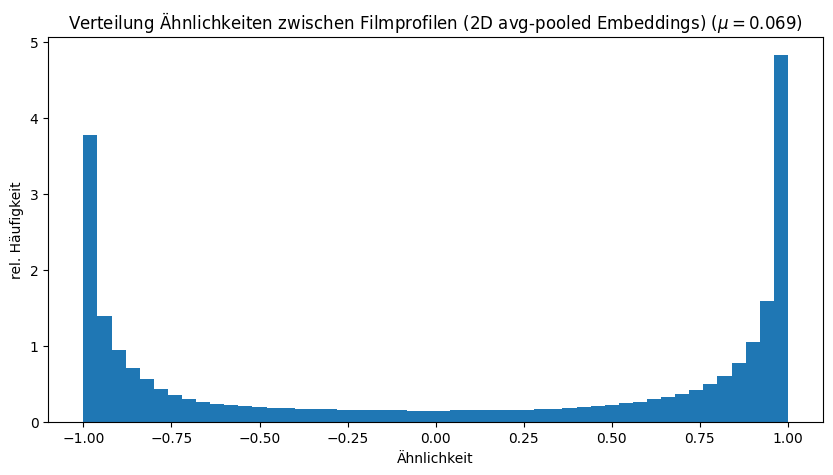

In [99]:
fig = plotSimiliarities(twodim_embeddings_avg, '2D avg-pooled Embeddings')

Wir erstellen nun einige Recommendersysteme mit unterschiedlichen Dimensionen und prüfen, mit welchem die besten Metriken erzielt werden können. Als Dimensionen werden 2, 5, 10, 100, 200 und 500 getestet.

In [100]:
results = [{
    'dim': 768,
    'mean_precision': mean_cosine_avg_precision,
    'std_precision': std_cosine_avg_precision,
    'topn_precision': cosine_avg_topn_precision,
    'novelty': cosine_avg_novelty
}]

for dim in [2, 5, 10, 100, 200, 500]:
    pca = PCA(n_components=dim)
    reduced_embeddings_avg = pca.fit_transform(sentence_embeddings_avg)
    reduced_embeddings_avg = pd.DataFrame(reduced_embeddings_avg, index=sentence_embeddings_avg.index)

    embeddings_file_avg_reduced = f'data/movies_bert_avg_{dim}d.csv'
    reduced_embeddings_avg.to_csv(embeddings_file_avg_reduced)

    matrix = MatrixGenerator(bertEmbeddings=embeddings_file_avg_reduced)
    eval = Evaluation(f'BERT_avg_cosine_{dim}d', cosine_config, matrix)
    mean_precision, std_precision = eval.precision()
    results.append({
        'dim': dim,
        'mean_precision': mean_precision,
        'std_precision': std_precision,
        'topn_precision': eval.topNPrecision(),
        'novelty': eval.novelty()
    })

cakeommender finished 🥳: 100%|██████████| 8/8 [00:00<00:00, 14.02it/s] 


Anhand der Precision können wir sagen, dass mit nur 2 Dimensionen kein gutes Recommendersystem erstellt werden kann. Dieses erreicht ähnliche Werte wie das Modell mit zufälligen Featurewerten. Mit mehr Dimensionen wird auch die allgemeine Precision und diejenige für die Top-10-Liste verbessert. Am besten funktioniert das Modell mit 100 Dimensionen. Es erreicht deutlich bessere Werte als das mit 768-Dimensionen ohne PCA-Transformation. Mit der Zunahme der Precision leidet auch die Novelty, aber bei 100 Dimensionen ist diese nur leicht niedriger als beim Höchstwert und beim kompletten Featureset.

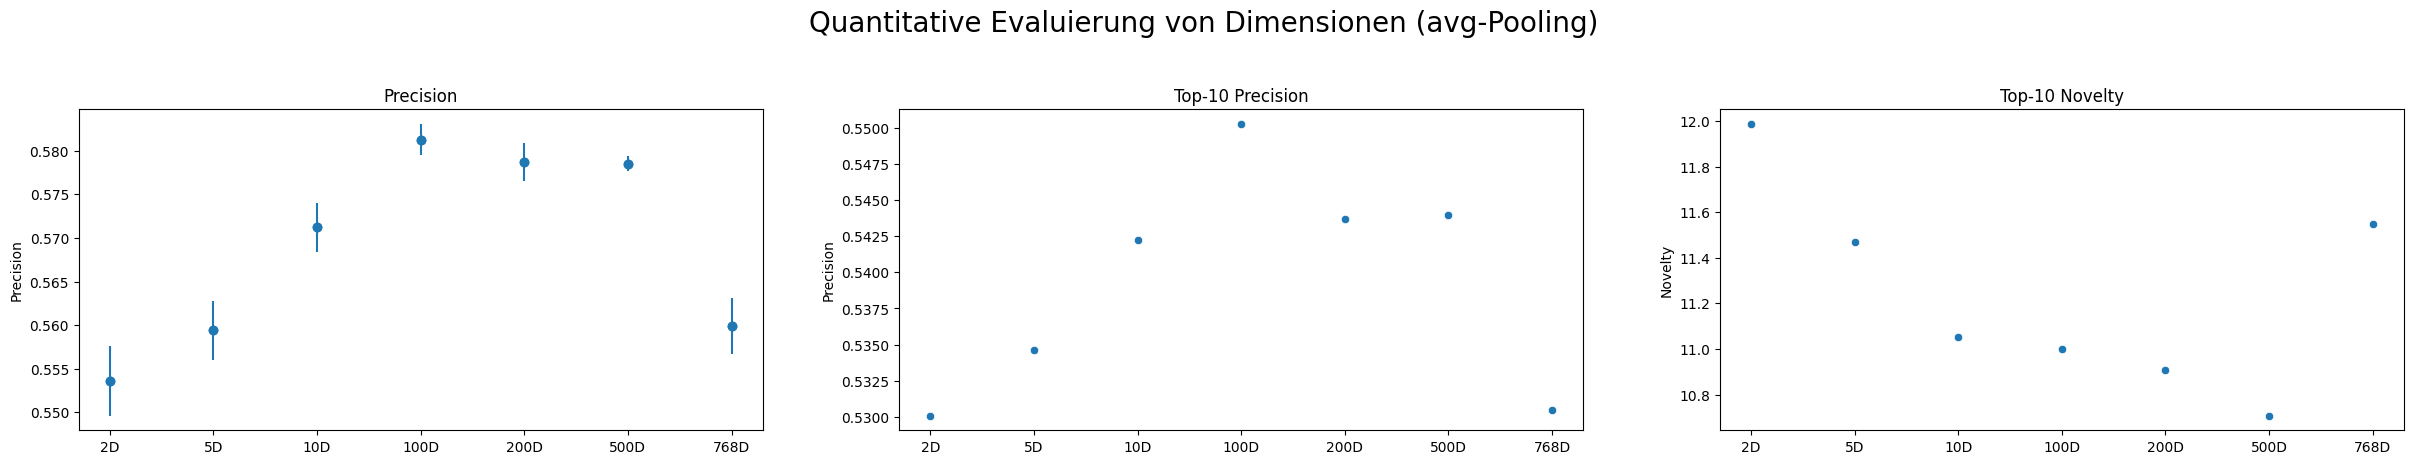

In [101]:
results_df = pd.DataFrame(results).sort_values('dim')
fig = plot_results(
    results_df.dim.astype(str) + 'D', results_df.mean_precision, results_df.std_precision, results_df.topn_precision, results_df.novelty, 'Dimensionen (avg-Pooling)'
)

## Fazit

Die Precision verändert sich kaum, wenn statt dem CLS-Pooling das Average-Pooling verwendet wird. Wichtig ist jedoch, dass die Features standardisiert werden. Ohne Normalisierung verschlechtern sich die Werte stark. Die Novelty verhält sich ziemlich genau gegenteilig zur Precision. Modelle mit einer hohen Precision, haben tendenziell eine niedrige Novelty.

Durch die PCA-Dimensionsreduktion auf 100 Features konnte das Recommendersystem noch ein bisschen verbessert werden, so dass es nun leicht bessere Ergebnisse als das Random-Modell liefert. Dennoch ist dieses beste BERT-Recommendersystem deutlich schlechter als das Baseline-Modell. Die Sentence-Embeddings von BERT scheinen andere Informationen ins Modell zu bringen als das Genre-Modell, die aber weniger gut für die Ähnlichkeitsberechnung geeignet sind als die Genres selbst. Möglicherweise kann eine Kombination aus Embeddings und Filmmetadaten bessere Filmvorschläge liefern.

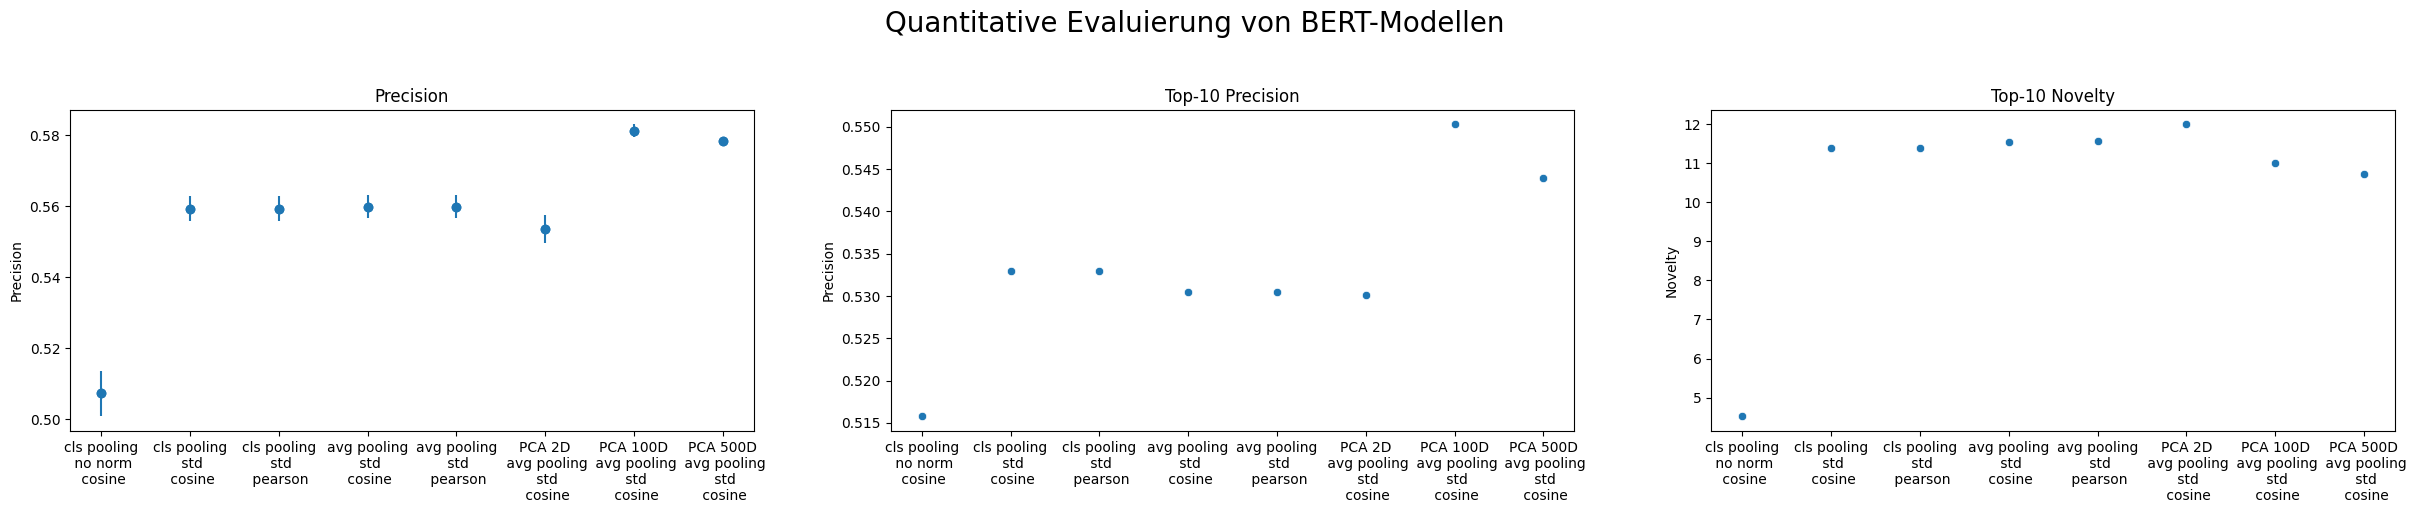

In [102]:
overview_results = results_df[results_df.dim.isin([2, 100, 500])]
fig = plot_results(
    [
        'cls pooling\n no norm\n cosine',
        'cls pooling\n std\n cosine',
        'cls pooling\n std\n pearson',
        'avg pooling\n std\n cosine',
        'avg pooling\n std\n pearson',
        'PCA 2D\n avg pooling\n std\n cosine',
        'PCA 100D\n avg pooling\n std\n cosine',
        'PCA 500D\n avg pooling\n std\n cosine'
    ],
    [
        mean_none_precision,
        mean_cosine_precision,
        mean_pearson_precision,
        mean_cosine_avg_precision,
        mean_pearson_avg_precision,
        *overview_results.mean_precision
    ],
    [
        std_none_precision,
        std_cosine_precision,
        std_pearson_precision,
        std_cosine_avg_precision,
        std_pearson_avg_precision,
        *overview_results.std_precision
    ],
    [
        none_topn_precision,
        cosine_topn_precision,
        pearson_topn_precision,
        cosine_avg_topn_precision,
        pearson_avg_topn_precision,
        *overview_results.topn_precision
    ],
    [
        none_novelty,
        cosine_novelty,
        pearson_novelty,
        cosine_avg_novelty,
        pearson_avg_novelty,
        *overview_results.novelty
    ],
    'BERT-Modellen'
)

In [103]:
%reset -f

In [104]:
import os
if os.getcwd().endswith('modelling'):
    os.chdir('..')

In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libraries.bert import Bertomat,BertEnum
from libraries.pipeconfig import (
    CakeConfig,
    FeatureNormalizationEnum,
    SimilarityEnum,
    RatingScaleEnum,
)
from libraries.matrix import MatrixGenerator
from cakeommender import Cakeommender
from evaluation import Evaluation, plot_results
from hdbscan import HDBSCAN
from umap import UMAP
from scipy.stats import pearsonr
from libraries.feature_evaluation import plotSimiliarities, plotHDBSCANProbabilities, plotHDBSCANClustersAlongGenres, plotUMAPEmbeddingsAlongGenres, plotCumulativePCAVariance, plotUMAPEmbeddingsGenreAlongTopNGenres
from sklearn.decomposition import PCA

# Recommendersystem mit Sentence-BERT Sentence Embeddings

Bei diesen Recommendersystemen wollen wir Sentence Embeddings von SBERT als Featurematrix verwenden. Wir wandeln dazu den Text `overview` in Tokens um und generieren daraus die Embeddings mit einem vortrainierten SBERT-Modell.

## Steckbrief

### SBERT vs BERT
SBERT (Sentence-Bidirectional Encoder Representations from Transformers) ist eine Modifikation basierend auf BERT. SBERT kann wie BERT für verschieden NLP-Tasks verwendet werden.

#### BERT Ähnlichkeit Umsetzung
BERT ist der de facto Standard für Text Token Generation und die daraus resultierenden Embeddings.
Diese Embeddings können für diverse NLP-Tasks verwendet werden.

Unser Baseline-Recommendersystem berechnet Ähnlichkeiten von Filmen aufgrund von Metadaten wie bsp. "Spieldauer".
Der NLP Task unseres Recommendersystems ist also das Vergleichen von bsp. Filmbeschreibungen und das Generieren von Ähnlichkeiten zwischen den verschiedenen Filmen bzw. Beschreibungen.
Dazu müssen die Beschreibungen vergleichbar gemacht werden.

#### BERT Hindernisse
Um dies in BERT umzusetzen müssten wir den folgenden Ansatz durchführen:
Die zu vergleichenden Sätze müssen, mit einem [SEP] Token dazwischen, zusammengehängt werden.
Diese Kombination kann dann in das BERT-Modell eingespiesen werden und es würde die Ähnlichkeit dieser zwei Sätze liefern.
Um mit diesem Verfahren die jeweils ähnlichsten Filme für alle Filme finden zu können, müssten wir alle möglichen Paarkombinationen der Beschreibungen in das BERT-Modell geben und berechnen lassen.
Danach haben wir alle Ähnlichkeitswerte und können danach sortieren.
Für `n` Filme/Beschreibungen resultiert dies in einer Komplexität von `n(n-1)/2`. Für unseren Recommender mit ca. 10000 Filmen bedeutet dies **49995000** Durchgänge, was zu viel Zeit beanspruchen würde als das man dieses System produktiv einserten könnte.

Um dieses Problem zu umgehen, haben wir für unsere BERT-Recommendersysteme Sentence-Embeddings mit den BERT-Modellen generieren lassen. Wir haben dazu einerseits die Embeddings für das *[CLS]*-Token verwendet oder auch den Mittelwert über alle Word-Embeddings übernommen. Wie wir gesehen haben, konnte damit kein brauchbares Recommendersystem gebaut werden.

#### SBERT Vorteile
SBERT löst diese BERT-Hindernisse indem diese Sentence-Embeddings besser berechnet werden. Das Hauptproblem der Kombinierung und Embeddings Berechnung für Satzpaare entfällt dabei.

### SBERT

Die Architektur von SBERT ist ein sogenanntes `Twin-Network`. Diese Netze können zwei Datenpunkte (Sätze) gleichzeitig und auf gleiche Art verarbeiten.
Auch die Weights und Biases sind dieselben bei der Verarbeitung, somit kann man sich vorstellen das dies ein einzelnes Modell ist welches mehrfach angewendet wird.
<br><br>
![SBERT](modelling/res/SBERT.png "Zwillings Netzwerk Architektur von SBERT")
<br><br>

Auf dem Bild ist zu erkennen, dass der Hauptbestandteil im neuen SBERT-Modell immer noch BERT ist. Die einzige Ergänzung dabei ist ein neuer Pooling-Layer nach dem BERT-Modell.
Pooling-Layers werden genützt um die Dimensionen zu reduzieren.
Dieser Pooling-Layer erlaubt es uns durch das Mitteln aller BERT-Output-Vektoren, ein Embedding für einen ganzen Satz zu generieren, welches besser geeignet ist, um auf Basis dessen Ähnlichkeiten berechnen zu können.


### Referenzen

- Reimers, N., & Gurevych, I. (2019). Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks. https://doi.org/10.48550/ARXIV.1908.10084
- Karlsson, V. (2020, July 11). SentenceBERT — Semantically meaningful sentence embeddings the right way. DAIR.AI. https://medium.com/dair-ai/tl-dr-sentencebert-8dec326daf4e




## Berechnen der Sentence Embeddings

Zuerst müssen die Metadaten aus der CSV-Datei eingelesen werden und Filme ohne Text im Attribut `overview` entfernt werden. Für diese können wir keine Embeddings generieren und sind deshalb für unser Recommendersystem uninteressant.

In [106]:
meta = pd.read_csv(r'./data/movies_meta.csv')

Es sind dieselben zehn Filme wie schon bei den anderen Modellen.

In [107]:
print('Anzahl Filme mit Wert NA in overview:', meta.overview.isna().sum())
meta = meta.dropna(subset = 'overview')
meta.shape

Anzahl Filme mit Wert NA in overview: 0


(10828, 8)

In [108]:
n = 10

In [109]:
sbertomat = Bertomat(BertEnum.SBERT)
sentence_embeddings = pd.read_csv('data/movies_SBert.csv', index_col='movieId')
# sentence_embeddings = sbertomat.generateEmbeddings(meta[0:n])
sentence_embeddings.shape

(10655, 768)

## Evaluierung Embeddings

Auch diese Sentence-Embeddings wollen wir untersuchen bevor wir mit diesen Recommendersysteme erstellen.

In [110]:
genres = pd.read_csv('data/movies_genres.csv', index_col='movieId')
movieIds = genres.index.intersection(sentence_embeddings.index)
sentence_embeddings = sentence_embeddings.loc[movieIds].sort_index()
genres = genres.loc[movieIds].sort_index()
genres.shape

(10655, 19)

Die Ähnlichkeiten zwischen den Filmen sind mit SBERT nun annhähernd normalverteilt. Die BERT-Embeddings waren viel stärker linksschief verteilt, wobei es sehr viele Ähnlichkeiten bei 1.0 gab.

Minimum Ähnlichkeit: -0.22922363439952198
Maximum Ähnlichkeit: 1.0


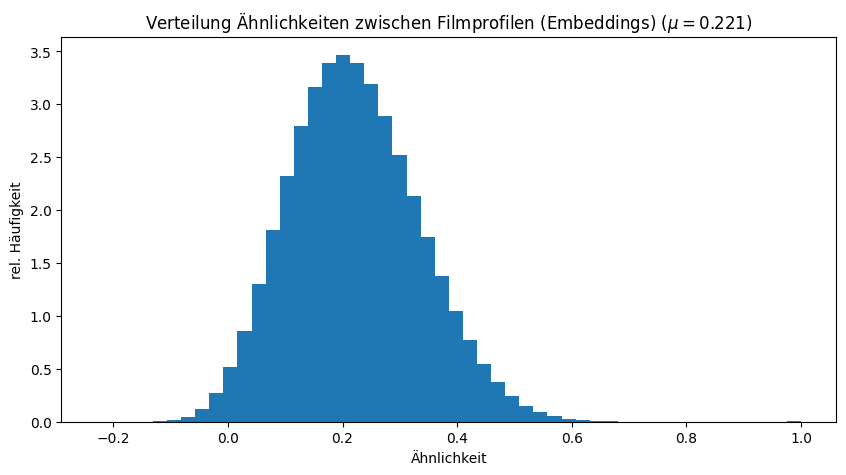

In [111]:
fig, embeddings_sim = plotSimiliarities(sentence_embeddings, 'Embeddings', return_sim=True)

Zum Vergleich hier nochmals die Ähnlichkeiten zwischen den Filmen, wenn Genres als Features verwendet werden.

Minimum Ähnlichkeit: 0.0
Maximum Ähnlichkeit: 1.0


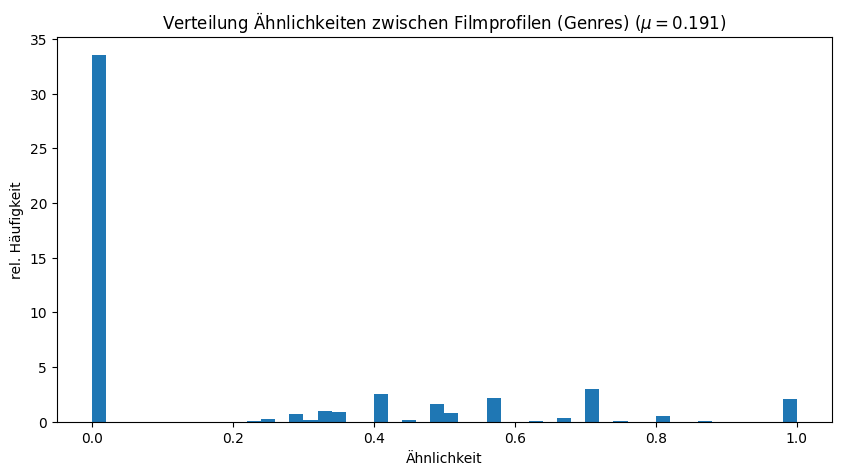

In [112]:
fig, genres_sim = plotSimiliarities(genres, 'Genres', return_sim=True)

Der Pearson-Korrelationskoeffizient zwischen Genre- und Embedding-Ähnlichkeiten liegt hier bei knapp 0.2. Für die BERT-Embeddings lag dieser noch ca. zehnmal tiefer. Die Korrelation ist hier stärker, wenn auch nicht sonderlich stark. Es wäre aber möglich, dass diese Embeddings nun näher bei den Genres sind.

In [113]:
pearsonr(embeddings_sim.flatten(), genres_sim.flatten())

PearsonRResult(statistic=0.1990454292352204, pvalue=0.0)

Auch mit diesen Sentence-Embeddings wollen wir ein Clustering vornehmen. Wir wählen das gleiche Vorgehen wie bei den BERT-Embeddings und starten mit `HDBSCAN`. Es resultieren drei Cluster, was im Vergleich zu den Genres relativ wenige sind.

In [114]:
hdbscan = HDBSCAN().fit(sentence_embeddings)
print('Anzahl gefundene Cluster:', hdbscan.labels_.max() + 1)

Anzahl gefundene Cluster: 3


Eine Mehrheit der Filme wurde keinem Cluster zugewiesen, was man an der Wahrscheinlichkeit von 0 erkennen kann. Dafür besitzen die Filme, die einem Cluster zugewiesen wurden, eine sehr hohe Chance, dass sie auch wirklich zu diesem gehören.

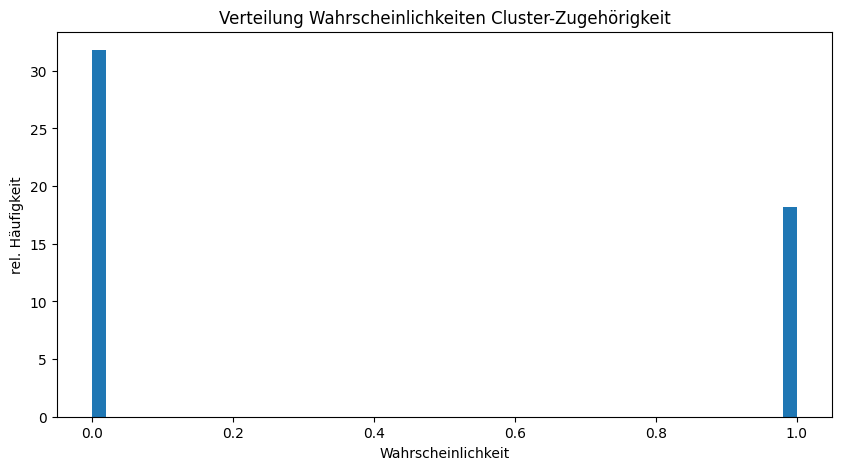

In [115]:
fig = plotHDBSCANProbabilities(hdbscan)

Ungefähr zwei Drittel der Filme konnten keiner Gruppe zugewiesen werden. Das grösste Cluster deckt etwa das restliche Drittel ab. Nur einzelne Filme wurden den zwei weiteren Cluster zugeschrieben.

In [116]:
pd.Series(hdbscan.labels_).value_counts()

-1    6777
 1    3861
 0       9
 2       8
dtype: int64

Wenig überraschend lässt sich bei diesem einen Cluster und den ungruppierten Filmen kein Muster erkennen, wenn man diese den Genres gegenüberstellt. Entweder gibt es keine oder eine nur sehr geringe Übereinstimmung zwischen Embeddings und Genres, oder `HDBSCAN` kann aufgrund seiner Funktionsweise keine Übereinstimmung feststellen. Eine andere Parameterisierung des Algorithmus bringt leider keine Verbesserung.

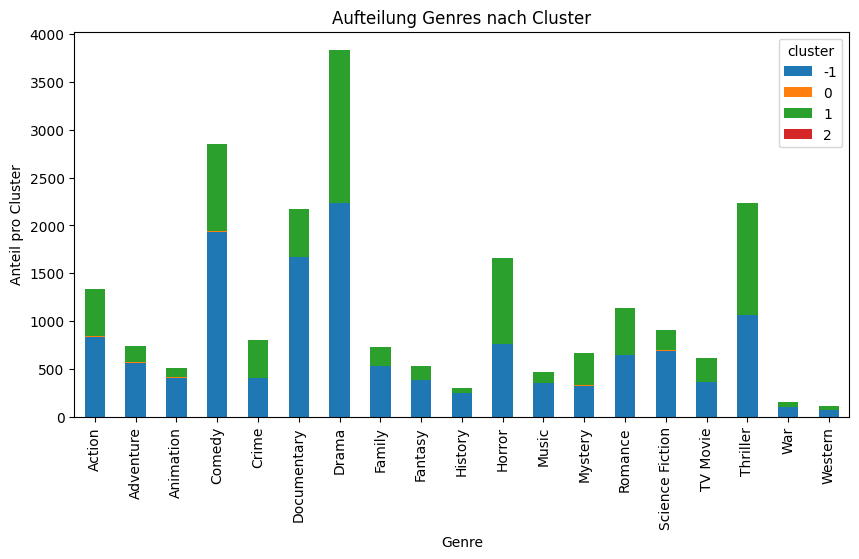

In [117]:
fig = plotHDBSCANClustersAlongGenres(hdbscan, genres)

Aus diesem Grund wollen wir nun noch UMAP einsetzen, in der Hoffnung, dass mit diesem Algorithmus womöglich Muster erkannt werden können.

In [118]:
umap = UMAP(min_dist=0.0, n_neighbors=10)
umap_embeddings = umap.fit_transform(sentence_embeddings)

Wenn wir die zweidimensionale Repräsentation der Embeddings über die verschiedenen Genres plotten können wir dieses Mal Ansammlungen von Filmen bei den Genres erkennen. Je nach Genre werden unterschiedliche Wertebereiche auf den beiden Komponenten abgebildet. Dokumentationsfilme tendieren eher Werte auf der unteren Hälfte der Skala von Komponente 1 abzudecken, wohingegen sich Horror- und Thriller-Filme eher auf der oberen Hälfte des Wertebereichs befinden. Diese beiden Genres sind auch eher ähnlich, somit scheint eine ähnliche Platzierung auch sinnvoll. Diese meist fiktionalen Genres unterscheiden sich stark von den nicht-fiktionalen Dokumentarfilmen, was die gegenteilige Anordnung auch erklären mag. Natürlich gibt es bei allen Genres Ausreisser. Dies mag einerseits damit zu tun haben, dass die Embeddings eben doch mehr Informationen als nur die Genres beinhalten und andererseits damit, dass die meisten Filme mehrere Genres zugewiesen haben.

Im Gegensatz zu den BERT-Embeddings sind bei den Embeddings von SBERT klar Muster zu erkennen.

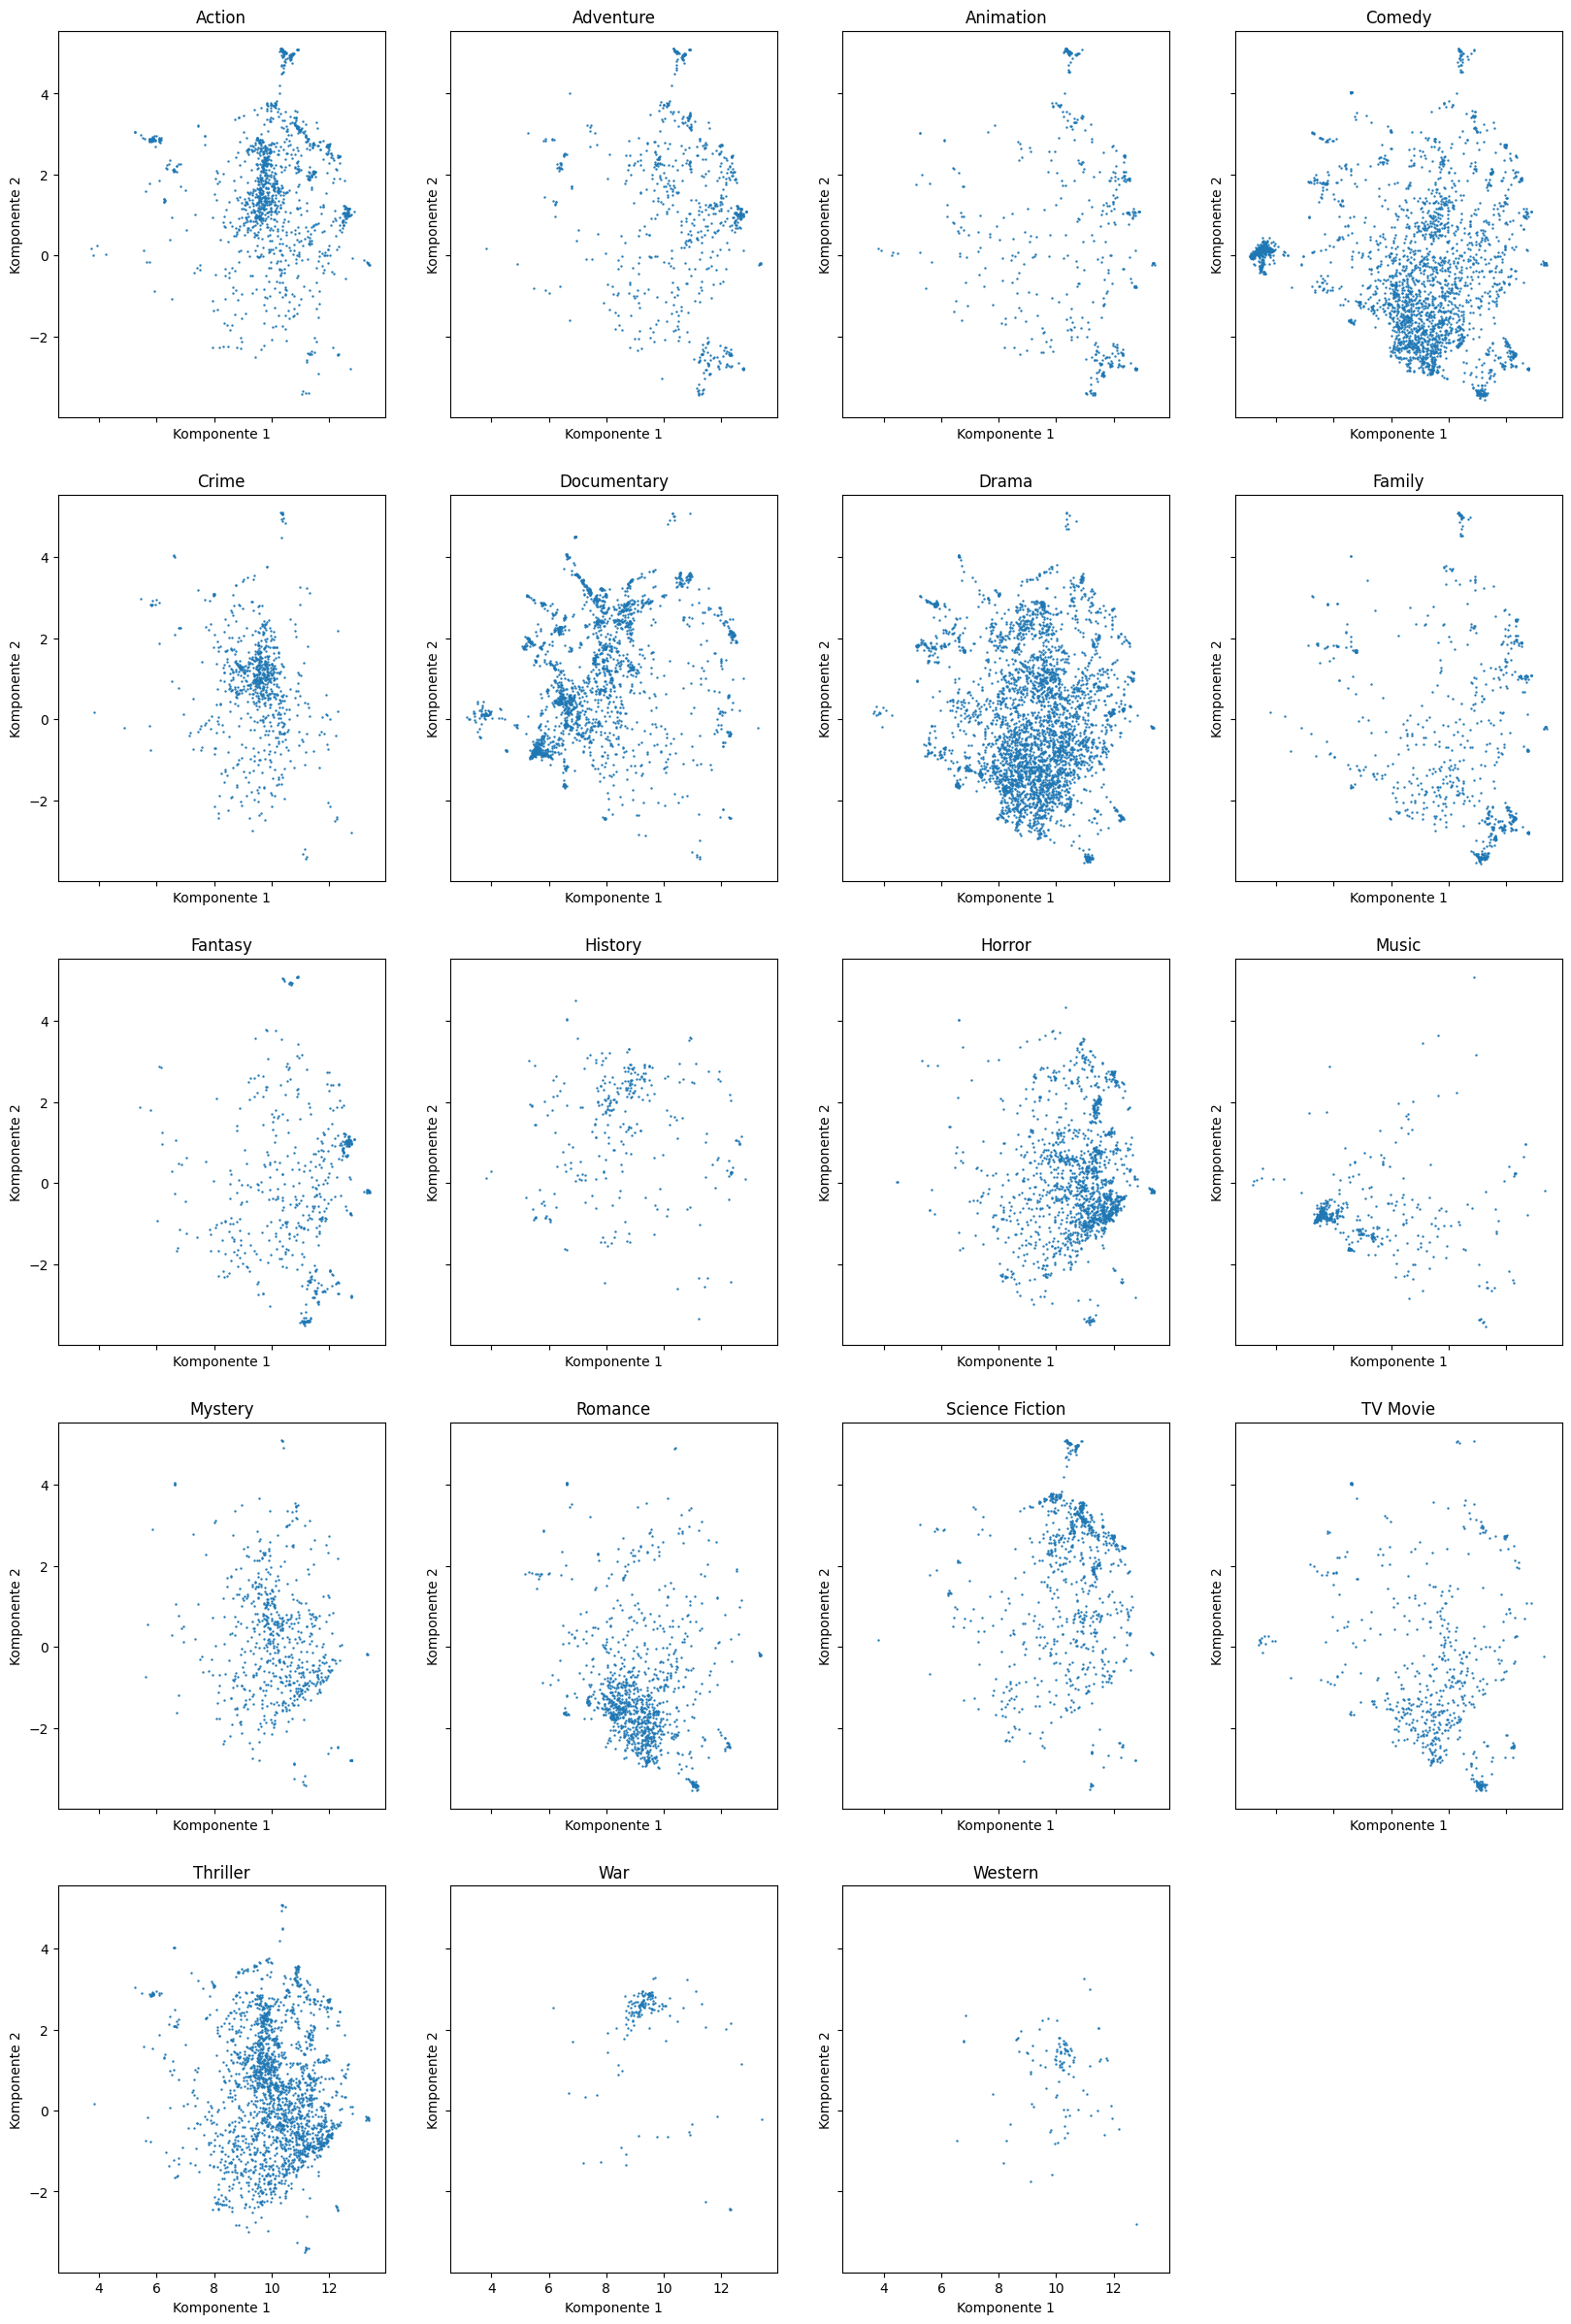

In [119]:
fig = plotUMAPEmbeddingsAlongGenres(umap_embeddings, genres)

Nachfolgend wollen wir nun einzelne Genres genauer anschauen. Da Filme mehreren Genres zugeordnet werden können, wollen wir ein einzelnes Genre mit den Top-3 Genres vergleichen, denen am meisten Filme des Hauptgenres zuegordnet wurden. Die folgenden Plots zeigen jeweils die UMAP-Projektion für Filme des Hauptgenres und der drei weiteren meistzugewiesenen Genres. Dabei werden jeweils die anderen Genres eingefärbt.

Wenn wir nun nur den Plot für das Genres Horror betrachten, können wir sehen, dass Filme, die auch als Thriller eingeteilt wurden, das ganze Horror-Spektrum abdecken. Die Genres scheinen also tatsächlich sehr ähnlich zu sein. Horrorfilme tendieren aber dazu Werte grösser als 10 auf der Komponente 1 anzunehmen. Dies können wir an der Verteilung bei Thriller, Drama und Comedy erkennen, für die es auch einige Filme unterhalb dieses Schwellwerts gibt. Die Horror-Filme sammeln sich abgesehen von einigen Ausreissern bei Drama und Comedy in lokalen Bereichen.

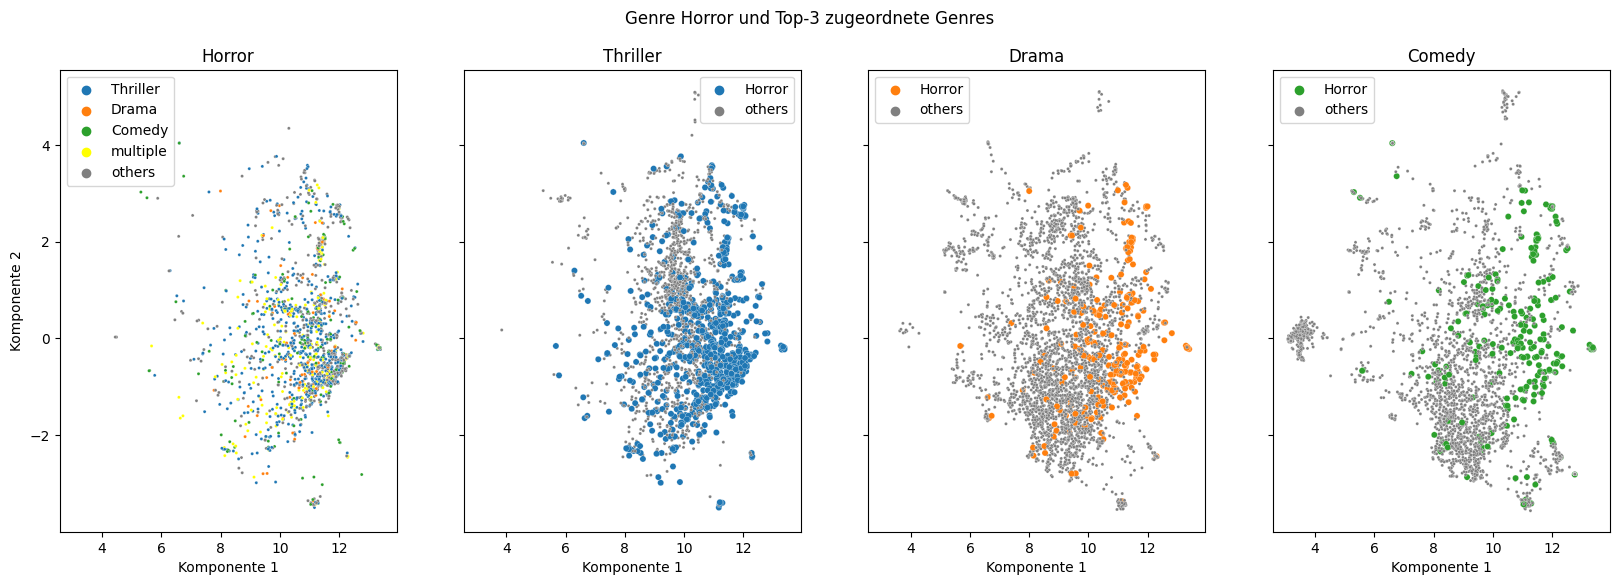

In [120]:
fig = plotUMAPEmbeddingsGenreAlongTopNGenres(umap_embeddings, genres, main_genre='Horror', n=3)

Wenn wir zum Genre Music wechseln, bei dem die Top-3 Genres auch aus Drama und Comedy besteht, sehen wir, dass sich hier die Music-Filme klar im unteren Bereich der Komponente-1-Skala befinden. Die Ansammlung von Filmen um 6 (Komponente 1) und zwischen -2 und 0 (Komponente 2) bei Music, ist bei den drei anderen Genres ganz klar zu erkennen und wird durch Music-Filme dominiert. Documentary Drama und Comedy sind viel breiter verteilt als Music, und Filme aus letzterem Genre befinden sich jeweils nur in einem kleinen Bereich der anderen Genres. Auch hier lassen sich also interessante Strukturen erkennen.

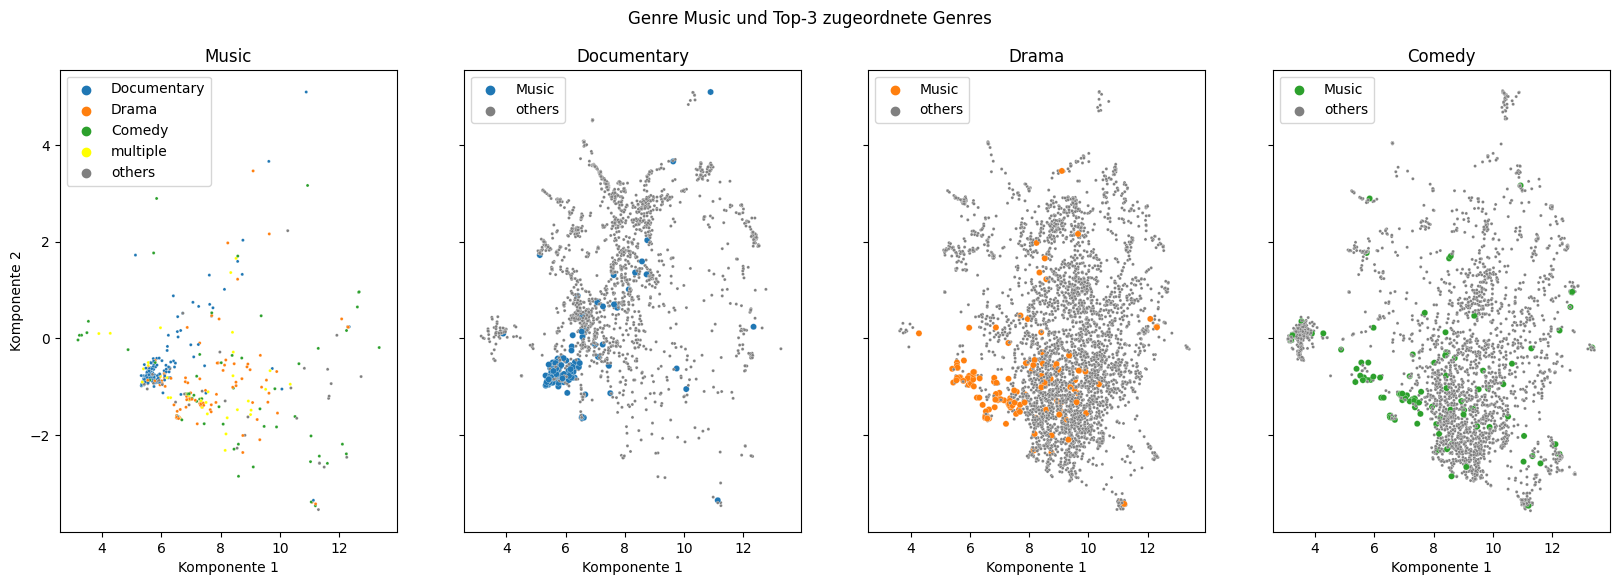

In [121]:
fig = plotUMAPEmbeddingsGenreAlongTopNGenres(umap_embeddings, genres, main_genre='Music', n=3)

Wir fahren mit dem Documentary-Genre fort. Hier ist Music das Top-Genre. Diejenigen Music-Filme, die auch Dokumentationen sind, sind dabei im oberen Bereich der Plots und die anderen eher weiter unten.

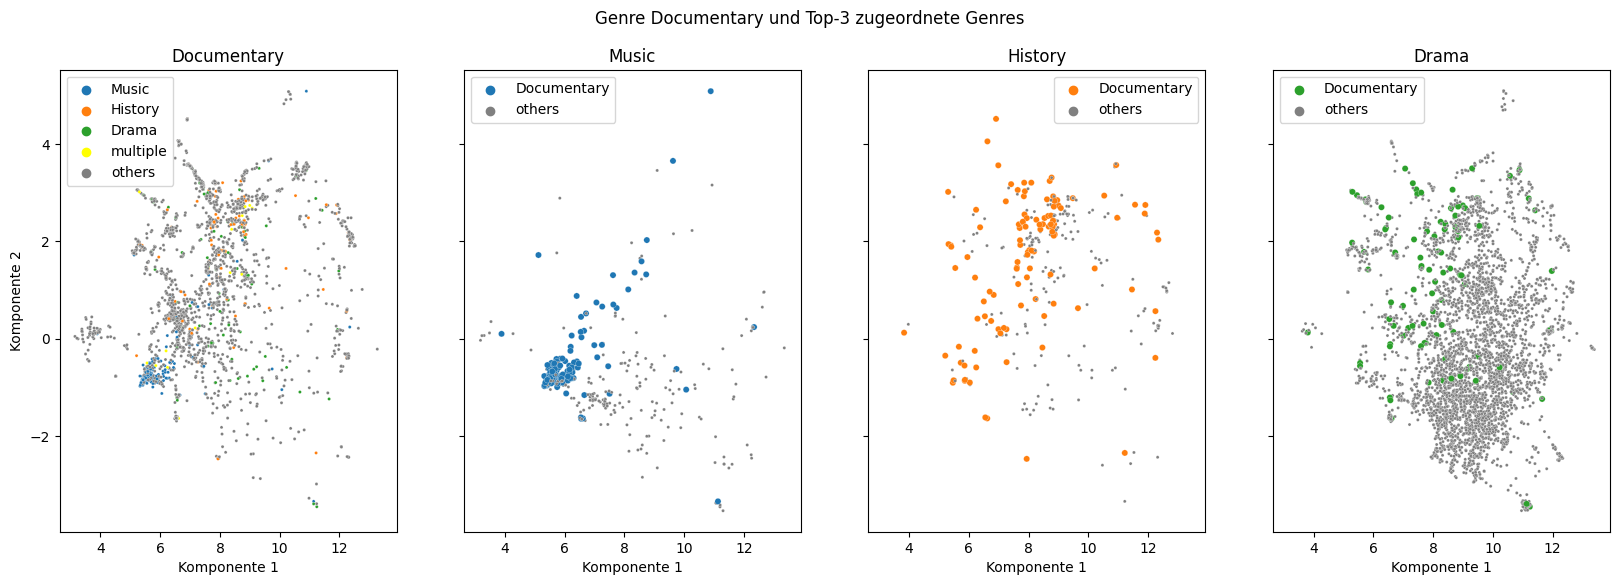

In [122]:
fig = plotUMAPEmbeddingsGenreAlongTopNGenres(umap_embeddings, genres, main_genre='Documentary', n=3)

Nachdem wir die Embeddings nun etwas analysiert haben, speichern wir diese nun als Featurematrix ab.

In [123]:
sentence_embeddings.to_csv('data/movies_sbert.csv')

## Modellierung des Recommendersystems

Da wir nun die Embeddings etwas besser kennen, können wir diese verwenden, um unser erstes Recommendersystem mit diesen Daten zu bauen. Auch hier verwenden wir wieder die tertiäre Skala, da sie die besten Resultate im Baseline-Recommendersystem geliefert hat.

In [124]:
config = CakeConfig(
    {MatrixGenerator.CONST_KEY_SBERT: np.array(1)},
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE,
)

In [125]:
matrix = MatrixGenerator(sbertEmbeddings=True)

eval = Evaluation('SBERTCakeommender', config, matrix)
mean_precision, std_precision = eval.precision()
print(f'Precision: {mean_precision.round(3)} (+/- {std_precision.round(3)})')

100%|██████████| 5/5 [04:24<00:00, 52.84s/it, mean=0.596, std=0.002]

Precision: 0.596 (+/- 0.002)


### Dimensionsreduktion mit PCA

Durch eine Dimensionsreduktion könnte das Modell möglicherweise noch weiter verbessert werden, da unwichtige Details entfernt werden. Ausserdem würde es die Berechnung der Ähnlichkeiten beschleunigen. Wie schon beim BERT-Recommendersystem testen wir nun wieder unterschiedliche Dimensionen für die Featurematrix und vergleichen anschliessend die Metriken.

In [126]:
results = [{
    'dim': 768,
    'mean_precision': mean_precision,
    'std_precision': std_precision,
    'topn_precision': eval.topNPrecision(),
    'novelty': eval.novelty()
}]

for dim in [2, 5, 10, 100, 200, 500]:
    pca = PCA(n_components=dim)
    reduced_embeddings = pca.fit_transform(sentence_embeddings)
    reduced_embeddings = pd.DataFrame(reduced_embeddings, index=sentence_embeddings.index)

    embeddings_file_reduced = f'data/movies_sbert_{dim}d.csv'
    reduced_embeddings.to_csv(embeddings_file_reduced)

    matrix = MatrixGenerator(sbertEmbeddings=embeddings_file_reduced)
    eval = Evaluation(f'SBERT_{dim}d', config, matrix)
    mean_precision, std_precision = eval.precision()
    results.append({
        'dim': dim,
        'mean_precision': mean_precision,
        'std_precision': std_precision,
        'topn_precision': eval.topNPrecision(),
        'novelty': eval.novelty()
    })

cakeommender finished 🥳: 100%|██████████| 8/8 [00:00<00:00, 14.27it/s] 


Durch die Reduktion auf zwei Dimensionen liefert das Modell nur noch so gute Werte wie das Modell mit Zufallsdaten. Hier scheint zuviel Informationen verloren gegangen zu sein. Erstaunlich ist, dass bereits mit fünf PCA-Komponenten nahezu ähnlich gute Resultate erzielt werden lönnen, wie mit den ursprünglichen Sentence-Embeddings. Bei der Top-10-Precision ist das Modell sogar deutlich besser als mit der vollständigen Embedding-Featurematrix. Weitere Komponenten können das Modell nicht mehr erhöhen und es werden sogar niedrigere Werte für die Metriken erreicht.

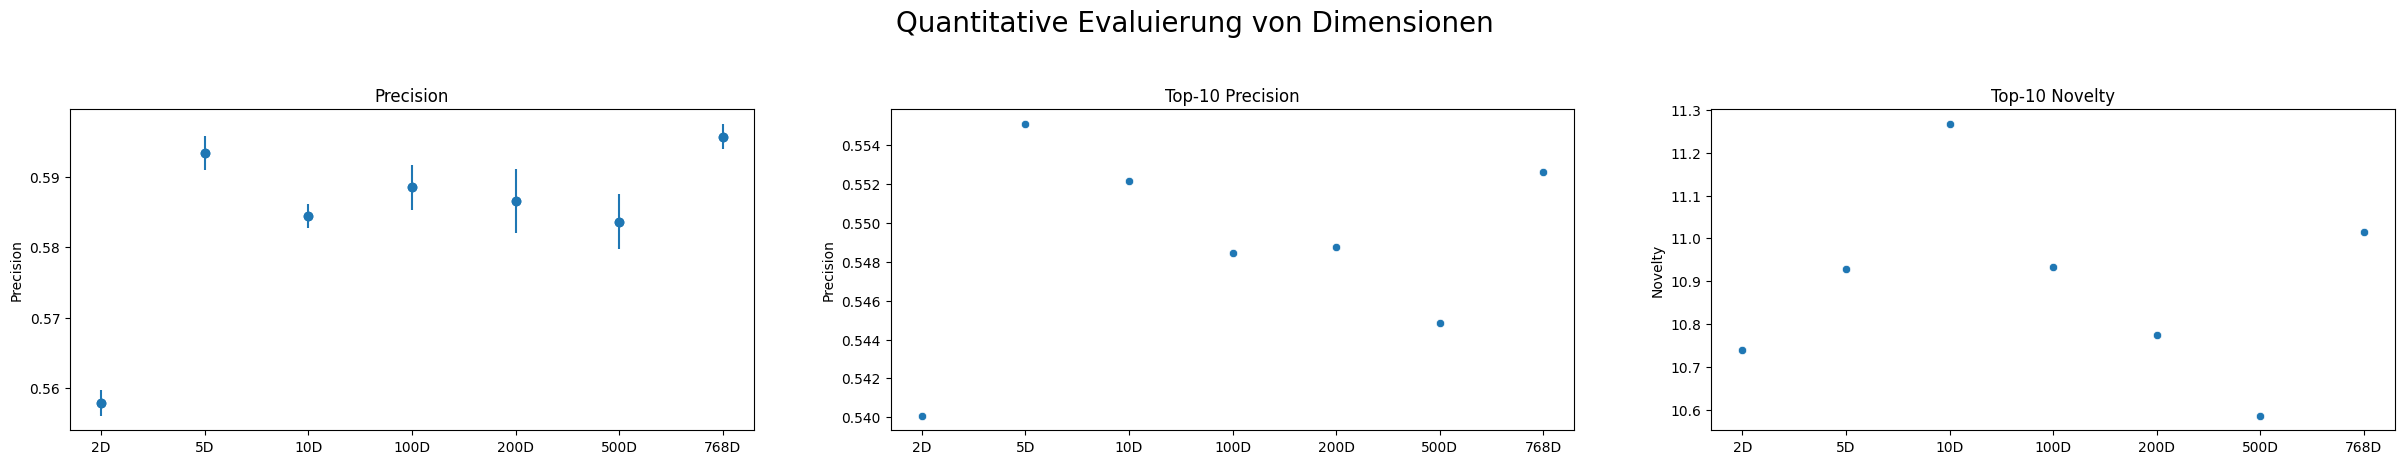

In [127]:
results_df = pd.DataFrame(results).sort_values('dim')
fig = plot_results(
    results_df.dim.astype(str) + 'D', results_df.mean_precision, results_df.std_precision, results_df.topn_precision, results_df.novelty, 'Dimensionen'
)

Dies ist insofern erstaunlich, dass mit fünf Komponenten nur ca. 15 % Varianz abgedeckt wird. In diesen Bruchteil scheinen jedoch die wichtigen Informationen vorhanden zu sein.

In [128]:
pca = PCA().fit(sentence_embeddings)
print(f'Enthaltene Varianz mit 5 Komponenten: {pca.explained_variance_ratio_[0:5].sum() * 100} %')

Enthaltene Varianz mit 5 Komponenten: 15.408096677816976 %


Um tatsächlich 95 % der Daten zu behalten, wären knapp 300 Komponentne nötig.

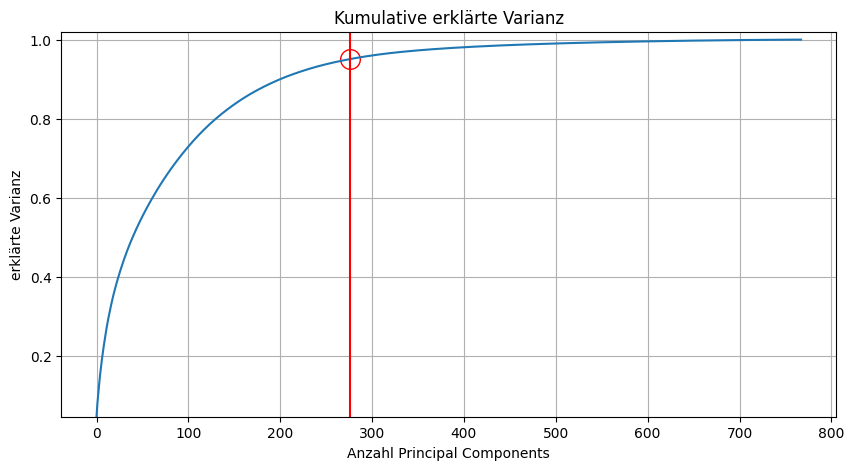

In [129]:
fig, _ = plotCumulativePCAVariance(pca)

In [130]:
%reset -f

In [131]:
import os
if os.getcwd().endswith('modelling'):
    os.chdir('..')

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libraries.pipeconfig import (
    CakeConfig,
    FeatureNormalizationEnum,
    SimilarityEnum,
    RatingScaleEnum,
)

from libraries.matrix import MatrixGenerator, MatrixLoader
from libraries.weights import WeightGenerator
from cakeommender import Cakeommender
from evaluation import Evaluation

# Kombiniertes Recommendersystem

Nachdem wir nun einige Recommendersysteme erstellt haben, wollen wir die erhaltenen Erkenntnisse nutzen, um durch Kombination der verschiedenen Featurematrizen noch bessere Modelle zu erhalten. Da unser Baseline-Recommendersystem auf Basis der herkömmlichen Features am besten abgeschnitten hat, dient es hier als Basis und wollen es mit einem NLP-Ansatz weiter verbessern. In dieser Kategorie hat SBERT die besten Werte erzielt, weswegen wir dessen Embeddings verwenden werden. Die kombinierte Featurematrix ist ziemlich gross und nicht alle Features erscheinen uns gleich wichtig. Deswegen variieren wir die Gewichtungen der Feature-Gruppen, so dass ein möglichst gutes Modell erreicht wird.

In [133]:
matrixBaseSbert = MatrixGenerator(metadata=True, genres=True, actors=True, directors=True, sbertEmbeddings='data/movies_sbert_5d.csv')
config = CakeConfig(
    {
        MatrixGenerator.CONST_KEY_METADATA: np.array(1),
        MatrixGenerator.CONST_KEY_GENRES: np.array(1),
        MatrixGenerator.CONST_KEY_ACTORS: np.array(0.4),
        MatrixGenerator.CONST_KEY_DIRECTORS: np.array(0),
        MatrixGenerator.CONST_KEY_SBERT: np.array(0.6)
    },
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE
)

Nach unterschiedlichsten getesteten Gewichtungen konnten keine signifikanten Verbesserungen gefunden werden. Somit benötigen wir für das beste Modell, was die Metriken betrifft keine NLP-Ansätze.

In [134]:
eval = Evaluation('Baseline_SBERT', config, matrixBaseSbert)
novelty = eval.novelty()
print('Novelty ' + str(round(novelty, 1)))
precisionMean, precisionStd = eval.precision()

topNPrecision = eval.topNPrecision()
print("Top-10 Precision " + str(round(topNPrecision, 2)))

cakeommender finished 🥳: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s] 


Novelty 11.2


cakeommender finished 🥳: 100%|██████████| 8/8 [00:02<00:00,  2.70it/s] 


Top-10 Precision 0.57


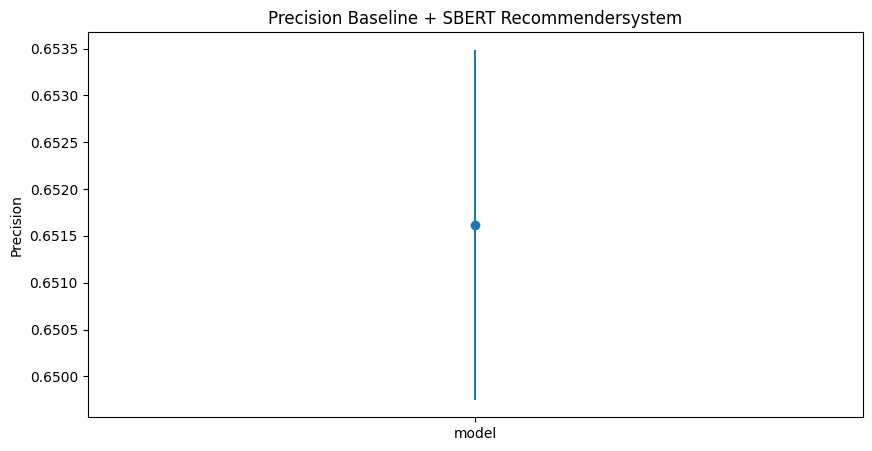

In [135]:
plt.figure(figsize = (10, 5))
plt.errorbar(['model'], precisionMean, yerr = precisionStd, fmt ='o')
plt.title('Precision Baseline + SBERT Recommendersystem')
plt.ylabel('Precision')
plt.show()

# Überprüfung des Modelles anhand von Vorschlägen

Es kommt überaschend, dass für ein optimales Modell keine NLP-Ansätze nötig sind. Um unser bestes Recommendersystem nun nochmals qualitativ zu überprüfen, werden ausgewählte Filme direkt als Userprofil verwendet und generieren daraus Empfehlungen. Wir wollen dabei untersuchen, was passiert wenn die SBERT-Embeddings stärker oder schwächer gewichtet werden.

In [136]:
matrixBase = MatrixGenerator(metadata=True, genres=True, actors=True, directors=True)
config = CakeConfig(
    {
        MatrixGenerator.CONST_KEY_METADATA: np.array(1),
        MatrixGenerator.CONST_KEY_GENRES: np.array(1),
        MatrixGenerator.CONST_KEY_ACTORS: np.array(0.4),
        MatrixGenerator.CONST_KEY_DIRECTORS: np.array(0),
    },
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE
)

bestModel = Cakeommender("Best_Baseline", config, matrixBase)

cakeommender finished 🥳: 100%|██████████| 8/8 [00:08<00:00,  1.12s/it] 


In [137]:
movies = pd.read_csv('./data/movies.csv', low_memory=False)[["movieId","original_title"]]

def predictTopNForMovie(partOfTitle: str, data: pd.DataFrame=movies, model: Cakeommender=bestModel) -> None:
    """
    Jan Zwicky
    print top-10 movies

    :param str partOfTitle: Part of a Title of a movie
    :param pd.DataFrame data: movies Data
    :param Cakeommender model: model
    """
    filteredMovies = data.loc[data["original_title"].str.contains(partOfTitle, na=False), :].iloc[0]

    model.calcAppUserProfiles([[filteredMovies["movieId"]]])
    recommendations = model.predictTopNForUser(users=["0"], n=10, removeRatedMovies=False)
    recommendations = pd.merge(data, recommendations, on="movieId", how="inner")["original_title"]
    recommendations.index = recommendations.index + 1

    print(f'Recommendations für Film {filteredMovies["original_title"]} von {model.name}:')
    print(recommendations)

Wenn wir uns die Top-10-Empfehlungen für den Film *Inception* für das Baseline- und das SBERT-Recommendersystem anschauen, sehen wir, dass die Vorschläge vollkommen unterschiedlich ausfallen. Sie scheinen aber in beiden Fällen plausibel und gut zu sein. Das Modell mit SBERT-Embeddings schlägt Filme sehr stark anhand dessen vor, was im Film passiert. Das Baseline-System fokussiert sich stärker auf Genres und Schauspieler.

In [138]:
matrixSbert = MatrixGenerator(sbertEmbeddings='data/movies_sbert_5d.csv')
config = CakeConfig(
    {
        MatrixGenerator.CONST_KEY_SBERT: np.array(1)
    },
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE
)
sbertModel = Cakeommender("SBERT", config, matrixSbert)

cakeommender finished 🥳: 100%|██████████| 8/8 [00:02<00:00,  2.81it/s] 


In [139]:
predictTopNForMovie("Inception", model=bestModel)

Recommendations für Film Inception von Best_Baseline:
1                   Peacock
2                 Inception
3              TRON: Legacy
4     2012: Time for Change
5     The Dark Knight Rises
6                   Retreat
7        Mad Max: Fury Road
8           Into the Forest
9                   Dunkirk
10               Flatliners
Name: original_title, dtype: object


In [140]:
predictTopNForMovie("Inception", model=sbertModel)

Recommendations für Film Inception von SBERT:
1                             Inception
2                                Icarus
3                            The Family
4              My Brother the Terrorist
5                             Complicit
6                            Code Black
7                       Justice Is Mind
8                        Freeway Killer
9     The Staircase II: The Last Chance
10           Survivor's Guide to Prison
Name: original_title, dtype: object


## Kombination

Nun wird nochmals versucht eine Kombination zwischen den beiden Recommendersystemen zu finden. Es sollten ähnlich viele Filme vom Baseline-, wie vom SBERT-Recommendersystem vorgeschlagen werden.

In [141]:
config = CakeConfig(
    {
        MatrixGenerator.CONST_KEY_METADATA: np.array(1),
        MatrixGenerator.CONST_KEY_GENRES: np.array(1),
        MatrixGenerator.CONST_KEY_ACTORS: np.array(0.4),
        MatrixGenerator.CONST_KEY_DIRECTORS: np.array(0),
        MatrixGenerator.CONST_KEY_SBERT: np.array(0.6)
    },
    SimilarityEnum.COSINE,
    RatingScaleEnum.TERTIARY,
    FeatureNormalizationEnum.ZSCORE
)
baseSbertModel = Cakeommender("Baseline_SBERT", config, matrixBaseSbert)

cakeommender finished 🥳: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s] 


Eine Kombination bestehend aus 60 % SBERT-Embeddings und den gleich bleibenden Gewichtungen des Baseline-Teils, ergibt einigermassen ausgeglichene Vorschläge, wie an den folgenden Top-10-Listen erkannt werden kann. Für Iron Man 2 werden wie erwartet diverse Marvel-Filme vorgeschlagen und für den Harry Potter-Film werden andere Filme aus der Reihe empfohlen, sowie Filme mit Bezug zu London, wo dieser Film spielt.

In [142]:
predictTopNForMovie("Inception", model=baseSbertModel)

Recommendations für Film Inception von Baseline_SBERT:
1                   Peacock
2                 Inception
3              TRON: Legacy
4     2012: Time for Change
5     The Dark Knight Rises
6                   Retreat
7        Mad Max: Fury Road
8           Into the Forest
9                   Dunkirk
10               Flatliners
Name: original_title, dtype: object


In [143]:
predictTopNForMovie("Iron Man 2", model=baseSbertModel)

Recommendations für Film Iron Man 2 von Baseline_SBERT:
1                                Iron Man 2
2                              The Avengers
3                                Iron Man 3
4                                      Chef
5                   Avengers: Age of Ultron
6                Captain America: Civil War
7           Marvel One-Shot: The Consultant
8       Marvel: 75 Years, From Pulp to Pop!
9     Marvel Studios: Assembling a Universe
10                  Solo: A Star Wars Story
Name: original_title, dtype: object


In [144]:
predictTopNForMovie("Ted", model=baseSbertModel)

Recommendations für Film Ted von Baseline_SBERT:
1      The Drawn Together Movie: The Movie!
2                                       Ted
3                                 The Whale
4                         Hunting Elephants
5         A Million Ways to Die in the West
6                            Into the Storm
7                  Sinbad: The Fifth Voyage
8                                     Ted 2
9     Dragonheart: Battle for the Heartfire
10                                     Loom
Name: original_title, dtype: object


In [145]:
predictTopNForMovie("Harry Potter", model=baseSbertModel)

Recommendations für Film Harry Potter and the Deathly Hallows: Part 1 von Baseline_SBERT:
1                              Alice in Wonderland
2     Harry Potter and the Deathly Hallows: Part 1
3     Harry Potter and the Deathly Hallows: Part 2
4                                             Neds
5                       London: The Modern Babylon
6                                       Paddington
7                                      Sunset Song
8                  Alice Through the Looking Glass
9           A Grand Night In: The Story of Aardman
10                                    Paddington 2
Name: original_title, dtype: object


## Fazit

Die Grundlage eines content-based Recommendersystems sind dessen Features, aufgrund von welchen die Ähnlichkeiten zwischen den Filmen (bzw. Nutzern) berechnet werden können. Im Falle von Filmen ist es schwierig diese genug fein zu charakterisieren. Es existieren zwar Metadaten und Genres, aber diese beschreiben den Film nur obeflächlich und die Handlung des Films kann daraus nicht extrahiert werden. Andere Eigenschaften wie Drehorte, Aufbau und Dramaturgie sind für die meisten Filmen nicht verfügbar und wenn können sie nicht direkt als Features verwendet werden. Doch scheinen uns diese Informationen besonders relevant zu sein, um Empfehlungen zu Filmen erstellen zu können. Genres können ein guter Indikator sein, um zu beschreiben, welche Filme ein User mag. Da es aber unzählige Filme zu einem Genre gibt und in der Regel nicht nur ein einzelnes Genre von einem User präferiert wird, kann man die Filmauswahl nur leicht einschränken.

Was für die allermeisten Filme zur Verfügung steht, ist eine kurze Beschreibung, die einige Schlüsselwörter zum Film enthält. Diese ist zwar kurz, doch kann an dieser mehr über den Film bestimmt werden als nur über dessen Genres. Aus diesem Grund erscheint es sinnvoll diese als Grundlage für ein Recommendersystem zu verwenden. Um diese Beschreibung in Zahlen und somit für das Modell brauchbare Features umzuwandeln, bietet sich Natural Language Processing an. Beim Testen von unterschiedlichen NLP-Algorithmen und -Modellen ist uns aufgefallen, dass sich nicht alle für diese Aufgabe eignen. Im Falle von TDIDF werden die Featurematrizen sehr schnell sehr gross, was unter anderem die Berechnung der Ähnlichkeiten stark verlangsamt. Zudem kann damit auch kein besonders gutes System erstellt werden. Mit Sentence-Embeddings kann, unabhängig von unseren getesteten Berechnungsarten, auch kein deutlich besseres Recommendersystem modelliert werden. Dies war jedoch zu erwarten, da sich diese Embeddings nicht für die Berechnung von Ähnlichkeiten zueinander eignen. Die fehlende Struktur konnten wir auch in unserer Embedding-Evaluierung feststellen.

Speziell für unseren Anwendungsfall, dem Berechnen von Cosine-Ähnlichkeiten zwischen Embeddings, wurde das SBERT-Modell entwickelt, mit wessen Sentence-Embeddings wir auch mit Abstand die besten Resultate von allen NLP-Systemen erzielt haben. Dennoch waren dessen Precision-Werte immer noch leicht schlechter als die unseres Baseline-Modells auf Basis von Metadaten. Insgesamt konnten bei allen Systemen Werte für die Metriken erzielt werden, die nur leicht besser waren als beim Modell mit Zufallsfeatures. Bei Betrachtung der tatsächlichen Empfehlungen konnten wir jedoch feststellen, dass die Modelle trotz der mittelmässigen quantitativen Evaluierungsresultate doch sinnvolle Filmvorschläge machen. Dabei war auch zu erkennen, dass das Modell auf Basis von Metadaten und das Modell auf Basis der Filmbeschreibung andere Filme empfehlen. Während das erstgenannte vor allem auf die Genres abzielte, schlägt das NLP-Recommendersystem anhand des Kontexts Filme vor. Dabei werden auch Filme aus der gleichen Reihe und des gleichen Studios empfohlen, was man nicht aus den blossen Metadaten und Genres erkennen kann.

Aus diesem Grund erscheint es uns sinnvoll, die beiden Ansätze miteinander zu kombinieren, um die Vorschläge auch etwas zu diversifizieren. Mit dem kombinierten Modell aus Metadaten und SBERT-Embeddings konnten die quantitativen Messwerte nicht verbessert werden und sind gleich hoch wie ohne Embeddings, doch scheinen die Filmempfehlungen dadurch weniger eintöntig zu sein. Es werden so nicht mehr nur irgendwelche Filme mit gleichen Genres empfohlen oder alle Fortsetzungen eines Films. Die beiden Strategien werden dadurch kombiniert und es entstehen ansprechende Empfehlungen.

Dass die meisten Modelle bei der quantitativen Evaluierung zwar relativ hohe, aber doch sehr ähnliche Werte erzielt haben, könnte mit unserer Definition eines guten Films zu tun haben. Wir definierten, dass eine Bewertung als positiv gilt, wenn sich die Bewertung in den oberen 40 % des Bewertungsbereichs des Nutzers befindet. Diese dynamische Grenze pro User erschien uns sinnvoll, um auf das spezifische Bewertungsverhalten der Nutzenden einzugehen, da es durchaus kritischere und wohlwollendere Menschen gibt. Dieses Verfahren funktioniert jedoch weniger gut, wenn Nutzende ausschliesslich Bewertungen im oberen oder im unteren Bereich der Ratingskala abgegeben haben. Dann werden diese positiven resp. negativen Bewertungen in positiv und negativ eingeteilt, was nicht in der Absicht des Bewertenden gewesen sein mag. Da die Precision auf dieser positiv-negativ-Information aufbaut, ist es gut möglich, dass diese durch diesen Umstand weniger aussagekräftig ist. Bei Fortführung dieses Projekts, wäre es sinnvoll diesen Rating-Split nochmals zu überdenken und zu überarbeiten.

Beim Testen der unterschiedlichen Konfigurationsmöglichkeiten des Recommendersystems sind in den meisten Fällen keine grossen Unterschiede erkennbar gewesen. Erstaunt hat uns, aber dass die tertiäre Ratingskala am besten abgeschnitten und sogar die standardisierte übertroffen hat. Dass diese besser funktioniert als die binäre, haben wir erwartet, da bei der binären nicht zwischen negativ bewerteten und gar nicht bewerteten Filmen unterschieden werden kann. Wir vermuteten aber, dass die drei Stufen der tertiären Skala dennoch zu ungenau seien und erst durch die kontinuierliche standardisierte Skala genug Informationen vorhanden sind, um ein ausgefeiltes Userprofil erstellen zu können. Die tertiäre Skala scheint aber ausreichend Informationen zu enthalten und womöglich leidet die standardisierte Skala unter zuviel Noise, also kleineren Schwankungen bei den Bewertungen, die das Userprofil ungenauer machen.

Unsere Empfehlung für ein optimales Recommendersystem bei unserem untersuchten Anwendungsfall besteht aus Film-Metadaten und einer Filmbeschreibung, die mittels SBERT in Embeddings transformiert wurde. Dieses Modell möchten wir im nächsten Schritt in einen Prototyp integrieren. Dabei testen wir auch wie es sich verhält, wenn zwei Userprofile kombiniert werden, damit für beide gemeinsame Empfehlungen erstellt werden können.

In [146]:
%reset -f